In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import optuna
data = scipy.io.loadmat('data/assignmentImageDenoising_brainMRIslice.mat')

print("Keys in the loaded data:")
print(list(data.keys()))

Keys in the loaded data:
['__header__', '__version__', '__globals__', 'brainMRIsliceNoisy', 'brainMRIsliceOrig']


In [2]:

image_noiseless = data['brainMRIsliceOrig']
image_noisy = data['brainMRIsliceNoisy']


print(f"Noiseless image shape: {image_noiseless.shape}")
print(f"Noisy image shape: {image_noisy.shape}")
print(f"Image data type: {image_noiseless.dtype}")
print(f"Noiseless image range: [{np.min(image_noiseless):.3f}, {np.max(image_noiseless):.3f}]")
print(f"Noisy image range: [{np.min(image_noisy):.3f}, {np.max(image_noisy):.3f}]")

Noiseless image shape: (256, 256)
Noisy image shape: (256, 256)
Image data type: float64
Noiseless image range: [0.000, 1.000]
Noisy image range: [0.001, 1.204]


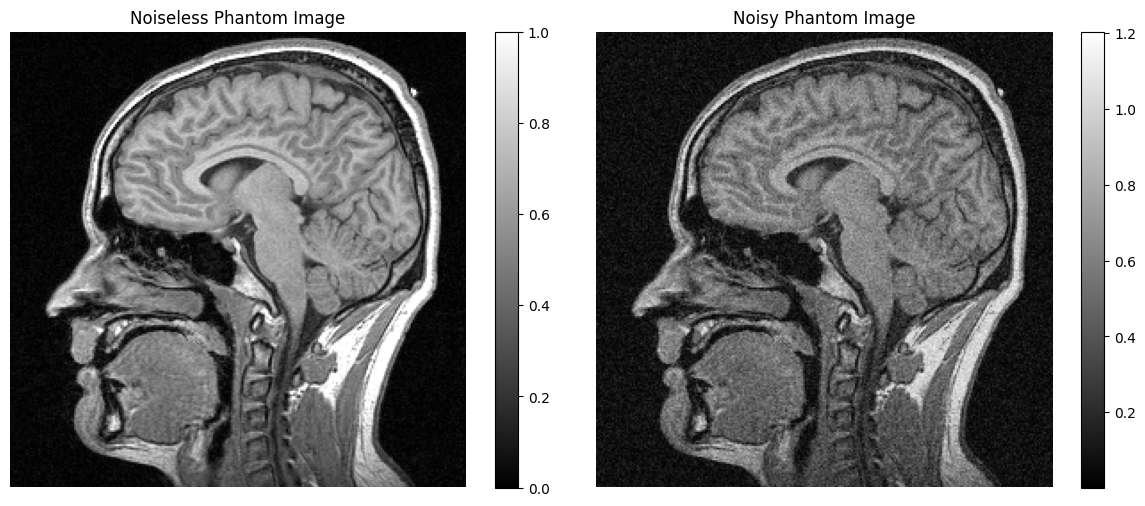

In [3]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_noiseless, cmap='gray')
plt.title('Noiseless Phantom Image')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title('Noisy Phantom Image')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

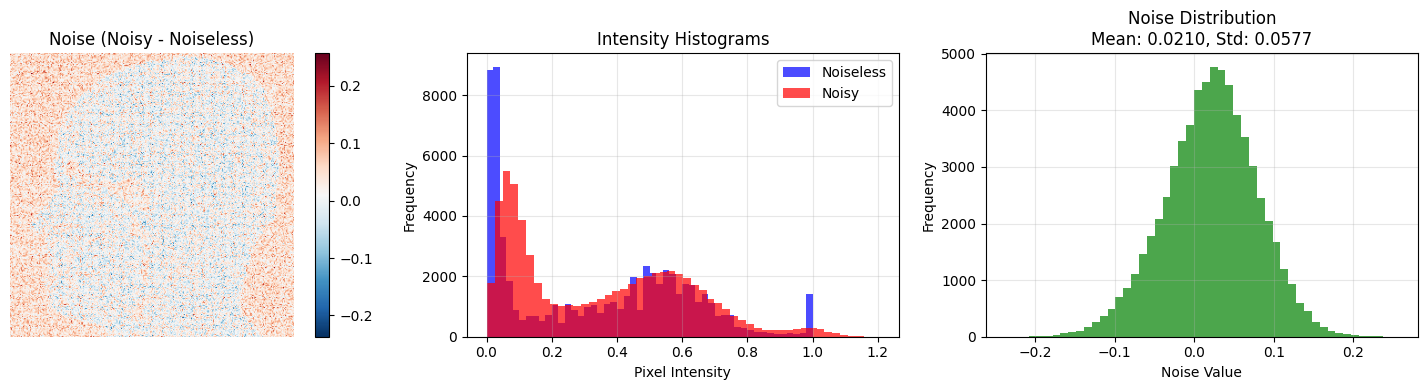

Summary Statistics:
Image size: (256, 256)
Noise standard deviation: 0.0577
Noise mean: 0.0210
Signal-to-Noise ratio (SNR): 13.63 dB


In [4]:
noise = image_noisy - image_noiseless
noise_std = np.std(noise)
noise_mean = np.mean(noise)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(noise, cmap='RdBu_r')
plt.title('Noise (Noisy - Noiseless)')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.hist(image_noiseless.flatten(), bins=50, alpha=0.7, label='Noiseless', color='blue')
plt.hist(image_noisy.flatten(), bins=50, alpha=0.7, label='Noisy', color='red')
plt.title('Intensity Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(noise.flatten(), bins=50, alpha=0.7, color='green')
plt.title(f'Noise Distribution\nMean: {noise_mean:.4f}, Std: {noise_std:.4f}')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Summary Statistics:")
print(f"Image size: {image_noiseless.shape}")
print(f"Noise standard deviation: {noise_std:.4f}")
print(f"Noise mean: {noise_mean:.4f}")
print(f"Signal-to-Noise ratio (SNR): {20 * np.log10(np.std(image_noiseless) / noise_std):.2f} dB")

# Bayesian Denoising with MRF Priors


In [5]:
import numpy as np
from scipy.ndimage import shift
import time

def circshift(image, shift_vector):
  
    shifted = np.roll(image, shift_vector[0], axis=0)
    shifted = np.roll(shifted, shift_vector[1], axis=1)
    return shifted

def compute_rrmse(A, B):
 
    # RRMSE(A,B) = sqrt(sum((A-B)^2) / sum(A^2))
    
    numerator = np.sum((A - B) ** 2)
    denominator = np.sum(A ** 2)
    return np.sqrt(numerator / denominator)

def quadratic_prior(u):
  
    # Quadratic potential function: g1(u) = |u|^2

    return u ** 2

def quadratic_prior_gradient(u):

    # Gradient of quadratic potential function: g1'(u) = 2u
  
    return 2 * u

def huber_prior(u, gamma):
    """
    Discontinuity-adaptive Huber potential function:
    g2(u) = 0.5|u|^2 if |u| <= gamma
    g2(u) = gamma|u| - 0.5*gamma^2 if |u| > gamma
    """
    abs_u = np.abs(u)
    return np.where(abs_u <= gamma, 
                    0.5 * u ** 2,
                    gamma * abs_u - 0.5 * gamma ** 2)

def huber_prior_gradient(u, gamma):
    """
    Gradient of Huber potential function:
    g2'(u) = u if |u| <= gamma
    g2'(u) = gamma*sign(u) if |u| > gamma
    """
    abs_u = np.abs(u)
    return np.where(abs_u <= gamma,
                    u,
                    gamma * np.sign(u))

def discontinuity_preserving_prior(u, gamma):
    """
    Discontinuity-preserving potential function:
    g3(u) = gamma * |u| - gamma**2 * log(1 + |u|/gamma)
    """
    abs_u = np.abs(u)
    return gamma * abs_u - gamma**2 * np.log(1 + abs_u / gamma)

def discontinuity_preserving_prior_gradient(u, gamma):
    """
    Gradient of discontinuity-preserving potential function:
    g3'(u) = u / (1 + |u|/gamma)
    """
    return u / (1 + np.abs(u) / gamma)

print("Prior functions and utility functions defined successfully!")

Prior functions and utility functions defined successfully!


In [6]:
def compute_neighbor_differences(x):
 
    left_neighbor = circshift(x, [0, -1]) 
    right_neighbor = circshift(x, [0, 1])  
    up_neighbor = circshift(x, [-1, 0])   
    down_neighbor = circshift(x, [1, 0])
    diff_left = x - left_neighbor
    diff_right = x - right_neighbor
    diff_up = x - up_neighbor
    diff_down = x - down_neighbor
    
    return [diff_left, diff_right, diff_up, diff_down]

def compute_mrf_energy(x, prior_func, gamma=None):
 
    # Compute MRF prior energy for an image
  
    differences = compute_neighbor_differences(x)
    energy = 0
    
    for diff in differences:
        if gamma is not None:
            energy += np.sum(prior_func(diff, gamma))
        else:
            energy += np.sum(prior_func(diff))
    
    return energy

def compute_mrf_gradient(x, prior_gradient_func, gamma=None):
  
    # Compute gradient of MRF prior energy
   
    differences = compute_neighbor_differences(x)
    gradient = np.zeros_like(x)
    for i, diff in enumerate(differences):
        if gamma is not None:
            grad_diff = prior_gradient_func(diff, gamma)
        else:
            grad_diff = prior_gradient_func(diff)
        gradient += grad_diff
        
        if i == 0:  
            gradient -= circshift(grad_diff, [0, 1])
        elif i == 1:  
            gradient -= circshift(grad_diff, [0, -1])
        elif i == 2:  
            gradient -= circshift(grad_diff, [1, 0])
        elif i == 3:  
            gradient -= circshift(grad_diff, [-1, 0])
    
    return gradient

print("MRF energy and gradient functions defined successfully!")

MRF energy and gradient functions defined successfully!


In [7]:
def bayesian_denoising(noisy_image, alpha, prior_type='quadratic', gamma=1.0, 
                      max_iterations=100, tolerance=1e-6, sigma=1.0):
    
    x = noisy_image.copy()
    objective_values = []
    
    if prior_type == 'quadratic':
        prior_func = quadratic_prior
        prior_grad_func = quadratic_prior_gradient
        use_gamma = False
    elif prior_type == 'huber':
        prior_func = huber_prior
        prior_grad_func = huber_prior_gradient
        use_gamma = True
    elif prior_type == 'discontinuity_preserving':
        prior_func = discontinuity_preserving_prior
        prior_grad_func = discontinuity_preserving_prior_gradient
        use_gamma = True
    else:
        raise ValueError("prior_type must be 'quadratic', 'huber', or 'discontinuity_preserving'")
    
    step_size = 0.1
    temperature = 1.0
    cooling_rate = 0.975

    for iteration in range(max_iterations):
        likelihood_gradient = (1 / sigma**2) * (noisy_image - x)
        
        if use_gamma:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func, gamma)
        else:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func)
        total_gradient = (1 - alpha) * likelihood_gradient - alpha * prior_gradient
        
        likelihood_energy = -0.5 / (sigma**2) * np.sum((x - noisy_image)**2)
        if use_gamma:
            prior_energy = -compute_mrf_energy(x, prior_func, gamma)
        else:
            prior_energy = -compute_mrf_energy(x, prior_func)
        
        current_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy
        objective_values.append(current_objective)
        
        x_new, new_objective, accepted = simulated_annealing_step(x,total_gradient,current_objective,noisy_image,alpha,prior_func,gamma if use_gamma else None,sigma,step_size,temperature, iteration)
        x = x_new
        temperature *= cooling_rate
        if iteration > 0:
            if objective_values[-1] - objective_values[-2] < tolerance:
                print(f"Converged after {iteration + 1} iterations")
                break
            if objective_values[-1] < objective_values[-2]:
                print(f"Warning: Objective decreased at iteration {iteration + 1}")
        
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: Objective = {current_objective:.6f}, Step size = {step_size:.6f}")
    
    return x, objective_values

def simulated_annealing_step(x,gradient,current_obj,noisy_image,alpha,prior_func,gamma,sigma,base_step,temperature, iteration):
  
    # One simulated annealing update step
    step = base_step / (iteration+1)
    x_trial = x + step * gradient

    likelihood_energy = -0.5 / (sigma**2) * np.sum((x_trial - noisy_image)**2)

    if gamma is not None:
        prior_energy = -compute_mrf_energy(x_trial, prior_func, gamma)
    else:
        prior_energy = -compute_mrf_energy(x_trial, prior_func)

    trial_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy

    delta_obj = trial_objective - current_obj

    if delta_obj >= 0:
        accept = True
    else:
        accept_prob = np.exp(delta_obj / temperature)
        accept = np.random.rand() < accept_prob
    if accept:
        return x_trial, trial_objective, True
    else:
        return x, current_obj, False

print("Bayesian denoising algorithm implemented successfully!")

Bayesian denoising algorithm implemented successfully!


## Testing the Denoising Algorithm

Now let's test our Bayesian denoising algorithm with different MRF priors and find optimal parameters.

In [8]:
def objective_quadratic(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='quadratic',
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_quad = optuna.create_study(direction="minimize")
study_quad.optimize(objective_quadratic, n_trials=50)

best_alpha_quad = study_quad.best_params["alpha"]
best_rrmse_quad = study_quad.best_value

print(f"Best alpha (Quadratic): {best_alpha_quad}")
print(f"Best RRMSE (Quadratic): {best_rrmse_quad:.6f}")


[I 2026-02-07 00:06:30,908] A new study created in memory with name: no-name-0f8e5c9b-c7c2-4eaf-a6ca-63f44b8e41f4


Iteration 10: Objective = -319.810201, Step size = 0.100000
Iteration 20: Objective = -299.412839, Step size = 0.100000
Iteration 30: Objective = -291.114304, Step size = 0.100000
Iteration 40: Objective = -286.318282, Step size = 0.100000
Iteration 50: Objective = -283.092534, Step size = 0.100000
Iteration 60: Objective = -280.728644, Step size = 0.100000
Iteration 70: Objective = -278.897793, Step size = 0.100000
Iteration 80: Objective = -277.423850, Step size = 0.100000
Iteration 90: Objective = -276.202840, Step size = 0.100000


[I 2026-02-07 00:06:31,712] Trial 0 finished with value: 0.14395104990406338 and parameters: {'alpha': 0.2464516036494701}. Best is trial 0 with value: 0.14395104990406338.


Iteration 100: Objective = -275.168887, Step size = 0.100000
Iteration 10: Objective = -124.206680, Step size = 0.100000
Iteration 20: Objective = -119.984852, Step size = 0.100000
Iteration 30: Objective = -117.992256, Step size = 0.100000
Iteration 40: Objective = -116.748018, Step size = 0.100000
Iteration 50: Objective = -115.867484, Step size = 0.100000
Iteration 60: Objective = -115.197797, Step size = 0.100000
Iteration 70: Objective = -114.663948, Step size = 0.100000
Iteration 80: Objective = -114.224032, Step size = 0.100000
Iteration 90: Objective = -113.852467, Step size = 0.100000


[I 2026-02-07 00:06:32,403] Trial 1 finished with value: 0.12495547279080009 and parameters: {'alpha': 0.042088691730001994}. Best is trial 1 with value: 0.12495547279080009.


Iteration 100: Objective = -113.532586, Step size = 0.100000
Iteration 10: Objective = -359.238536, Step size = 0.100000
Iteration 20: Objective = -334.472432, Step size = 0.100000
Iteration 30: Objective = -324.067818, Step size = 0.100000
Iteration 40: Objective = -317.926677, Step size = 0.100000
Iteration 50: Objective = -313.731509, Step size = 0.100000
Iteration 60: Objective = -310.619245, Step size = 0.100000
Iteration 70: Objective = -308.184279, Step size = 0.100000
Iteration 80: Objective = -306.207105, Step size = 0.100000
Iteration 90: Objective = -304.556996, Step size = 0.100000


[I 2026-02-07 00:06:33,065] Trial 2 finished with value: 0.174307575829838 and parameters: {'alpha': 0.4484158748285371}. Best is trial 1 with value: 0.12495547279080009.


Iteration 100: Objective = -303.150498, Step size = 0.100000
Iteration 10: Objective = -7.249798, Step size = 0.100000
Iteration 20: Objective = -7.235128, Step size = 0.100000
Iteration 30: Objective = -7.227636, Step size = 0.100000
Iteration 40: Objective = -7.222730, Step size = 0.100000
Iteration 50: Objective = -7.219137, Step size = 0.100000
Iteration 60: Objective = -7.216330, Step size = 0.100000
Iteration 70: Objective = -7.214042, Step size = 0.100000
Iteration 80: Objective = -7.212121, Step size = 0.100000


[I 2026-02-07 00:06:33,775] Trial 3 finished with value: 0.14118440953305755 and parameters: {'alpha': 0.0019457753349051339}. Best is trial 1 with value: 0.12495547279080009.


Iteration 90: Objective = -7.210472, Step size = 0.100000
Iteration 100: Objective = -7.209032, Step size = 0.100000
Iteration 10: Objective = -13.039453, Step size = 0.100000
Iteration 20: Objective = -12.992002, Step size = 0.100000
Iteration 30: Objective = -12.967851, Step size = 0.100000
Iteration 40: Objective = -12.952068, Step size = 0.100000
Iteration 50: Objective = -12.940527, Step size = 0.100000
Iteration 60: Objective = -12.931521, Step size = 0.100000
Iteration 70: Objective = -12.924189, Step size = 0.100000
Iteration 80: Objective = -12.918038, Step size = 0.100000
Iteration 90: Objective = -12.912761, Step size = 0.100000


[I 2026-02-07 00:06:34,545] Trial 4 finished with value: 0.14020660362886908 and parameters: {'alpha': 0.003533949877445982}. Best is trial 1 with value: 0.12495547279080009.


Iteration 100: Objective = -12.908155, Step size = 0.100000
Iteration 10: Objective = -277.562060, Step size = 0.100000
Iteration 20: Objective = -260.088016, Step size = 0.100000
Iteration 30: Objective = -252.864266, Step size = 0.100000
Iteration 40: Objective = -248.668585, Step size = 0.100000
Iteration 50: Objective = -245.841562, Step size = 0.100000
Iteration 60: Objective = -243.768906, Step size = 0.100000
Iteration 70: Objective = -242.163914, Step size = 0.100000
Iteration 80: Objective = -240.872484, Step size = 0.100000
Iteration 90: Objective = -239.803438, Step size = 0.100000


[I 2026-02-07 00:06:35,724] Trial 5 finished with value: 0.12974366449739666 and parameters: {'alpha': 0.16211371530790164}. Best is trial 1 with value: 0.12495547279080009.


Iteration 100: Objective = -238.898916, Step size = 0.100000
Iteration 10: Objective = -152.857630, Step size = 0.100000
Iteration 20: Objective = -146.551519, Step size = 0.100000
Iteration 30: Objective = -143.642995, Step size = 0.100000
Iteration 40: Objective = -141.851176, Step size = 0.100000
Iteration 50: Objective = -140.595198, Step size = 0.100000
Iteration 60: Objective = -139.647003, Step size = 0.100000
Iteration 70: Objective = -138.895667, Step size = 0.100000
Iteration 80: Objective = -138.279653, Step size = 0.100000


[I 2026-02-07 00:06:36,523] Trial 6 finished with value: 0.12266570443125722 and parameters: {'alpha': 0.05571526864673705}. Best is trial 6 with value: 0.12266570443125722.


Iteration 90: Objective = -137.761608, Step size = 0.100000
Iteration 100: Objective = -137.317322, Step size = 0.100000
Iteration 10: Objective = -0.422868, Step size = 0.100000
Iteration 20: Objective = -0.422819, Step size = 0.100000
Iteration 30: Objective = -0.422793, Step size = 0.100000
Iteration 40: Objective = -0.422776, Step size = 0.100000


[I 2026-02-07 00:06:36,916] Trial 7 finished with value: 0.14236013890367935 and parameters: {'alpha': 0.00011221740067519117}. Best is trial 6 with value: 0.12266570443125722.


Iteration 50: Objective = -0.422764, Step size = 0.100000
Converged after 54 iterations
Iteration 10: Objective = -53.563779, Step size = 0.100000
Iteration 20: Objective = -52.765251, Step size = 0.100000
Iteration 30: Objective = -52.368931, Step size = 0.100000
Iteration 40: Objective = -52.113890, Step size = 0.100000
Iteration 50: Objective = -51.929451, Step size = 0.100000
Iteration 60: Objective = -51.786786, Step size = 0.100000
Iteration 70: Objective = -51.671473, Step size = 0.100000
Iteration 80: Objective = -51.575328, Step size = 0.100000


[I 2026-02-07 00:06:37,632] Trial 8 finished with value: 0.13377080803396138 and parameters: {'alpha': 0.015611933058871588}. Best is trial 6 with value: 0.12266570443125722.


Iteration 90: Objective = -51.493292, Step size = 0.100000
Iteration 100: Objective = -51.422030, Step size = 0.100000
Iteration 10: Objective = -71.215883, Step size = 0.100000
Iteration 20: Objective = -69.807839, Step size = 0.100000
Iteration 30: Objective = -69.117174, Step size = 0.100000
Iteration 40: Objective = -68.675863, Step size = 0.100000
Iteration 50: Objective = -68.358354, Step size = 0.100000
Iteration 60: Objective = -68.113747, Step size = 0.100000
Iteration 70: Objective = -67.916690, Step size = 0.100000
Iteration 80: Objective = -67.752852, Step size = 0.100000
Iteration 90: Objective = -67.613397, Step size = 0.100000


[I 2026-02-07 00:06:38,325] Trial 9 finished with value: 0.13123471862818192 and parameters: {'alpha': 0.021484517879876635}. Best is trial 6 with value: 0.12266570443125722.


Iteration 100: Objective = -67.492521, Step size = 0.100000
Iteration 10: Objective = -1.778329, Step size = 0.100000
Iteration 20: Objective = -1.777447, Step size = 0.100000
Iteration 30: Objective = -1.776994, Step size = 0.100000
Iteration 40: Objective = -1.776698, Step size = 0.100000
Iteration 50: Objective = -1.776480, Step size = 0.100000
Iteration 60: Objective = -1.776310, Step size = 0.100000


[I 2026-02-07 00:06:38,957] Trial 10 finished with value: 0.14212004588439528 and parameters: {'alpha': 0.00047297207274330167}. Best is trial 6 with value: 0.12266570443125722.


Iteration 70: Objective = -1.776171, Step size = 0.100000
Iteration 80: Objective = -1.776054, Step size = 0.100000
Iteration 90: Objective = -1.775954, Step size = 0.100000
Iteration 100: Objective = -1.775866, Step size = 0.100000
Iteration 10: Objective = -152.656199, Step size = 0.100000
Iteration 20: Objective = -146.365960, Step size = 0.100000
Iteration 30: Objective = -143.464269, Step size = 0.100000
Iteration 40: Objective = -141.676487, Step size = 0.100000
Iteration 50: Objective = -140.423252, Step size = 0.100000
Iteration 60: Objective = -139.477078, Step size = 0.100000
Iteration 70: Objective = -138.727312, Step size = 0.100000


[I 2026-02-07 00:06:39,626] Trial 11 finished with value: 0.12267841874777906 and parameters: {'alpha': 0.055611658122505334}. Best is trial 6 with value: 0.12266570443125722.


Iteration 80: Objective = -138.112562, Step size = 0.100000
Iteration 90: Objective = -137.595564, Step size = 0.100000
Iteration 100: Objective = -137.152165, Step size = 0.100000
Iteration 10: Objective = -186.753930, Step size = 0.100000
Iteration 20: Objective = -177.571292, Step size = 0.100000
Iteration 30: Objective = -173.458295, Step size = 0.100000
Iteration 40: Objective = -170.966643, Step size = 0.100000
Iteration 50: Objective = -169.240493, Step size = 0.100000
Iteration 60: Objective = -167.948986, Step size = 0.100000
Iteration 70: Objective = -166.932989, Step size = 0.100000


[I 2026-02-07 00:06:40,296] Trial 12 finished with value: 0.12134378466776644 and parameters: {'alpha': 0.07512057803848265}. Best is trial 12 with value: 0.12134378466776644.


Iteration 80: Objective = -166.104995, Step size = 0.100000
Iteration 90: Objective = -165.412273, Step size = 0.100000
Iteration 100: Objective = -164.820851, Step size = 0.100000
Iteration 10: Objective = -344.348634, Step size = 0.100000
Iteration 20: Objective = -309.749851, Step size = 0.100000
Iteration 30: Objective = -294.626427, Step size = 0.100000
Iteration 40: Objective = -285.488088, Step size = 0.100000
Iteration 50: Objective = -279.139549, Step size = 0.100000
Iteration 60: Objective = -274.367405, Step size = 0.100000
Iteration 70: Objective = -270.593178, Step size = 0.100000
Iteration 80: Objective = -267.500224, Step size = 0.100000
Iteration 90: Objective = -264.898175, Step size = 0.100000


[I 2026-02-07 00:06:40,901] Trial 13 finished with value: 0.2093188408351593 and parameters: {'alpha': 0.7600469544017843}. Best is trial 12 with value: 0.12134378466776644.


Iteration 100: Objective = -262.664508, Step size = 0.100000
Iteration 10: Objective = -223.552748, Step size = 0.100000
Iteration 20: Objective = -210.935972, Step size = 0.100000
Iteration 30: Objective = -205.471952, Step size = 0.100000
Iteration 40: Objective = -202.222916, Step size = 0.100000
Iteration 50: Objective = -200.000494, Step size = 0.100000
Iteration 60: Objective = -198.353465, Step size = 0.100000
Iteration 70: Objective = -197.067567, Step size = 0.100000
Iteration 80: Objective = -196.026138, Step size = 0.100000
Iteration 90: Objective = -195.159439, Step size = 0.100000


[I 2026-02-07 00:06:41,395] Trial 14 finished with value: 0.12218606920905895 and parameters: {'alpha': 0.10212672529127538}. Best is trial 12 with value: 0.12134378466776644.


Iteration 100: Objective = -194.422848, Step size = 0.100000
Iteration 10: Objective = -235.638275, Step size = 0.100000
Iteration 20: Objective = -221.877218, Step size = 0.100000
Iteration 30: Objective = -215.983766, Step size = 0.100000
Iteration 40: Objective = -212.500152, Step size = 0.100000
Iteration 50: Objective = -210.126687, Step size = 0.100000
Iteration 60: Objective = -208.372840, Step size = 0.100000
Iteration 70: Objective = -207.006658, Step size = 0.100000
Iteration 80: Objective = -205.902251, Step size = 0.100000
Iteration 90: Objective = -204.984560, Step size = 0.100000


[I 2026-02-07 00:06:41,900] Trial 15 finished with value: 0.12312260591957726 and parameters: {'alpha': 0.11291786956588638}. Best is trial 12 with value: 0.12134378466776644.


Iteration 100: Objective = -204.205660, Step size = 0.100000
Iteration 10: Objective = -18.069640, Step size = 0.100000
Iteration 20: Objective = -17.978530, Step size = 0.100000
Iteration 30: Objective = -17.932297, Step size = 0.100000
Iteration 40: Objective = -17.902139, Step size = 0.100000
Iteration 50: Objective = -17.880115, Step size = 0.100000
Iteration 60: Objective = -17.862948, Step size = 0.100000
Iteration 70: Objective = -17.848983, Step size = 0.100000
Iteration 80: Objective = -17.837276, Step size = 0.100000
Iteration 90: Objective = -17.827240, Step size = 0.100000


[I 2026-02-07 00:06:42,373] Trial 16 finished with value: 0.13936775364661336 and parameters: {'alpha': 0.004939489863093357}. Best is trial 12 with value: 0.12134378466776644.


Iteration 100: Objective = -17.818486, Step size = 0.100000
Iteration 10: Objective = -36.570779, Step size = 0.100000
Iteration 20: Objective = -36.197949, Step size = 0.100000
Iteration 30: Objective = -36.010890, Step size = 0.100000
Iteration 40: Objective = -35.889716, Step size = 0.100000
Iteration 50: Objective = -35.801666, Step size = 0.100000
Iteration 60: Objective = -35.733303, Step size = 0.100000
Iteration 70: Objective = -35.677874, Step size = 0.100000
Iteration 80: Objective = -35.631538, Step size = 0.100000


[I 2026-02-07 00:06:42,931] Trial 17 finished with value: 0.1363752743310265 and parameters: {'alpha': 0.010328504005447086}. Best is trial 12 with value: 0.12134378466776644.


Iteration 90: Objective = -35.591910, Step size = 0.100000
Iteration 100: Objective = -35.557418, Step size = 0.100000
Iteration 10: Objective = -326.966120, Step size = 0.100000
Iteration 20: Objective = -288.635526, Step size = 0.100000
Iteration 30: Objective = -271.703256, Step size = 0.100000
Iteration 40: Objective = -261.403357, Step size = 0.100000
Iteration 50: Objective = -254.212306, Step size = 0.100000


[I 2026-02-07 00:06:43,514] Trial 18 finished with value: 0.2188640902216435 and parameters: {'alpha': 0.860330313727807}. Best is trial 12 with value: 0.12134378466776644.


Iteration 60: Objective = -248.785400, Step size = 0.100000
Iteration 70: Objective = -244.479120, Step size = 0.100000
Iteration 80: Objective = -240.940120, Step size = 0.100000
Iteration 90: Objective = -237.955399, Step size = 0.100000
Iteration 100: Objective = -235.387546, Step size = 0.100000
Iteration 10: Objective = -229.627735, Step size = 0.100000
Iteration 20: Objective = -216.434583, Step size = 0.100000
Iteration 30: Objective = -210.752980, Step size = 0.100000
Iteration 40: Objective = -207.384724, Step size = 0.100000
Iteration 50: Objective = -205.085387, Step size = 0.100000


[I 2026-02-07 00:06:44,018] Trial 19 finished with value: 0.1226105095290692 and parameters: {'alpha': 0.10740683322762261}. Best is trial 12 with value: 0.12134378466776644.


Iteration 60: Objective = -203.383888, Step size = 0.100000
Iteration 70: Objective = -202.057010, Step size = 0.100000
Iteration 80: Objective = -200.983408, Step size = 0.100000
Iteration 90: Objective = -200.090643, Step size = 0.100000
Iteration 100: Objective = -199.332415, Step size = 0.100000
Iteration 10: Objective = -93.120203, Step size = 0.100000
Iteration 20: Objective = -90.723665, Step size = 0.100000
Iteration 30: Objective = -89.565991, Step size = 0.100000
Iteration 40: Objective = -88.833052, Step size = 0.100000
Iteration 50: Objective = -88.309210, Step size = 0.100000
Iteration 60: Objective = -87.907730, Step size = 0.100000
Iteration 70: Objective = -87.585667, Step size = 0.100000
Iteration 80: Objective = -87.318860, Step size = 0.100000


[I 2026-02-07 00:06:44,549] Trial 20 finished with value: 0.12836899779780925 and parameters: {'alpha': 0.0294005815950605}. Best is trial 12 with value: 0.12134378466776644.


Iteration 90: Objective = -87.092470, Step size = 0.100000
Iteration 100: Objective = -86.896780, Step size = 0.100000
Iteration 10: Objective = -242.891876, Step size = 0.100000
Iteration 20: Objective = -228.451598, Step size = 0.100000
Iteration 30: Objective = -222.308025, Step size = 0.100000
Iteration 40: Objective = -218.689091, Step size = 0.100000
Iteration 50: Objective = -216.229017, Step size = 0.100000
Iteration 60: Objective = -214.414172, Step size = 0.100000
Iteration 70: Objective = -213.002281, Step size = 0.100000
Iteration 80: Objective = -211.862099, Step size = 0.100000


[I 2026-02-07 00:06:45,054] Trial 21 finished with value: 0.12387034045076412 and parameters: {'alpha': 0.11998811472172656}. Best is trial 12 with value: 0.12134378466776644.


Iteration 90: Objective = -210.915489, Step size = 0.100000
Iteration 100: Objective = -210.112625, Step size = 0.100000
Iteration 10: Objective = -342.783730, Step size = 0.100000
Iteration 20: Objective = -320.730319, Step size = 0.100000
Iteration 30: Objective = -311.669757, Step size = 0.100000
Iteration 40: Objective = -306.393440, Step size = 0.100000
Iteration 50: Objective = -302.823229, Step size = 0.100000
Iteration 60: Objective = -300.193920, Step size = 0.100000
Iteration 70: Objective = -298.148942, Step size = 0.100000
Iteration 80: Objective = -296.496630, Step size = 0.100000


[I 2026-02-07 00:06:45,559] Trial 22 finished with value: 0.15717747086382783 and parameters: {'alpha': 0.32804593784962327}. Best is trial 12 with value: 0.12134378466776644.


Iteration 90: Objective = -295.123482, Step size = 0.100000
Iteration 100: Objective = -293.957385, Step size = 0.100000
Iteration 10: Objective = -197.187083, Step size = 0.100000
Iteration 20: Objective = -187.051941, Step size = 0.100000
Iteration 30: Objective = -182.554806, Step size = 0.100000
Iteration 40: Objective = -179.844805, Step size = 0.100000
Iteration 50: Objective = -177.974223, Step size = 0.100000
Iteration 60: Objective = -176.578508, Step size = 0.100000
Iteration 70: Objective = -175.482955, Step size = 0.100000


[I 2026-02-07 00:06:46,053] Trial 23 finished with value: 0.12130965305833248 and parameters: {'alpha': 0.08203040663854436}. Best is trial 23 with value: 0.12130965305833248.


Iteration 80: Objective = -174.591758, Step size = 0.100000
Iteration 90: Objective = -173.847316, Step size = 0.100000
Iteration 100: Objective = -173.212595, Step size = 0.100000
Iteration 10: Objective = -187.563557, Step size = 0.100000
Iteration 20: Objective = -178.307907, Step size = 0.100000
Iteration 30: Objective = -174.165207, Step size = 0.100000
Iteration 40: Objective = -171.656588, Step size = 0.100000
Iteration 50: Objective = -169.919176, Step size = 0.100000
Iteration 60: Objective = -168.619521, Step size = 0.100000
Iteration 70: Objective = -167.597291, Step size = 0.100000
Iteration 80: Objective = -166.764336, Step size = 0.100000
Iteration 90: Objective = -166.067548, Step size = 0.100000


[I 2026-02-07 00:06:46,624] Trial 24 finished with value: 0.1213342069071317 and parameters: {'alpha': 0.07563876715517041}. Best is trial 23 with value: 0.12130965305833248.


Iteration 100: Objective = -165.472718, Step size = 0.100000
Iteration 10: Objective = -23.937996, Step size = 0.100000
Iteration 20: Objective = -23.778135, Step size = 0.100000
Iteration 30: Objective = -23.697301, Step size = 0.100000
Iteration 40: Objective = -23.644689, Step size = 0.100000
Iteration 50: Objective = -23.606326, Step size = 0.100000
Iteration 60: Objective = -23.576460, Step size = 0.100000
Iteration 70: Objective = -23.552190, Step size = 0.100000


[I 2026-02-07 00:06:47,191] Trial 25 finished with value: 0.13840228557387108 and parameters: {'alpha': 0.006610551962918563}. Best is trial 23 with value: 0.12130965305833248.


Iteration 80: Objective = -23.531862, Step size = 0.100000
Iteration 90: Objective = -23.514449, Step size = 0.100000
Iteration 100: Objective = -23.499270, Step size = 0.100000
Iteration 10: Objective = -168.142452, Step size = 0.100000
Iteration 20: Objective = -160.586971, Step size = 0.100000
Iteration 30: Objective = -157.147033, Step size = 0.100000
Iteration 40: Objective = -155.043623, Step size = 0.100000
Iteration 50: Objective = -153.576959, Step size = 0.100000
Iteration 60: Objective = -152.474163, Step size = 0.100000
Iteration 70: Objective = -151.603166, Step size = 0.100000


[I 2026-02-07 00:06:47,661] Trial 26 finished with value: 0.12185928672752065 and parameters: {'alpha': 0.0639526171355507}. Best is trial 23 with value: 0.12130965305833248.


Iteration 80: Objective = -150.890987, Step size = 0.100000
Iteration 90: Objective = -150.293472, Step size = 0.100000
Iteration 100: Objective = -149.782077, Step size = 0.100000
Iteration 10: Objective = -55.551169, Step size = 0.100000
Iteration 20: Objective = -54.692489, Step size = 0.100000
Iteration 30: Objective = -54.266868, Step size = 0.100000
Iteration 40: Objective = -53.993186, Step size = 0.100000
Iteration 50: Objective = -53.795379, Step size = 0.100000
Iteration 60: Objective = -53.642442, Step size = 0.100000


[I 2026-02-07 00:06:48,157] Trial 27 finished with value: 0.13347619676314607 and parameters: {'alpha': 0.016252631342227732}. Best is trial 23 with value: 0.12130965305833248.


Iteration 70: Objective = -53.518872, Step size = 0.100000
Iteration 80: Objective = -53.415875, Step size = 0.100000
Iteration 90: Objective = -53.328016, Step size = 0.100000
Iteration 100: Objective = -53.251716, Step size = 0.100000
Iteration 10: Objective = -5.667369, Step size = 0.100000
Iteration 20: Objective = -5.658404, Step size = 0.100000
Iteration 30: Objective = -5.653821, Step size = 0.100000
Iteration 40: Objective = -5.650819, Step size = 0.100000
Iteration 50: Objective = -5.648619, Step size = 0.100000
Iteration 60: Objective = -5.646899, Step size = 0.100000


[I 2026-02-07 00:06:48,679] Trial 28 finished with value: 0.14145387739353865 and parameters: {'alpha': 0.0015170574392317597}. Best is trial 23 with value: 0.12130965305833248.


Iteration 70: Objective = -5.645498, Step size = 0.100000
Iteration 80: Objective = -5.644321, Step size = 0.100000
Iteration 90: Objective = -5.643310, Step size = 0.100000
Iteration 100: Objective = -5.642427, Step size = 0.100000
Iteration 10: Objective = -301.627063, Step size = 0.100000
Iteration 20: Objective = -282.388362, Step size = 0.100000
Iteration 30: Objective = -274.539503, Step size = 0.100000
Iteration 40: Objective = -270.004613, Step size = 0.100000
Iteration 50: Objective = -266.957333, Step size = 0.100000
Iteration 60: Objective = -264.726684, Step size = 0.100000
Iteration 70: Objective = -263.000971, Step size = 0.100000
Iteration 80: Objective = -261.613191, Step size = 0.100000
Iteration 90: Objective = -260.464763, Step size = 0.100000


[I 2026-02-07 00:06:49,226] Trial 29 finished with value: 0.13664432846318597 and parameters: {'alpha': 0.20362342729311933}. Best is trial 23 with value: 0.12130965305833248.


Iteration 100: Objective = -259.493241, Step size = 0.100000
Iteration 10: Objective = -346.690070, Step size = 0.100000
Iteration 20: Objective = -324.236059, Step size = 0.100000
Iteration 30: Objective = -314.977784, Step size = 0.100000
Iteration 40: Objective = -309.573893, Step size = 0.100000
Iteration 50: Objective = -305.911209, Step size = 0.100000
Iteration 60: Objective = -303.210250, Step size = 0.100000
Iteration 70: Objective = -301.107288, Step size = 0.100000
Iteration 80: Objective = -299.406588, Step size = 0.100000


[I 2026-02-07 00:06:49,738] Trial 30 finished with value: 0.16018404350326348 and parameters: {'alpha': 0.34781636343072375}. Best is trial 23 with value: 0.12130965305833248.


Iteration 90: Objective = -297.992126, Step size = 0.100000
Iteration 100: Objective = -296.790122, Step size = 0.100000
Iteration 10: Objective = -161.505543, Step size = 0.100000
Iteration 20: Objective = -154.503172, Step size = 0.100000
Iteration 30: Objective = -151.296911, Step size = 0.100000
Iteration 40: Objective = -149.329969, Step size = 0.100000
Iteration 50: Objective = -147.955314, Step size = 0.100000
Iteration 60: Objective = -146.919884, Step size = 0.100000
Iteration 70: Objective = -146.100933, Step size = 0.100000


[I 2026-02-07 00:06:50,281] Trial 31 finished with value: 0.12217006054875369 and parameters: {'alpha': 0.06028190252808651}. Best is trial 23 with value: 0.12130965305833248.


Iteration 80: Objective = -145.430517, Step size = 0.100000
Iteration 90: Objective = -144.867468, Step size = 0.100000
Iteration 100: Objective = -144.385144, Step size = 0.100000
Iteration 10: Objective = -102.667205, Step size = 0.100000
Iteration 20: Objective = -99.761505, Step size = 0.100000
Iteration 30: Objective = -98.367580, Step size = 0.100000
Iteration 40: Objective = -97.488720, Step size = 0.100000
Iteration 50: Objective = -96.862451, Step size = 0.100000
Iteration 60: Objective = -96.383582, Step size = 0.100000
Iteration 70: Objective = -96.000168, Step size = 0.100000
Iteration 80: Objective = -95.683046, Step size = 0.100000


[I 2026-02-07 00:06:50,841] Trial 32 finished with value: 0.12723176899292568 and parameters: {'alpha': 0.033099261815621624}. Best is trial 23 with value: 0.12130965305833248.


Iteration 90: Objective = -95.414337, Step size = 0.100000
Iteration 100: Objective = -95.182352, Step size = 0.100000
Iteration 10: Objective = -181.141234, Step size = 0.100000
Iteration 20: Objective = -172.460032, Step size = 0.100000
Iteration 30: Objective = -168.552177, Step size = 0.100000
Iteration 40: Objective = -166.178097, Step size = 0.100000
Iteration 50: Objective = -164.530169, Step size = 0.100000
Iteration 60: Objective = -163.295347, Step size = 0.100000
Iteration 70: Objective = -162.322782, Step size = 0.100000


[I 2026-02-07 00:06:51,368] Trial 33 finished with value: 0.12144075484814176 and parameters: {'alpha': 0.07160629828209415}. Best is trial 23 with value: 0.12130965305833248.


Iteration 80: Objective = -161.529395, Step size = 0.100000
Iteration 90: Objective = -160.865062, Step size = 0.100000
Iteration 100: Objective = -160.297460, Step size = 0.100000
Iteration 10: Objective = -308.478529, Step size = 0.100000
Iteration 20: Objective = -288.792378, Step size = 0.100000
Iteration 30: Objective = -280.776554, Step size = 0.100000
Iteration 40: Objective = -276.147064, Step size = 0.100000
Iteration 50: Objective = -273.036211, Step size = 0.100000


[I 2026-02-07 00:06:51,882] Trial 34 finished with value: 0.13915255898692191 and parameters: {'alpha': 0.21828767128247262}. Best is trial 23 with value: 0.12130965305833248.


Iteration 60: Objective = -270.758678, Step size = 0.100000
Iteration 70: Objective = -268.996312, Step size = 0.100000
Iteration 80: Objective = -267.578715, Step size = 0.100000
Iteration 90: Objective = -266.405317, Step size = 0.100000
Iteration 100: Objective = -265.412421, Step size = 0.100000
Iteration 10: Objective = -361.954036, Step size = 0.100000
Iteration 20: Objective = -335.526062, Step size = 0.100000
Iteration 30: Objective = -324.310932, Step size = 0.100000
Iteration 40: Objective = -317.653604, Step size = 0.100000
Iteration 50: Objective = -313.087830, Step size = 0.100000
Iteration 60: Objective = -309.690407, Step size = 0.100000
Iteration 70: Objective = -307.025868, Step size = 0.100000
Iteration 80: Objective = -304.857870, Step size = 0.100000
Iteration 90: Objective = -303.045333, Step size = 0.100000


[I 2026-02-07 00:06:52,407] Trial 35 finished with value: 0.18210816626874035 and parameters: {'alpha': 0.5099752702841595}. Best is trial 23 with value: 0.12130965305833248.


Iteration 100: Objective = -301.498012, Step size = 0.100000
Iteration 10: Objective = -100.997116, Step size = 0.100000
Iteration 20: Objective = -98.183846, Step size = 0.100000
Iteration 30: Objective = -96.832606, Step size = 0.100000
Iteration 40: Objective = -95.980035, Step size = 0.100000
Iteration 50: Objective = -95.372182, Step size = 0.100000
Iteration 60: Objective = -94.907203, Step size = 0.100000
Iteration 70: Objective = -94.534787, Step size = 0.100000


[I 2026-02-07 00:06:52,971] Trial 36 finished with value: 0.12742538928535854 and parameters: {'alpha': 0.03244042485624968}. Best is trial 23 with value: 0.12130965305833248.


Iteration 80: Objective = -94.226674, Step size = 0.100000
Iteration 90: Objective = -93.965534, Step size = 0.100000
Iteration 100: Objective = -93.740036, Step size = 0.100000
Iteration 10: Objective = -202.396700, Step size = 0.100000
Iteration 20: Objective = -191.777710, Step size = 0.100000
Iteration 30: Objective = -187.088215, Step size = 0.100000
Iteration 40: Objective = -184.269766, Step size = 0.100000
Iteration 50: Objective = -182.327856, Step size = 0.100000
Iteration 60: Objective = -180.880903, Step size = 0.100000
Iteration 70: Objective = -179.746367, Step size = 0.100000
Iteration 80: Objective = -178.824289, Step size = 0.100000
Iteration 90: Objective = -178.054640, Step size = 0.100000


[I 2026-02-07 00:06:53,537] Trial 37 finished with value: 0.12136835231370911 and parameters: {'alpha': 0.08568145064119352}. Best is trial 23 with value: 0.12130965305833248.


Iteration 100: Objective = -177.398861, Step size = 0.100000
Iteration 10: Objective = -36.748469, Step size = 0.100000
Iteration 20: Objective = -36.372013, Step size = 0.100000
Iteration 30: Objective = -36.183155, Step size = 0.100000
Iteration 40: Objective = -36.060824, Step size = 0.100000
Iteration 50: Objective = -35.971938, Step size = 0.100000
Iteration 60: Objective = -35.902928, Step size = 0.100000
Iteration 70: Objective = -35.846977, Step size = 0.100000


[I 2026-02-07 00:06:54,132] Trial 38 finished with value: 0.13634728937256332 and parameters: {'alpha': 0.010382026122811808}. Best is trial 23 with value: 0.12130965305833248.


Iteration 80: Objective = -35.800205, Step size = 0.100000
Iteration 90: Objective = -35.760206, Step size = 0.100000
Iteration 100: Objective = -35.725391, Step size = 0.100000
Iteration 10: Objective = -284.132590, Step size = 0.100000
Iteration 20: Objective = -266.144613, Step size = 0.100000
Iteration 30: Objective = -258.741107, Step size = 0.100000
Iteration 40: Objective = -254.449330, Step size = 0.100000
Iteration 50: Objective = -251.560759, Step size = 0.100000
Iteration 60: Objective = -249.444486, Step size = 0.100000
Iteration 70: Objective = -247.806522, Step size = 0.100000
Iteration 80: Objective = -246.489026, Step size = 0.100000
Iteration 90: Objective = -245.398684, Step size = 0.100000


[I 2026-02-07 00:06:54,672] Trial 39 finished with value: 0.1313622070188686 and parameters: {'alpha': 0.1721663781049717}. Best is trial 23 with value: 0.12130965305833248.


Iteration 100: Objective = -244.476324, Step size = 0.100000
Iteration 10: Objective = -76.279545, Step size = 0.100000
Iteration 20: Objective = -74.665597, Step size = 0.100000
Iteration 30: Objective = -73.876672, Step size = 0.100000
Iteration 40: Objective = -73.373628, Step size = 0.100000
Iteration 50: Objective = -73.012250, Step size = 0.100000
Iteration 60: Objective = -72.734174, Step size = 0.100000
Iteration 70: Objective = -72.510371, Step size = 0.100000


[I 2026-02-07 00:06:55,216] Trial 40 finished with value: 0.13054278608718947 and parameters: {'alpha': 0.02324888742977457}. Best is trial 23 with value: 0.12130965305833248.


Iteration 80: Objective = -72.324450, Step size = 0.100000
Iteration 90: Objective = -72.166311, Step size = 0.100000
Iteration 100: Objective = -72.029326, Step size = 0.100000
Iteration 10: Objective = -193.760708, Step size = 0.100000
Iteration 20: Objective = -183.941018, Step size = 0.100000
Iteration 30: Objective = -179.570300, Step size = 0.100000
Iteration 40: Objective = -176.931895, Step size = 0.100000
Iteration 50: Objective = -175.108551, Step size = 0.100000
Iteration 60: Objective = -173.746852, Step size = 0.100000


[I 2026-02-07 00:06:55,739] Trial 41 finished with value: 0.12129911794162596 and parameters: {'alpha': 0.07970415035442435}. Best is trial 41 with value: 0.12129911794162596.


Iteration 70: Objective = -172.677228, Step size = 0.100000
Iteration 80: Objective = -171.806602, Step size = 0.100000
Iteration 90: Objective = -171.078976, Step size = 0.100000
Iteration 100: Objective = -170.458320, Step size = 0.100000
Iteration 10: Objective = -140.928311, Step size = 0.100000
Iteration 20: Objective = -135.533489, Step size = 0.100000
Iteration 30: Objective = -133.020793, Step size = 0.100000
Iteration 40: Objective = -131.463967, Step size = 0.100000
Iteration 50: Objective = -130.368298, Step size = 0.100000
Iteration 60: Objective = -129.538552, Step size = 0.100000
Iteration 70: Objective = -128.879413, Step size = 0.100000
Iteration 80: Objective = -128.337845, Step size = 0.100000
Iteration 90: Objective = -127.881576, Step size = 0.100000


[I 2026-02-07 00:06:56,271] Trial 42 finished with value: 0.12350522515104483 and parameters: {'alpha': 0.049780510950549736}. Best is trial 41 with value: 0.12129911794162596.


Iteration 100: Objective = -127.489645, Step size = 0.100000
Iteration 10: Objective = -205.205486, Step size = 0.100000
Iteration 20: Objective = -194.323797, Step size = 0.100000
Iteration 30: Objective = -189.530644, Step size = 0.100000
Iteration 40: Objective = -186.654004, Step size = 0.100000
Iteration 50: Objective = -184.673933, Step size = 0.100000
Iteration 60: Objective = -183.199626, Step size = 0.100000
Iteration 70: Objective = -182.044318, Step size = 0.100000
Iteration 80: Objective = -181.105808, Step size = 0.100000


[I 2026-02-07 00:06:56,818] Trial 43 finished with value: 0.1214221077527583 and parameters: {'alpha': 0.08770994409132502}. Best is trial 41 with value: 0.12129911794162596.


Iteration 90: Objective = -180.322764, Step size = 0.100000
Iteration 100: Objective = -179.655805, Step size = 0.100000
Iteration 10: Objective = -273.020668, Step size = 0.100000
Iteration 20: Objective = -255.915343, Step size = 0.100000
Iteration 30: Objective = -248.820575, Step size = 0.100000
Iteration 40: Objective = -244.693570, Step size = 0.100000
Iteration 50: Objective = -241.910325, Step size = 0.100000
Iteration 60: Objective = -239.868545, Step size = 0.100000
Iteration 70: Objective = -238.286788, Step size = 0.100000


[I 2026-02-07 00:06:57,361] Trial 44 finished with value: 0.12872921026459908 and parameters: {'alpha': 0.15562477868848362}. Best is trial 41 with value: 0.12129911794162596.


Iteration 80: Objective = -237.013651, Step size = 0.100000
Iteration 90: Objective = -235.959489, Step size = 0.100000
Iteration 100: Objective = -235.067390, Step size = 0.100000
Iteration 10: Objective = -123.321206, Step size = 0.100000
Iteration 20: Objective = -119.157911, Step size = 0.100000
Iteration 30: Objective = -117.191591, Step size = 0.100000
Iteration 40: Objective = -115.963262, Step size = 0.100000
Iteration 50: Objective = -115.093737, Step size = 0.100000
Iteration 60: Objective = -114.432273, Step size = 0.100000


[I 2026-02-07 00:06:57,940] Trial 45 finished with value: 0.1250404442448832 and parameters: {'alpha': 0.041699882428120595}. Best is trial 41 with value: 0.12129911794162596.


Iteration 70: Objective = -113.904884, Step size = 0.100000
Iteration 80: Objective = -113.470224, Step size = 0.100000
Iteration 90: Objective = -113.103049, Step size = 0.100000
Iteration 100: Objective = -112.786910, Step size = 0.100000
Iteration 10: Objective = -361.127269, Step size = 0.100000
Iteration 20: Objective = -335.479503, Step size = 0.100000
Iteration 30: Objective = -324.643323, Step size = 0.100000
Iteration 40: Objective = -318.226899, Step size = 0.100000
Iteration 50: Objective = -313.833932, Step size = 0.100000
Iteration 60: Objective = -310.569411, Step size = 0.100000
Iteration 70: Objective = -308.011842, Step size = 0.100000
Iteration 80: Objective = -305.932746, Step size = 0.100000
Iteration 90: Objective = -304.195880, Step size = 0.100000
Iteration 100: Objective = -302.714164, Step size = 0.100000


[I 2026-02-07 00:06:58,460] Trial 46 finished with value: 0.17861944260965565 and parameters: {'alpha': 0.4818924940270404}. Best is trial 41 with value: 0.12129911794162596.


Iteration 10: Objective = -61.807638, Step size = 0.100000
Iteration 20: Objective = -60.745515, Step size = 0.100000
Iteration 30: Objective = -60.221222, Step size = 0.100000
Iteration 40: Objective = -59.884934, Step size = 0.100000
Iteration 50: Objective = -59.642317, Step size = 0.100000
Iteration 60: Objective = -59.455001, Step size = 0.100000
Iteration 70: Objective = -59.303829, Step size = 0.100000
Iteration 80: Objective = -59.177951, Step size = 0.100000


[I 2026-02-07 00:06:59,045] Trial 47 finished with value: 0.1325633850156542 and parameters: {'alpha': 0.01830272178693985}. Best is trial 41 with value: 0.12129911794162596.


Iteration 90: Objective = -59.070667, Step size = 0.100000
Iteration 100: Objective = -58.977567, Step size = 0.100000
Iteration 10: Objective = -333.242920, Step size = 0.100000
Iteration 20: Objective = -311.964268, Step size = 0.100000
Iteration 30: Objective = -303.275894, Step size = 0.100000
Iteration 40: Objective = -298.237922, Step size = 0.100000
Iteration 50: Objective = -294.840002, Step size = 0.100000
Iteration 60: Objective = -292.344050, Step size = 0.100000


[I 2026-02-07 00:06:59,579] Trial 48 finished with value: 0.15095509958249553 and parameters: {'alpha': 0.28869490084876975}. Best is trial 41 with value: 0.12129911794162596.


Iteration 70: Objective = -290.406961, Step size = 0.100000
Iteration 80: Objective = -288.844690, Step size = 0.100000
Iteration 90: Objective = -287.548439, Step size = 0.100000
Iteration 100: Objective = -286.449193, Step size = 0.100000
Iteration 10: Objective = -261.026253, Step size = 0.100000
Iteration 20: Objective = -244.942116, Step size = 0.100000
Iteration 30: Objective = -238.206916, Step size = 0.100000
Iteration 40: Objective = -234.271160, Step size = 0.100000
Iteration 50: Objective = -231.609438, Step size = 0.100000
Iteration 60: Objective = -229.653030, Step size = 0.100000
Iteration 70: Objective = -228.135254, Step size = 0.100000
Iteration 80: Objective = -226.912276, Step size = 0.100000


[I 2026-02-07 00:07:00,134] Trial 49 finished with value: 0.12642711473909526 and parameters: {'alpha': 0.14004495563557132}. Best is trial 41 with value: 0.12129911794162596.


Iteration 90: Objective = -225.898765, Step size = 0.100000
Iteration 100: Objective = -225.040462, Step size = 0.100000
Best alpha (Quadratic): 0.07970415035442435
Best RRMSE (Quadratic): 0.121299


In [9]:
def objective_huber(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='huber',
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_huber = optuna.create_study(direction="minimize")
study_huber.optimize(objective_huber, n_trials=200)

best_alpha_huber = study_huber.best_params["alpha"]
best_gamma_huber = study_huber.best_params["gamma"]
best_rrmse_huber = study_huber.best_value

print(f"Best Huber params: alpha={best_alpha_huber}, gamma={best_gamma_huber}")
print(f"Best RRMSE (Huber): {best_rrmse_huber:.6f}")


[I 2026-02-07 00:07:00,150] A new study created in memory with name: no-name-f4fa74d4-3eb7-48f3-99e4-9ec6698475f4


Iteration 10: Objective = -0.330885, Step size = 0.100000
Iteration 20: Objective = -0.330855, Step size = 0.100000
Iteration 30: Objective = -0.330840, Step size = 0.100000


[I 2026-02-07 00:07:00,516] Trial 0 finished with value: 0.142377745806704 and parameters: {'alpha': 0.00018056002026722805, 'gamma': 0.36797979334104886}. Best is trial 0 with value: 0.142377745806704.


Converged after 35 iterations
Iteration 10: Objective = -0.394637, Step size = 0.100000
Iteration 20: Objective = -0.394615, Step size = 0.100000


[I 2026-02-07 00:07:00,873] Trial 1 finished with value: 0.1423866634847002 and parameters: {'alpha': 0.01201876901196844, 'gamma': 0.0014948337323418344}. Best is trial 0 with value: 0.142377745806704.


Converged after 29 iterations
Iteration 10: Objective = -17.790765, Step size = 0.100000
Iteration 20: Objective = -17.730968, Step size = 0.100000
Iteration 30: Objective = -17.698929, Step size = 0.100000
Iteration 40: Objective = -17.677319, Step size = 0.100000
Iteration 50: Objective = -17.661148, Step size = 0.100000
Iteration 60: Objective = -17.648297, Step size = 0.100000
Iteration 70: Objective = -17.637676, Step size = 0.100000


[I 2026-02-07 00:07:01,940] Trial 2 finished with value: 0.14001004245062484 and parameters: {'alpha': 0.40707176949111706, 'gamma': 0.0020290053730971105}. Best is trial 2 with value: 0.14001004245062484.


Iteration 80: Objective = -17.628650, Step size = 0.100000
Iteration 90: Objective = -17.620820, Step size = 0.100000
Iteration 100: Objective = -17.613917, Step size = 0.100000
Iteration 10: Objective = -143.707167, Step size = 0.100000
Iteration 20: Objective = -138.869780, Step size = 0.100000
Iteration 30: Objective = -136.424718, Step size = 0.100000
Iteration 40: Objective = -134.834053, Step size = 0.100000
Iteration 50: Objective = -133.674725, Step size = 0.100000
Iteration 60: Objective = -132.772500, Step size = 0.100000
Iteration 70: Objective = -132.039554, Step size = 0.100000
Iteration 80: Objective = -131.425800, Step size = 0.100000
Iteration 90: Objective = -130.900132, Step size = 0.100000


[I 2026-02-07 00:07:02,979] Trial 3 finished with value: 0.12233481199360788 and parameters: {'alpha': 0.33033595658083265, 'gamma': 0.02787674019083138}. Best is trial 3 with value: 0.12233481199360788.
[I 2026-02-07 00:07:02,998] Trial 4 finished with value: 0.1424263470142366 and parameters: {'alpha': 0.0007634238385224262, 'gamma': 0.00018021584522291478}. Best is trial 3 with value: 0.12233481199360788.


Iteration 100: Objective = -130.441982, Step size = 0.100000
Converged after 2 iterations
Iteration 10: Objective = -42.404103, Step size = 0.100000
Iteration 20: Objective = -42.083071, Step size = 0.100000
Iteration 30: Objective = -41.916687, Step size = 0.100000
Iteration 40: Objective = -41.806742, Step size = 0.100000
Iteration 50: Objective = -41.725684, Step size = 0.100000
Iteration 60: Objective = -41.662024, Step size = 0.100000
Iteration 70: Objective = -41.609917, Step size = 0.100000
Iteration 80: Objective = -41.566003, Step size = 0.100000


[I 2026-02-07 00:07:04,032] Trial 5 finished with value: 0.1367014584383372 and parameters: {'alpha': 0.17604584250875027, 'gamma': 0.012173991780332532}. Best is trial 3 with value: 0.12233481199360788.


Iteration 90: Objective = -41.528181, Step size = 0.100000
Iteration 100: Objective = -41.495054, Step size = 0.100000
Iteration 10: Objective = -2.679838, Step size = 0.100000
Iteration 20: Objective = -2.678429, Step size = 0.100000
Iteration 30: Objective = -2.677707, Step size = 0.100000
Iteration 40: Objective = -2.677233, Step size = 0.100000
Iteration 50: Objective = -2.676886, Step size = 0.100000
Iteration 60: Objective = -2.676614, Step size = 0.100000
Iteration 70: Objective = -2.676392, Step size = 0.100000
Iteration 80: Objective = -2.676206, Step size = 0.100000
Iteration 90: Objective = -2.676045, Step size = 0.100000


[I 2026-02-07 00:07:05,176] Trial 6 finished with value: 0.1420097763013353 and parameters: {'alpha': 0.003097050529691319, 'gamma': 0.053216122055252085}. Best is trial 3 with value: 0.12233481199360788.


Iteration 100: Objective = -2.675905, Step size = 0.100000
Iteration 10: Objective = -8.284686, Step size = 0.100000
Iteration 20: Objective = -8.265569, Step size = 0.100000
Iteration 30: Objective = -8.255808, Step size = 0.100000
Iteration 40: Objective = -8.249418, Step size = 0.100000
Iteration 50: Objective = -8.244738, Step size = 0.100000
Iteration 60: Objective = -8.241082, Step size = 0.100000
Iteration 70: Objective = -8.238103, Step size = 0.100000
Iteration 80: Objective = -8.235602, Step size = 0.100000


[I 2026-02-07 00:07:06,310] Trial 7 finished with value: 0.14100761412810217 and parameters: {'alpha': 0.004456430201438197, 'gamma': 0.7732585008491285}. Best is trial 3 with value: 0.12233481199360788.


Iteration 90: Objective = -8.233455, Step size = 0.100000
Iteration 100: Objective = -8.231580, Step size = 0.100000
Iteration 10: Objective = -0.667277, Step size = 0.100000
Iteration 20: Objective = -0.667212, Step size = 0.100000
Iteration 30: Objective = -0.667179, Step size = 0.100000
Iteration 40: Objective = -0.667157, Step size = 0.100000
Iteration 50: Objective = -0.667141, Step size = 0.100000


[I 2026-02-07 00:07:07,019] Trial 8 finished with value: 0.14234809432329415 and parameters: {'alpha': 0.039480418924877865, 'gamma': 0.0007663176996220017}. Best is trial 3 with value: 0.12233481199360788.


Iteration 60: Objective = -0.667128, Step size = 0.100000
Converged after 68 iterations
Iteration 10: Objective = -2.177846, Step size = 0.100000
Iteration 20: Objective = -2.177085, Step size = 0.100000
Iteration 30: Objective = -2.176695, Step size = 0.100000
Iteration 40: Objective = -2.176438, Step size = 0.100000
Iteration 50: Objective = -2.176250, Step size = 0.100000
Iteration 60: Objective = -2.176103, Step size = 0.100000
Iteration 70: Objective = -2.175983, Step size = 0.100000
Iteration 80: Objective = -2.175882, Step size = 0.100000


[I 2026-02-07 00:07:08,067] Trial 9 finished with value: 0.14213276630621038 and parameters: {'alpha': 0.006459184473643104, 'gamma': 0.016828462285249646}. Best is trial 3 with value: 0.12233481199360788.


Iteration 90: Objective = -2.175795, Step size = 0.100000
Iteration 100: Objective = -2.175719, Step size = 0.100000
Iteration 10: Objective = -341.935901, Step size = 0.100000
Iteration 20: Objective = -299.071344, Step size = 0.100000
Iteration 30: Objective = -279.871247, Step size = 0.100000
Iteration 40: Objective = -268.054329, Step size = 0.100000
Iteration 50: Objective = -259.723567, Step size = 0.100000
Iteration 60: Objective = -253.383369, Step size = 0.100000
Iteration 70: Objective = -248.314299, Step size = 0.100000
Iteration 80: Objective = -244.120369, Step size = 0.100000


[I 2026-02-07 00:07:09,152] Trial 10 finished with value: 0.1480858735886223 and parameters: {'alpha': 0.9828362330289941, 'gamma': 0.08344375262629343}. Best is trial 3 with value: 0.12233481199360788.


Iteration 90: Objective = -240.561319, Step size = 0.100000
Iteration 100: Objective = -237.481557, Step size = 0.100000
Iteration 10: Objective = -22.973739, Step size = 0.100000
Iteration 20: Objective = -22.885910, Step size = 0.100000
Iteration 30: Objective = -22.840401, Step size = 0.100000
Iteration 40: Objective = -22.810334, Step size = 0.100000
Iteration 50: Objective = -22.788170, Step size = 0.100000
Iteration 60: Objective = -22.770765, Step size = 0.100000
Iteration 70: Objective = -22.756521, Step size = 0.100000
Iteration 80: Objective = -22.744517, Step size = 0.100000


[I 2026-02-07 00:07:10,221] Trial 11 finished with value: 0.13939337258645357 and parameters: {'alpha': 0.12978172116613856, 'gamma': 0.008582043139773595}. Best is trial 3 with value: 0.12233481199360788.


Iteration 90: Objective = -22.734180, Step size = 0.100000
Iteration 100: Objective = -22.725127, Step size = 0.100000
Iteration 10: Objective = -19.777135, Step size = 0.100000
Iteration 20: Objective = -19.712938, Step size = 0.100000
Iteration 30: Objective = -19.679778, Step size = 0.100000
Iteration 40: Objective = -19.657911, Step size = 0.100000
Iteration 50: Objective = -19.641815, Step size = 0.100000
Iteration 60: Objective = -19.629189, Step size = 0.100000
Iteration 70: Objective = -19.618865, Step size = 0.100000
Iteration 80: Objective = -19.610173, Step size = 0.100000


[I 2026-02-07 00:07:11,431] Trial 12 finished with value: 0.13981291483054462 and parameters: {'alpha': 0.0971090339333486, 'gamma': 0.009922080481148267}. Best is trial 3 with value: 0.12233481199360788.


Iteration 90: Objective = -19.602692, Step size = 0.100000
Iteration 100: Objective = -19.596144, Step size = 0.100000
Iteration 10: Objective = -196.657649, Step size = 0.100000
Iteration 20: Objective = -186.806748, Step size = 0.100000
Iteration 30: Objective = -182.189987, Step size = 0.100000
Iteration 40: Objective = -179.317972, Step size = 0.100000
Iteration 50: Objective = -177.290253, Step size = 0.100000
Iteration 60: Objective = -175.750476, Step size = 0.100000
Iteration 70: Objective = -174.524296, Step size = 0.100000
Iteration 80: Objective = -173.514549, Step size = 0.100000


[I 2026-02-07 00:07:12,592] Trial 13 finished with value: 0.11549855332296215 and parameters: {'alpha': 0.24785557384320703, 'gamma': 0.07923316090263681}. Best is trial 13 with value: 0.11549855332296215.


Iteration 90: Objective = -172.662086, Step size = 0.100000
Iteration 100: Objective = -171.928408, Step size = 0.100000
Iteration 10: Objective = -51.546520, Step size = 0.100000
Iteration 20: Objective = -50.884871, Step size = 0.100000
Iteration 30: Objective = -50.553509, Step size = 0.100000
Iteration 40: Objective = -50.339105, Step size = 0.100000
Iteration 50: Objective = -50.183444, Step size = 0.100000
Iteration 60: Objective = -50.062668, Step size = 0.100000
Iteration 70: Objective = -49.964798, Step size = 0.100000
Iteration 80: Objective = -49.883022, Step size = 0.100000


[I 2026-02-07 00:07:13,880] Trial 14 finished with value: 0.13357427577795317 and parameters: {'alpha': 0.0369948170761197, 'gamma': 0.1472365925382577}. Best is trial 13 with value: 0.11549855332296215.


Iteration 90: Objective = -49.813114, Step size = 0.100000
Iteration 100: Objective = -49.752287, Step size = 0.100000
Iteration 10: Objective = -305.959279, Step size = 0.100000
Iteration 20: Objective = -270.220784, Step size = 0.100000
Iteration 30: Objective = -254.052637, Step size = 0.100000
Iteration 40: Objective = -244.138301, Step size = 0.100000
Iteration 50: Objective = -237.184778, Step size = 0.100000
Iteration 60: Objective = -231.921559, Step size = 0.100000
Iteration 70: Objective = -227.736725, Step size = 0.100000


[I 2026-02-07 00:07:14,942] Trial 15 finished with value: 0.12120884628727377 and parameters: {'alpha': 0.9512625391376449, 'gamma': 0.03984233608042574}. Best is trial 13 with value: 0.11549855332296215.


Iteration 80: Objective = -224.291319, Step size = 0.100000
Iteration 90: Objective = -221.381098, Step size = 0.100000
Iteration 100: Objective = -218.873914, Step size = 0.100000
Iteration 10: Objective = -330.379890, Step size = 0.100000
Iteration 20: Objective = -294.099536, Step size = 0.100000
Iteration 30: Objective = -278.148215, Step size = 0.100000
Iteration 40: Objective = -268.479747, Step size = 0.100000
Iteration 50: Objective = -261.749451, Step size = 0.100000
Iteration 60: Objective = -256.682220, Step size = 0.100000
Iteration 70: Objective = -252.668568, Step size = 0.100000
Iteration 80: Objective = -249.375190, Step size = 0.100000
Iteration 90: Objective = -246.600938, Step size = 0.100000


[I 2026-02-07 00:07:15,900] Trial 16 finished with value: 0.15818138457515352 and parameters: {'alpha': 0.7335185688520258, 'gamma': 0.19777048269631003}. Best is trial 13 with value: 0.11549855332296215.


Iteration 100: Objective = -244.216527, Step size = 0.100000
Iteration 10: Objective = -3.065791, Step size = 0.100000
Iteration 20: Objective = -3.064393, Step size = 0.100000
Iteration 30: Objective = -3.063673, Step size = 0.100000
Iteration 40: Objective = -3.063200, Step size = 0.100000
Iteration 50: Objective = -3.062852, Step size = 0.100000
Iteration 60: Objective = -3.062579, Step size = 0.100000
Iteration 70: Objective = -3.062356, Step size = 0.100000
Iteration 80: Objective = -3.062169, Step size = 0.100000
Iteration 90: Objective = -3.062008, Step size = 0.100000
Iteration 100: Objective = -3.061867, Step size = 0.100000


[I 2026-02-07 00:07:16,971] Trial 17 finished with value: 0.14203763720118542 and parameters: {'alpha': 0.033693294678437624, 'gamma': 0.0042193581612957965}. Best is trial 13 with value: 0.11549855332296215.


Iteration 10: Objective = -186.682777, Step size = 0.100000
Iteration 20: Objective = -177.876045, Step size = 0.100000
Iteration 30: Objective = -173.607416, Step size = 0.100000
Iteration 40: Objective = -170.899022, Step size = 0.100000
Iteration 50: Objective = -168.960271, Step size = 0.100000
Iteration 60: Objective = -167.472497, Step size = 0.100000
Iteration 70: Objective = -166.277624, Step size = 0.100000
Iteration 80: Objective = -165.286676, Step size = 0.100000
Iteration 90: Objective = -164.444989, Step size = 0.100000


[I 2026-02-07 00:07:18,082] Trial 18 finished with value: 0.1167434831837623 and parameters: {'alpha': 0.31583044293188894, 'gamma': 0.046740511606684056}. Best is trial 13 with value: 0.11549855332296215.


Iteration 100: Objective = -163.716774, Step size = 0.100000
Iteration 10: Objective = -110.019789, Step size = 0.100000
Iteration 20: Objective = -106.626454, Step size = 0.100000
Iteration 30: Objective = -104.998012, Step size = 0.100000
Iteration 40: Objective = -103.970974, Step size = 0.100000
Iteration 50: Objective = -103.238914, Step size = 0.100000
Iteration 60: Objective = -102.679018, Step size = 0.100000
Iteration 70: Objective = -102.230636, Step size = 0.100000
Iteration 80: Objective = -101.859710, Step size = 0.100000


[I 2026-02-07 00:07:19,164] Trial 19 finished with value: 0.126222919170431 and parameters: {'alpha': 0.07233362511756647, 'gamma': 0.5978841489253304}. Best is trial 13 with value: 0.11549855332296215.


Iteration 90: Objective = -101.545357, Step size = 0.100000
Iteration 100: Objective = -101.273925, Step size = 0.100000
Iteration 10: Objective = -23.199091, Step size = 0.100000
Iteration 20: Objective = -23.068748, Step size = 0.100000
Iteration 30: Objective = -23.002540, Step size = 0.100000
Iteration 40: Objective = -22.959327, Step size = 0.100000
Iteration 50: Objective = -22.927755, Step size = 0.100000
Iteration 60: Objective = -22.903136, Step size = 0.100000
Iteration 70: Objective = -22.883104, Step size = 0.100000
Iteration 80: Objective = -22.866307, Step size = 0.100000


[I 2026-02-07 00:07:20,286] Trial 20 finished with value: 0.13838014525575812 and parameters: {'alpha': 0.016589347644480133, 'gamma': 0.1319598262437337}. Best is trial 13 with value: 0.11549855332296215.


Iteration 90: Objective = -22.851904, Step size = 0.100000
Iteration 100: Objective = -22.839339, Step size = 0.100000
Iteration 10: Objective = -184.455728, Step size = 0.100000
Iteration 20: Objective = -175.884524, Step size = 0.100000
Iteration 30: Objective = -171.719460, Step size = 0.100000
Iteration 40: Objective = -169.073003, Step size = 0.100000
Iteration 50: Objective = -167.176316, Step size = 0.100000
Iteration 60: Objective = -165.719492, Step size = 0.100000
Iteration 70: Objective = -164.548707, Step size = 0.100000
Iteration 80: Objective = -163.577213, Step size = 0.100000


[I 2026-02-07 00:07:21,394] Trial 21 finished with value: 0.11699624965294024 and parameters: {'alpha': 0.31665985627614385, 'gamma': 0.04543337715165914}. Best is trial 13 with value: 0.11549855332296215.


Iteration 90: Objective = -162.751665, Step size = 0.100000
Iteration 100: Objective = -162.037097, Step size = 0.100000
Iteration 10: Objective = -198.112204, Step size = 0.100000
Iteration 20: Objective = -188.058641, Step size = 0.100000
Iteration 30: Objective = -183.259971, Step size = 0.100000
Iteration 40: Objective = -180.243974, Step size = 0.100000
Iteration 50: Objective = -178.099494, Step size = 0.100000
Iteration 60: Objective = -176.462325, Step size = 0.100000
Iteration 70: Objective = -175.152917, Step size = 0.100000
Iteration 80: Objective = -174.070691, Step size = 0.100000


[I 2026-02-07 00:07:22,604] Trial 22 finished with value: 0.11555043725614442 and parameters: {'alpha': 0.3073483665749795, 'gamma': 0.05551522614848565}. Best is trial 13 with value: 0.11549855332296215.


Iteration 90: Objective = -173.154180, Step size = 0.100000
Iteration 100: Objective = -172.363261, Step size = 0.100000
Iteration 10: Objective = -231.916760, Step size = 0.100000
Iteration 20: Objective = -217.989543, Step size = 0.100000
Iteration 30: Objective = -211.657023, Step size = 0.100000
Iteration 40: Objective = -207.782750, Step size = 0.100000
Iteration 50: Objective = -205.077737, Step size = 0.100000
Iteration 60: Objective = -203.040919, Step size = 0.100000
Iteration 70: Objective = -201.429837, Step size = 0.100000
Iteration 80: Objective = -200.110498, Step size = 0.100000


[I 2026-02-07 00:07:23,706] Trial 23 finished with value: 0.11434375148013923 and parameters: {'alpha': 0.30088960825724675, 'gamma': 0.09190944353479209}. Best is trial 23 with value: 0.11434375148013923.


Iteration 90: Objective = -199.001865, Step size = 0.100000
Iteration 100: Objective = -198.051600, Step size = 0.100000
Iteration 10: Objective = -190.422580, Step size = 0.100000
Iteration 20: Objective = -180.739984, Step size = 0.100000
Iteration 30: Objective = -176.329543, Step size = 0.100000
Iteration 40: Objective = -173.629728, Step size = 0.100000
Iteration 50: Objective = -171.744936, Step size = 0.100000
Iteration 60: Objective = -170.326083, Step size = 0.100000
Iteration 70: Objective = -169.204184, Step size = 0.100000
Iteration 80: Objective = -168.285841, Step size = 0.100000


[I 2026-02-07 00:07:24,823] Trial 24 finished with value: 0.11944763519766496 and parameters: {'alpha': 0.16003825779978978, 'gamma': 0.2900644640212556}. Best is trial 23 with value: 0.11434375148013923.


Iteration 90: Objective = -167.514541, Step size = 0.100000
Iteration 100: Objective = -166.853743, Step size = 0.100000
Iteration 10: Objective = -70.247582, Step size = 0.100000
Iteration 20: Objective = -69.065801, Step size = 0.100000
Iteration 30: Objective = -68.476466, Step size = 0.100000
Iteration 40: Objective = -68.096145, Step size = 0.100000
Iteration 50: Objective = -67.820554, Step size = 0.100000
Iteration 60: Objective = -67.607048, Step size = 0.100000
Iteration 70: Objective = -67.434254, Step size = 0.100000
Iteration 80: Objective = -67.290027, Step size = 0.100000
Iteration 90: Objective = -67.166846, Step size = 0.100000


[I 2026-02-07 00:07:25,989] Trial 25 finished with value: 0.13076010125225204 and parameters: {'alpha': 0.060231046053614, 'gamma': 0.1029487240390318}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -67.059756, Step size = 0.100000
Iteration 10: Objective = -168.917387, Step size = 0.100000
Iteration 20: Objective = -161.513334, Step size = 0.100000
Iteration 30: Objective = -157.740451, Step size = 0.100000
Iteration 40: Objective = -155.274310, Step size = 0.100000
Iteration 50: Objective = -153.471118, Step size = 0.100000
Iteration 60: Objective = -152.064265, Step size = 0.100000
Iteration 70: Objective = -150.919024, Step size = 0.100000


[I 2026-02-07 00:07:27,024] Trial 26 finished with value: 0.11932794510457502 and parameters: {'alpha': 0.5017140771592677, 'gamma': 0.021738823994385256}. Best is trial 23 with value: 0.11434375148013923.


Iteration 80: Objective = -149.958340, Step size = 0.100000
Iteration 90: Objective = -149.134278, Step size = 0.100000
Iteration 100: Objective = -148.415072, Step size = 0.100000
Iteration 10: Objective = -2.622029, Step size = 0.100000
Iteration 20: Objective = -2.620235, Step size = 0.100000
Iteration 30: Objective = -2.619316, Step size = 0.100000
Iteration 40: Objective = -2.618714, Step size = 0.100000
Iteration 50: Objective = -2.618272, Step size = 0.100000
Iteration 60: Objective = -2.617926, Step size = 0.100000
Iteration 70: Objective = -2.617644, Step size = 0.100000
Iteration 80: Objective = -2.617407, Step size = 0.100000
Iteration 90: Objective = -2.617203, Step size = 0.100000


[I 2026-02-07 00:07:28,020] Trial 27 finished with value: 0.1419627784445021 and parameters: {'alpha': 0.0014935082082820257, 'gamma': 0.2688641750958635}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -2.617026, Step size = 0.100000
Iteration 10: Objective = -152.588651, Step size = 0.100000
Iteration 20: Objective = -146.892388, Step size = 0.100000
Iteration 30: Objective = -144.138003, Step size = 0.100000
Iteration 40: Objective = -142.393181, Step size = 0.100000
Iteration 50: Objective = -141.145588, Step size = 0.100000
Iteration 60: Objective = -140.189078, Step size = 0.100000
Iteration 70: Objective = -139.421532, Step size = 0.100000


[I 2026-02-07 00:07:29,116] Trial 28 finished with value: 0.11978940238663116 and parameters: {'alpha': 0.1839474369776958, 'gamma': 0.07139718800140958}. Best is trial 23 with value: 0.11434375148013923.


Iteration 80: Objective = -138.785478, Step size = 0.100000
Iteration 90: Objective = -138.245624, Step size = 0.100000
Iteration 100: Objective = -137.778850, Step size = 0.100000
Iteration 10: Objective = -0.348892, Step size = 0.100000
Iteration 20: Objective = -0.348859, Step size = 0.100000


[I 2026-02-07 00:07:29,534] Trial 29 finished with value: 0.14237434636890386 and parameters: {'alpha': 0.000187839763703782, 'gamma': 0.4442543646220073}. Best is trial 23 with value: 0.11434375148013923.


Iteration 30: Objective = -0.348842, Step size = 0.100000
Converged after 39 iterations
Iteration 10: Objective = -2.141412, Step size = 0.100000
Iteration 20: Objective = -2.140731, Step size = 0.100000
Iteration 30: Objective = -2.140382, Step size = 0.100000
Iteration 40: Objective = -2.140152, Step size = 0.100000
Iteration 50: Objective = -2.139983, Step size = 0.100000
Iteration 60: Objective = -2.139851, Step size = 0.100000
Iteration 70: Objective = -2.139743, Step size = 0.100000
Iteration 80: Objective = -2.139652, Step size = 0.100000


[I 2026-02-07 00:07:30,660] Trial 30 finished with value: 0.1421541667245931 and parameters: {'alpha': 0.01915588644601607, 'gamma': 0.005210042532873393}. Best is trial 23 with value: 0.11434375148013923.


Iteration 90: Objective = -2.139574, Step size = 0.100000
Iteration 100: Objective = -2.139506, Step size = 0.100000
Iteration 10: Objective = -125.389320, Step size = 0.100000
Iteration 20: Objective = -121.867932, Step size = 0.100000
Iteration 30: Objective = -120.088158, Step size = 0.100000
Iteration 40: Objective = -118.930403, Step size = 0.100000
Iteration 50: Objective = -118.086582, Step size = 0.100000
Iteration 60: Objective = -117.429867, Step size = 0.100000
Iteration 70: Objective = -116.896353, Step size = 0.100000
Iteration 80: Objective = -116.449600, Step size = 0.100000
Iteration 90: Objective = -116.066970, Step size = 0.100000
Iteration 100: Objective = -115.733483, Step size = 0.100000


[I 2026-02-07 00:07:31,727] Trial 31 finished with value: 0.12463309853804197 and parameters: {'alpha': 0.25834830839966444, 'gamma': 0.03073328438439795}. Best is trial 23 with value: 0.11434375148013923.


Iteration 10: Objective = -282.759330, Step size = 0.100000
Iteration 20: Objective = -259.768544, Step size = 0.100000
Iteration 30: Objective = -249.447413, Step size = 0.100000
Iteration 40: Objective = -243.165046, Step size = 0.100000
Iteration 50: Objective = -238.789882, Step size = 0.100000
Iteration 60: Objective = -235.499531, Step size = 0.100000
Iteration 70: Objective = -232.898330, Step size = 0.100000
Iteration 80: Objective = -230.768231, Step size = 0.100000
Iteration 90: Objective = -228.977756, Step size = 0.100000


[I 2026-02-07 00:07:32,784] Trial 32 finished with value: 0.11576774608416768 and parameters: {'alpha': 0.5428930002354886, 'gamma': 0.06222442080333893}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -227.442388, Step size = 0.100000
Iteration 10: Objective = -321.425171, Step size = 0.100000
Iteration 20: Objective = -292.214216, Step size = 0.100000
Iteration 30: Objective = -279.447693, Step size = 0.100000
Iteration 40: Objective = -271.742321, Step size = 0.100000
Iteration 50: Objective = -266.395624, Step size = 0.100000
Iteration 60: Objective = -262.380035, Step size = 0.100000
Iteration 70: Objective = -259.206071, Step size = 0.100000
Iteration 80: Objective = -256.605894, Step size = 0.100000


[I 2026-02-07 00:07:33,875] Trial 33 finished with value: 0.12845093982997663 and parameters: {'alpha': 0.6304120977104817, 'gamma': 0.09405038412877585}. Best is trial 23 with value: 0.11434375148013923.


Iteration 90: Objective = -254.418622, Step size = 0.100000
Iteration 100: Objective = -252.540810, Step size = 0.100000
Iteration 10: Objective = -301.440597, Step size = 0.100000
Iteration 20: Objective = -277.898319, Step size = 0.100000
Iteration 30: Objective = -267.699866, Step size = 0.100000
Iteration 40: Objective = -261.591479, Step size = 0.100000
Iteration 50: Objective = -257.378100, Step size = 0.100000
Iteration 60: Objective = -254.229750, Step size = 0.100000
Iteration 70: Objective = -251.752051, Step size = 0.100000


[I 2026-02-07 00:07:34,919] Trial 34 finished with value: 0.12830223962210854 and parameters: {'alpha': 0.4377953507771717, 'gamma': 0.1690384678358416}. Best is trial 23 with value: 0.11434375148013923.


Iteration 80: Objective = -249.730114, Step size = 0.100000
Iteration 90: Objective = -248.035479, Step size = 0.100000
Iteration 100: Objective = -246.585647, Step size = 0.100000
Iteration 10: Objective = -37.928405, Step size = 0.100000
Iteration 20: Objective = -37.671918, Step size = 0.100000
Iteration 30: Objective = -37.540003, Step size = 0.100000
Iteration 40: Objective = -37.453246, Step size = 0.100000
Iteration 50: Objective = -37.389504, Step size = 0.100000
Iteration 60: Objective = -37.339581, Step size = 0.100000
Iteration 70: Objective = -37.298812, Step size = 0.100000
Iteration 80: Objective = -37.264521, Step size = 0.100000
Iteration 90: Objective = -37.235038, Step size = 0.100000


[I 2026-02-07 00:07:35,934] Trial 35 finished with value: 0.13719535396532767 and parameters: {'alpha': 0.10299362015595569, 'gamma': 0.01934621834663599}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -37.209254, Step size = 0.100000
Iteration 10: Objective = -301.523954, Step size = 0.100000
Iteration 20: Objective = -275.150871, Step size = 0.100000
Iteration 30: Objective = -263.973800, Step size = 0.100000
Iteration 40: Objective = -257.359787, Step size = 0.100000
Iteration 50: Objective = -252.838838, Step size = 0.100000
Iteration 60: Objective = -249.484354, Step size = 0.100000
Iteration 70: Objective = -246.859858, Step size = 0.100000
Iteration 80: Objective = -244.729040, Step size = 0.100000
Iteration 90: Objective = -242.951064, Step size = 0.100000
Iteration 100: Objective = -241.436015, Step size = 0.100000


[I 2026-02-07 00:07:36,989] Trial 36 finished with value: 0.1453419566812444 and parameters: {'alpha': 0.4927949898075301, 'gamma': 0.3760315536045928}. Best is trial 23 with value: 0.11434375148013923.


Iteration 10: Objective = -168.202458, Step size = 0.100000
Iteration 20: Objective = -161.212599, Step size = 0.100000
Iteration 30: Objective = -157.844080, Step size = 0.100000
Iteration 40: Objective = -155.714623, Step size = 0.100000
Iteration 50: Objective = -154.194239, Step size = 0.100000
Iteration 60: Objective = -153.029884, Step size = 0.100000
Iteration 70: Objective = -152.096385, Step size = 0.100000
Iteration 80: Objective = -151.323399, Step size = 0.100000
Iteration 90: Objective = -150.667705, Step size = 0.100000


[I 2026-02-07 00:07:38,142] Trial 37 finished with value: 0.11820728010525265 and parameters: {'alpha': 0.22403873208250927, 'gamma': 0.06364611809097423}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -150.101054, Step size = 0.100000
Iteration 10: Objective = -1.057055, Step size = 0.100000
Iteration 20: Objective = -1.056890, Step size = 0.100000
Iteration 30: Objective = -1.056805, Step size = 0.100000
Iteration 40: Objective = -1.056749, Step size = 0.100000
Iteration 50: Objective = -1.056708, Step size = 0.100000
Iteration 60: Objective = -1.056675, Step size = 0.100000
Iteration 70: Objective = -1.056649, Step size = 0.100000


[I 2026-02-07 00:07:39,212] Trial 38 finished with value: 0.14229408085974948 and parameters: {'alpha': 0.06508719632153998, 'gamma': 0.0007364686828318931}. Best is trial 23 with value: 0.11434375148013923.


Iteration 80: Objective = -1.056626, Step size = 0.100000
Iteration 90: Objective = -1.056607, Step size = 0.100000
Iteration 100: Objective = -1.056590, Step size = 0.100000
Iteration 10: Objective = -127.886230, Step size = 0.100000
Iteration 20: Objective = -124.190571, Step size = 0.100000
Iteration 30: Objective = -122.333856, Step size = 0.100000
Iteration 40: Objective = -121.130319, Step size = 0.100000
Iteration 50: Objective = -120.255349, Step size = 0.100000
Iteration 60: Objective = -119.575732, Step size = 0.100000
Iteration 70: Objective = -119.024540, Step size = 0.100000
Iteration 80: Objective = -118.563659, Step size = 0.100000
Iteration 90: Objective = -118.169426, Step size = 0.100000


[I 2026-02-07 00:07:40,286] Trial 39 finished with value: 0.12410849763038087 and parameters: {'alpha': 0.23700572388486268, 'gamma': 0.03534755079985512}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -117.826214, Step size = 0.100000
Iteration 10: Objective = -0.321249, Step size = 0.100000
Iteration 20: Objective = -0.321234, Step size = 0.100000


[I 2026-02-07 00:07:40,525] Trial 40 finished with value: 0.14239553331368685 and parameters: {'alpha': 0.1317043856640818, 'gamma': 0.00011013318472224253}. Best is trial 23 with value: 0.11434375148013923.


Converged after 22 iterations
Iteration 10: Objective = -202.940336, Step size = 0.100000
Iteration 20: Objective = -192.267993, Step size = 0.100000
Iteration 30: Objective = -187.155560, Step size = 0.100000
Iteration 40: Objective = -183.934668, Step size = 0.100000
Iteration 50: Objective = -181.640806, Step size = 0.100000
Iteration 60: Objective = -179.887449, Step size = 0.100000
Iteration 70: Objective = -178.483928, Step size = 0.100000


[I 2026-02-07 00:07:41,603] Trial 41 finished with value: 0.11526156328073021 and parameters: {'alpha': 0.3425389291042392, 'gamma': 0.049647704009994756}. Best is trial 23 with value: 0.11434375148013923.


Iteration 80: Objective = -177.323197, Step size = 0.100000
Iteration 90: Objective = -176.339618, Step size = 0.100000
Iteration 100: Objective = -175.490353, Step size = 0.100000
Iteration 10: Objective = -108.192250, Step size = 0.100000
Iteration 20: Objective = -105.595586, Step size = 0.100000
Iteration 30: Objective = -104.244056, Step size = 0.100000
Iteration 40: Objective = -103.348764, Step size = 0.100000
Iteration 50: Objective = -102.687502, Step size = 0.100000
Iteration 60: Objective = -102.167459, Step size = 0.100000
Iteration 70: Objective = -101.741323, Step size = 0.100000
Iteration 80: Objective = -101.381851, Step size = 0.100000
Iteration 90: Objective = -101.071983, Step size = 0.100000


[I 2026-02-07 00:07:42,793] Trial 42 finished with value: 0.12741748113986404 and parameters: {'alpha': 0.3974987210090771, 'gamma': 0.015219827698661174}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -100.800363, Step size = 0.100000
Iteration 10: Objective = -304.137913, Step size = 0.100000
Iteration 20: Objective = -276.759337, Step size = 0.100000
Iteration 30: Objective = -264.673512, Step size = 0.100000
Iteration 40: Objective = -257.367198, Step size = 0.100000
Iteration 50: Objective = -252.295527, Step size = 0.100000
Iteration 60: Objective = -248.486701, Step size = 0.100000
Iteration 70: Objective = -245.477586, Step size = 0.100000
Iteration 80: Objective = -243.014284, Step size = 0.100000


[I 2026-02-07 00:07:43,825] Trial 43 finished with value: 0.12014579411319441 and parameters: {'alpha': 0.6277475377251086, 'gamma': 0.0670649844907416}. Best is trial 23 with value: 0.11434375148013923.


Iteration 90: Objective = -240.943892, Step size = 0.100000
Iteration 100: Objective = -239.168004, Step size = 0.100000
Iteration 10: Objective = -299.519042, Step size = 0.100000
Iteration 20: Objective = -252.642120, Step size = 0.100000
Iteration 30: Objective = -231.587086, Step size = 0.100000
Iteration 40: Objective = -218.671312, Step size = 0.100000
Iteration 50: Objective = -209.610770, Step size = 0.100000
Iteration 60: Objective = -202.750233, Step size = 0.100000
Iteration 70: Objective = -197.291930, Step size = 0.100000


[I 2026-02-07 00:07:44,791] Trial 44 finished with value: 0.18530586447030065 and parameters: {'alpha': 0.9935895542053761, 'gamma': 0.2402295169791318}. Best is trial 23 with value: 0.11434375148013923.


Iteration 80: Objective = -192.796645, Step size = 0.100000
Iteration 90: Objective = -188.999049, Step size = 0.100000
Iteration 100: Objective = -185.727702, Step size = 0.100000
Iteration 10: Objective = -128.306283, Step size = 0.100000
Iteration 20: Objective = -124.586813, Step size = 0.100000
Iteration 30: Objective = -122.693694, Step size = 0.100000
Iteration 40: Objective = -121.456839, Step size = 0.100000
Iteration 50: Objective = -120.552527, Step size = 0.100000
Iteration 60: Objective = -119.847021, Step size = 0.100000
Iteration 70: Objective = -119.272745, Step size = 0.100000
Iteration 80: Objective = -118.791027, Step size = 0.100000
Iteration 90: Objective = -118.377811, Step size = 0.100000


[I 2026-02-07 00:07:45,971] Trial 45 finished with value: 0.12444554672816578 and parameters: {'alpha': 0.3101827897515327, 'gamma': 0.02542787706615439}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -118.017176, Step size = 0.100000
Iteration 10: Objective = -110.357255, Step size = 0.100000
Iteration 20: Objective = -107.357195, Step size = 0.100000
Iteration 30: Objective = -105.892764, Step size = 0.100000
Iteration 40: Objective = -104.959912, Step size = 0.100000
Iteration 50: Objective = -104.290235, Step size = 0.100000
Iteration 60: Objective = -103.775204, Step size = 0.100000
Iteration 70: Objective = -103.360871, Step size = 0.100000
Iteration 80: Objective = -103.016789, Step size = 0.100000
Iteration 90: Objective = -102.724208, Step size = 0.100000


[I 2026-02-07 00:07:47,132] Trial 46 finished with value: 0.12474156188417923 and parameters: {'alpha': 0.09977902290462841, 'gamma': 0.10691876347282014}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -102.470825, Step size = 0.100000
Iteration 10: Objective = -25.599328, Step size = 0.100000
Iteration 20: Objective = -25.487911, Step size = 0.100000
Iteration 30: Objective = -25.429878, Step size = 0.100000
Iteration 40: Objective = -25.391412, Step size = 0.100000
Iteration 50: Objective = -25.362991, Step size = 0.100000
Iteration 60: Objective = -25.340631, Step size = 0.100000
Iteration 70: Objective = -25.322303, Step size = 0.100000
Iteration 80: Objective = -25.306839, Step size = 0.100000
Iteration 90: Objective = -25.293507, Step size = 0.100000


[I 2026-02-07 00:07:48,310] Trial 47 finished with value: 0.1390439857702975 and parameters: {'alpha': 0.17933099773346514, 'gamma': 0.00686807345729568}. Best is trial 23 with value: 0.11434375148013923.
[I 2026-02-07 00:07:48,339] Trial 48 finished with value: 0.14242567275724274 and parameters: {'alpha': 0.0003720827944552936, 'gamma': 0.0022496201240138464}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -25.281818, Step size = 0.100000
Converged after 2 iterations
Iteration 10: Objective = -292.758899, Step size = 0.100000
Iteration 20: Objective = -263.097530, Step size = 0.100000
Iteration 30: Objective = -250.400237, Step size = 0.100000
Iteration 40: Objective = -242.813891, Step size = 0.100000
Iteration 50: Objective = -237.582594, Step size = 0.100000
Iteration 60: Objective = -233.671624, Step size = 0.100000
Iteration 70: Objective = -230.591594, Step size = 0.100000
Iteration 80: Objective = -228.076232, Step size = 0.100000


[I 2026-02-07 00:07:49,469] Trial 49 finished with value: 0.1682065940137989 and parameters: {'alpha': 0.7111044078553589, 'gamma': 0.9557807146385127}. Best is trial 23 with value: 0.11434375148013923.


Iteration 90: Objective = -225.966219, Step size = 0.100000
Iteration 100: Objective = -224.159421, Step size = 0.100000
Iteration 10: Objective = -61.290604, Step size = 0.100000
Iteration 20: Objective = -60.360182, Step size = 0.100000
Iteration 30: Objective = -59.896137, Step size = 0.100000
Iteration 40: Objective = -59.596633, Step size = 0.100000
Iteration 50: Objective = -59.379580, Step size = 0.100000
Iteration 60: Objective = -59.211409, Step size = 0.100000
Iteration 70: Objective = -59.075293, Step size = 0.100000
Iteration 80: Objective = -58.961673, Step size = 0.100000


[I 2026-02-07 00:07:50,623] Trial 50 finished with value: 0.13200773216262923 and parameters: {'alpha': 0.04595296890670761, 'gamma': 0.13646840672836857}. Best is trial 23 with value: 0.11434375148013923.


Iteration 90: Objective = -58.864627, Step size = 0.100000
Iteration 100: Objective = -58.780252, Step size = 0.100000
Iteration 10: Objective = -199.949272, Step size = 0.100000
Iteration 20: Objective = -189.597029, Step size = 0.100000
Iteration 30: Objective = -184.605484, Step size = 0.100000
Iteration 40: Objective = -181.448928, Step size = 0.100000
Iteration 50: Objective = -179.194448, Step size = 0.100000
Iteration 60: Objective = -177.467219, Step size = 0.100000
Iteration 70: Objective = -176.082075, Step size = 0.100000
Iteration 80: Objective = -174.934833, Step size = 0.100000
Iteration 90: Objective = -173.961483, Step size = 0.100000


[I 2026-02-07 00:07:51,687] Trial 51 finished with value: 0.11557546324551345 and parameters: {'alpha': 0.3547409363940679, 'gamma': 0.04563242133654024}. Best is trial 23 with value: 0.11434375148013923.


Iteration 100: Objective = -173.120156, Step size = 0.100000
Iteration 10: Objective = -224.192055, Step size = 0.100000
Iteration 20: Objective = -210.541405, Step size = 0.100000
Iteration 30: Objective = -204.044957, Step size = 0.100000
Iteration 40: Objective = -199.969081, Step size = 0.100000
Iteration 50: Objective = -197.074539, Step size = 0.100000
Iteration 60: Objective = -194.866538, Step size = 0.100000
Iteration 70: Objective = -193.101597, Step size = 0.100000
Iteration 80: Objective = -191.643552, Step size = 0.100000


[I 2026-02-07 00:07:52,700] Trial 52 finished with value: 0.11393242243309006 and parameters: {'alpha': 0.4265323848664578, 'gamma': 0.04521395964202142}. Best is trial 52 with value: 0.11393242243309006.


Iteration 90: Objective = -190.409140, Step size = 0.100000
Iteration 100: Objective = -189.344097, Step size = 0.100000
Iteration 10: Objective = -79.634086, Step size = 0.100000
Iteration 20: Objective = -78.328829, Step size = 0.100000
Iteration 30: Objective = -77.665759, Step size = 0.100000
Iteration 40: Objective = -77.233001, Step size = 0.100000
Iteration 50: Objective = -76.916824, Step size = 0.100000
Iteration 60: Objective = -76.670281, Step size = 0.100000
Iteration 70: Objective = -76.469679, Step size = 0.100000
Iteration 80: Objective = -76.301477, Step size = 0.100000
Iteration 90: Objective = -76.157253, Step size = 0.100000


[I 2026-02-07 00:07:53,827] Trial 53 finished with value: 0.130828564374381 and parameters: {'alpha': 0.13817837897993876, 'gamma': 0.03507408664900729}. Best is trial 52 with value: 0.11393242243309006.


Iteration 100: Objective = -76.031429, Step size = 0.100000
Iteration 10: Objective = -211.302062, Step size = 0.100000
Iteration 20: Objective = -199.518467, Step size = 0.100000
Iteration 30: Objective = -193.880929, Step size = 0.100000
Iteration 40: Objective = -190.332029, Step size = 0.100000
Iteration 50: Objective = -187.805990, Step size = 0.100000
Iteration 60: Objective = -185.875950, Step size = 0.100000
Iteration 70: Objective = -184.331497, Step size = 0.100000
Iteration 80: Objective = -183.054497, Step size = 0.100000
Iteration 90: Objective = -181.972588, Step size = 0.100000


[I 2026-02-07 00:07:55,035] Trial 54 finished with value: 0.11469010098402983 and parameters: {'alpha': 0.37861794174372665, 'gamma': 0.04688734578468847}. Best is trial 52 with value: 0.11393242243309006.


Iteration 100: Objective = -181.038543, Step size = 0.100000
Iteration 10: Objective = -73.571384, Step size = 0.100000
Iteration 20: Objective = -72.504346, Step size = 0.100000
Iteration 30: Objective = -71.950848, Step size = 0.100000
Iteration 40: Objective = -71.584929, Step size = 0.100000
Iteration 50: Objective = -71.315070, Step size = 0.100000
Iteration 60: Objective = -71.103080, Step size = 0.100000
Iteration 70: Objective = -70.929527, Step size = 0.100000
Iteration 80: Objective = -70.783236, Step size = 0.100000


[I 2026-02-07 00:07:56,120] Trial 55 finished with value: 0.13230568221627936 and parameters: {'alpha': 0.2625118351483083, 'gamma': 0.014932760548072547}. Best is trial 52 with value: 0.11393242243309006.


Iteration 90: Objective = -70.657218, Step size = 0.100000
Iteration 100: Objective = -70.546825, Step size = 0.100000
Iteration 10: Objective = -45.380488, Step size = 0.100000
Iteration 20: Objective = -44.992854, Step size = 0.100000
Iteration 30: Objective = -44.794452, Step size = 0.100000
Iteration 40: Objective = -44.664355, Step size = 0.100000
Iteration 50: Objective = -44.568981, Step size = 0.100000
Iteration 60: Objective = -44.494411, Step size = 0.100000
Iteration 70: Objective = -44.433601, Step size = 0.100000
Iteration 80: Objective = -44.382516, Step size = 0.100000
Iteration 90: Objective = -44.338639, Step size = 0.100000


[I 2026-02-07 00:07:57,234] Trial 56 finished with value: 0.13593803653189046 and parameters: {'alpha': 0.0886238869777676, 'gamma': 0.028708754110480673}. Best is trial 52 with value: 0.11393242243309006.


Iteration 100: Objective = -44.300303, Step size = 0.100000
Iteration 10: Objective = -7.270191, Step size = 0.100000
Iteration 20: Objective = -7.258585, Step size = 0.100000
Iteration 30: Objective = -7.252646, Step size = 0.100000
Iteration 40: Objective = -7.248752, Step size = 0.100000
Iteration 50: Objective = -7.245897, Step size = 0.100000
Iteration 60: Objective = -7.243665, Step size = 0.100000
Iteration 70: Objective = -7.241844, Step size = 0.100000
Iteration 80: Objective = -7.240315, Step size = 0.100000


[I 2026-02-07 00:07:58,191] Trial 57 finished with value: 0.14121087042792044 and parameters: {'alpha': 0.006285321088444794, 'gamma': 0.08476750260307753}. Best is trial 52 with value: 0.11393242243309006.


Iteration 90: Objective = -7.239002, Step size = 0.100000
Iteration 100: Objective = -7.237855, Step size = 0.100000
Iteration 10: Objective = -0.470238, Step size = 0.100000
Iteration 20: Objective = -0.470204, Step size = 0.100000
Iteration 30: Objective = -0.470187, Step size = 0.100000


[I 2026-02-07 00:07:58,631] Trial 58 finished with value: 0.14237324066577584 and parameters: {'alpha': 0.0019668560784519696, 'gamma': 0.011550277451881238}. Best is trial 52 with value: 0.11393242243309006.


Converged after 40 iterations
Iteration 10: Objective = -202.786544, Step size = 0.100000
Iteration 20: Objective = -192.179634, Step size = 0.100000
Iteration 30: Objective = -187.367028, Step size = 0.100000
Iteration 40: Objective = -184.426428, Step size = 0.100000
Iteration 50: Objective = -182.375637, Step size = 0.100000
Iteration 60: Objective = -180.832781, Step size = 0.100000
Iteration 70: Objective = -179.613363, Step size = 0.100000


[I 2026-02-07 00:07:59,556] Trial 59 finished with value: 0.1175155934275205 and parameters: {'alpha': 0.1881878085264585, 'gamma': 0.19330934648360887}. Best is trial 52 with value: 0.11393242243309006.


Iteration 80: Objective = -178.615499, Step size = 0.100000
Iteration 90: Objective = -177.777603, Step size = 0.100000
Iteration 100: Objective = -177.059875, Step size = 0.100000
Iteration 10: Objective = -316.342581, Step size = 0.100000
Iteration 20: Objective = -281.348708, Step size = 0.100000
Iteration 30: Objective = -265.802183, Step size = 0.100000
Iteration 40: Objective = -256.346019, Step size = 0.100000
Iteration 50: Objective = -249.746222, Step size = 0.100000
Iteration 60: Objective = -244.766503, Step size = 0.100000
Iteration 70: Objective = -240.815636, Step size = 0.100000
Iteration 80: Objective = -237.568676, Step size = 0.100000
Iteration 90: Objective = -234.829465, Step size = 0.100000


[I 2026-02-07 00:08:00,571] Trial 60 finished with value: 0.1244187285662852 and parameters: {'alpha': 0.8640936692636246, 'gamma': 0.05152229123691096}. Best is trial 52 with value: 0.11393242243309006.


Iteration 100: Objective = -232.471486, Step size = 0.100000
Iteration 10: Objective = -270.618448, Step size = 0.100000
Iteration 20: Objective = -251.863403, Step size = 0.100000
Iteration 30: Objective = -243.620553, Step size = 0.100000
Iteration 40: Objective = -238.657762, Step size = 0.100000
Iteration 50: Objective = -235.227240, Step size = 0.100000
Iteration 60: Objective = -232.661556, Step size = 0.100000
Iteration 70: Objective = -230.641968, Step size = 0.100000
Iteration 80: Objective = -228.994338, Step size = 0.100000


[I 2026-02-07 00:08:01,475] Trial 61 finished with value: 0.11815303134745858 and parameters: {'alpha': 0.36066625832725746, 'gamma': 0.12393988172165411}. Best is trial 52 with value: 0.11393242243309006.


Iteration 90: Objective = -227.614005, Step size = 0.100000
Iteration 100: Objective = -226.433669, Step size = 0.100000
Iteration 10: Objective = -231.943781, Step size = 0.100000
Iteration 20: Objective = -217.413718, Step size = 0.100000
Iteration 30: Objective = -210.611981, Step size = 0.100000
Iteration 40: Objective = -206.382078, Step size = 0.100000
Iteration 50: Objective = -203.395779, Step size = 0.100000
Iteration 60: Objective = -201.127789, Step size = 0.100000
Iteration 70: Objective = -199.321409, Step size = 0.100000
Iteration 80: Objective = -197.833680, Step size = 0.100000
Iteration 90: Objective = -196.577444, Step size = 0.100000


[I 2026-02-07 00:08:02,556] Trial 62 finished with value: 0.1136160740112442 and parameters: {'alpha': 0.4022478246519811, 'gamma': 0.05380576189471444}. Best is trial 62 with value: 0.1136160740112442.


Iteration 100: Objective = -195.496043, Step size = 0.100000
Iteration 10: Objective = -289.886368, Step size = 0.100000
Iteration 20: Objective = -266.885096, Step size = 0.100000
Iteration 30: Objective = -256.751619, Step size = 0.100000
Iteration 40: Objective = -250.638207, Step size = 0.100000
Iteration 50: Objective = -246.404059, Step size = 0.100000
Iteration 60: Objective = -243.230797, Step size = 0.100000
Iteration 70: Objective = -240.728250, Step size = 0.100000
Iteration 80: Objective = -238.682911, Step size = 0.100000
Iteration 90: Objective = -236.966468, Step size = 0.100000


[I 2026-02-07 00:08:03,593] Trial 63 finished with value: 0.11818036320187081 and parameters: {'alpha': 0.4960284575914547, 'gamma': 0.08249401092963969}. Best is trial 62 with value: 0.1136160740112442.


Iteration 100: Objective = -235.496218, Step size = 0.100000
Iteration 10: Objective = -96.988384, Step size = 0.100000
Iteration 20: Objective = -95.025555, Step size = 0.100000
Iteration 30: Objective = -94.020316, Step size = 0.100000
Iteration 40: Objective = -93.360939, Step size = 0.100000
Iteration 50: Objective = -92.877416, Step size = 0.100000
Iteration 60: Objective = -92.499298, Step size = 0.100000
Iteration 70: Objective = -92.190916, Step size = 0.100000
Iteration 80: Objective = -91.931822, Step size = 0.100000


[I 2026-02-07 00:08:04,542] Trial 64 finished with value: 0.12880278803488715 and parameters: {'alpha': 0.2392516304272803, 'gamma': 0.02349183995798784}. Best is trial 62 with value: 0.1136160740112442.


Iteration 90: Objective = -91.709271, Step size = 0.100000
Iteration 100: Objective = -91.514804, Step size = 0.100000
Iteration 10: Objective = -287.911647, Step size = 0.100000
Iteration 20: Objective = -260.899330, Step size = 0.100000
Iteration 30: Objective = -248.574202, Step size = 0.100000
Iteration 40: Objective = -241.001246, Step size = 0.100000
Iteration 50: Objective = -235.690813, Step size = 0.100000
Iteration 60: Objective = -231.675901, Step size = 0.100000
Iteration 70: Objective = -228.487373, Step size = 0.100000


[I 2026-02-07 00:08:05,447] Trial 65 finished with value: 0.11582445101973556 and parameters: {'alpha': 0.7211755868738282, 'gamma': 0.04355002536655134}. Best is trial 62 with value: 0.1136160740112442.


Iteration 80: Objective = -225.866653, Step size = 0.100000
Iteration 90: Objective = -223.656711, Step size = 0.100000
Iteration 100: Objective = -221.755964, Step size = 0.100000
Iteration 10: Objective = -276.682888, Step size = 0.100000
Iteration 20: Objective = -256.766252, Step size = 0.100000
Iteration 30: Objective = -248.007205, Step size = 0.100000
Iteration 40: Objective = -242.731455, Step size = 0.100000
Iteration 50: Objective = -239.082061, Step size = 0.100000
Iteration 60: Objective = -236.350485, Step size = 0.100000
Iteration 70: Objective = -234.198911, Step size = 0.100000


[I 2026-02-07 00:08:06,423] Trial 66 finished with value: 0.11782534527099789 and parameters: {'alpha': 0.3994886110935693, 'gamma': 0.10638816111230487}. Best is trial 62 with value: 0.1136160740112442.


Iteration 80: Objective = -232.442461, Step size = 0.100000
Iteration 90: Objective = -230.970047, Step size = 0.100000
Iteration 100: Objective = -229.710253, Step size = 0.100000
Iteration 10: Objective = -109.521248, Step size = 0.100000
Iteration 20: Objective = -106.751892, Step size = 0.100000
Iteration 30: Objective = -105.378395, Step size = 0.100000
Iteration 40: Objective = -104.495033, Step size = 0.100000
Iteration 50: Objective = -103.856519, Step size = 0.100000
Iteration 60: Objective = -103.362820, Step size = 0.100000
Iteration 70: Objective = -102.963893, Step size = 0.100000
Iteration 80: Objective = -102.631362, Step size = 0.100000


[I 2026-02-07 00:08:07,404] Trial 67 finished with value: 0.12562933618839603 and parameters: {'alpha': 0.1320013116683532, 'gamma': 0.06246869758236549}. Best is trial 62 with value: 0.1136160740112442.


Iteration 90: Objective = -102.347686, Step size = 0.100000
Iteration 100: Objective = -102.101316, Step size = 0.100000
Iteration 10: Objective = -30.393082, Step size = 0.100000
Iteration 20: Objective = -30.163646, Step size = 0.100000
Iteration 30: Objective = -30.047581, Step size = 0.100000
Iteration 40: Objective = -29.972019, Step size = 0.100000
Iteration 50: Objective = -29.916913, Step size = 0.100000
Iteration 60: Objective = -29.874006, Step size = 0.100000
Iteration 70: Objective = -29.839135, Step size = 0.100000
Iteration 80: Objective = -29.809926, Step size = 0.100000


[I 2026-02-07 00:08:08,573] Trial 68 finished with value: 0.13711510963221088 and parameters: {'alpha': 0.02076158404230348, 'gamma': 0.15399698783631005}. Best is trial 62 with value: 0.1136160740112442.


Iteration 90: Objective = -29.784902, Step size = 0.100000
Iteration 100: Objective = -29.763087, Step size = 0.100000
Iteration 10: Objective = -154.874051, Step size = 0.100000
Iteration 20: Objective = -149.145694, Step size = 0.100000
Iteration 30: Objective = -146.294449, Step size = 0.100000
Iteration 40: Objective = -144.456959, Step size = 0.100000
Iteration 50: Objective = -143.126886, Step size = 0.100000
Iteration 60: Objective = -142.097360, Step size = 0.100000
Iteration 70: Objective = -141.264751, Step size = 0.100000
Iteration 80: Objective = -140.570219, Step size = 0.100000


[I 2026-02-07 00:08:09,607] Trial 69 finished with value: 0.12060972480030398 and parameters: {'alpha': 0.2943092005598206, 'gamma': 0.036384235494850384}. Best is trial 62 with value: 0.1136160740112442.


Iteration 90: Objective = -139.977354, Step size = 0.100000
Iteration 100: Objective = -139.462153, Step size = 0.100000
Iteration 10: Objective = -209.299528, Step size = 0.100000
Iteration 20: Objective = -197.870181, Step size = 0.100000
Iteration 30: Objective = -192.719151, Step size = 0.100000
Iteration 40: Objective = -189.582896, Step size = 0.100000
Iteration 50: Objective = -187.400980, Step size = 0.100000
Iteration 60: Objective = -185.762508, Step size = 0.100000
Iteration 70: Objective = -184.469414, Step size = 0.100000
Iteration 80: Objective = -183.412562, Step size = 0.100000
Iteration 90: Objective = -182.526056, Step size = 0.100000


[I 2026-02-07 00:08:10,616] Trial 70 finished with value: 0.11834898618394372 and parameters: {'alpha': 0.191935443429942, 'gamma': 0.23113238450702359}. Best is trial 62 with value: 0.1136160740112442.


Iteration 100: Objective = -181.767371, Step size = 0.100000
Iteration 10: Objective = -222.105376, Step size = 0.100000
Iteration 20: Objective = -208.906126, Step size = 0.100000
Iteration 30: Objective = -202.659299, Step size = 0.100000
Iteration 40: Objective = -198.752674, Step size = 0.100000
Iteration 50: Objective = -195.983677, Step size = 0.100000
Iteration 60: Objective = -193.874351, Step size = 0.100000
Iteration 70: Objective = -192.190327, Step size = 0.100000
Iteration 80: Objective = -190.800593, Step size = 0.100000


[I 2026-02-07 00:08:11,611] Trial 71 finished with value: 0.1140157231271289 and parameters: {'alpha': 0.39173674956472465, 'gamma': 0.05014725264585878}. Best is trial 62 with value: 0.1136160740112442.


Iteration 90: Objective = -189.625140, Step size = 0.100000
Iteration 100: Objective = -188.611872, Step size = 0.100000
Iteration 10: Objective = -278.774832, Step size = 0.100000
Iteration 20: Objective = -255.939701, Step size = 0.100000
Iteration 30: Objective = -245.591840, Step size = 0.100000
Iteration 40: Objective = -239.262626, Step size = 0.100000
Iteration 50: Objective = -234.841295, Step size = 0.100000
Iteration 60: Objective = -231.508080, Step size = 0.100000
Iteration 70: Objective = -228.867228, Step size = 0.100000


[I 2026-02-07 00:08:12,610] Trial 72 finished with value: 0.11495380044267152 and parameters: {'alpha': 0.566635312593819, 'gamma': 0.05500107903476218}. Best is trial 62 with value: 0.1136160740112442.


Iteration 80: Objective = -226.701155, Step size = 0.100000
Iteration 90: Objective = -224.878219, Step size = 0.100000
Iteration 100: Objective = -223.313290, Step size = 0.100000
Iteration 10: Objective = -301.630329, Step size = 0.100000
Iteration 20: Objective = -275.911003, Step size = 0.100000
Iteration 30: Objective = -264.611498, Step size = 0.100000
Iteration 40: Objective = -257.796575, Step size = 0.100000
Iteration 50: Objective = -253.073888, Step size = 0.100000
Iteration 60: Objective = -249.532244, Step size = 0.100000
Iteration 70: Objective = -246.736890, Step size = 0.100000
Iteration 80: Objective = -244.449879, Step size = 0.100000
Iteration 90: Objective = -242.528461, Step size = 0.100000


[I 2026-02-07 00:08:13,786] Trial 73 finished with value: 0.1202672653234337 and parameters: {'alpha': 0.5669762144713427, 'gamma': 0.07748158972361338}. Best is trial 62 with value: 0.1136160740112442.


Iteration 100: Objective = -240.881116, Step size = 0.100000
Iteration 10: Objective = -239.486382, Step size = 0.100000
Iteration 20: Objective = -223.786935, Step size = 0.100000
Iteration 30: Objective = -216.469781, Step size = 0.100000
Iteration 40: Objective = -211.930534, Step size = 0.100000
Iteration 50: Objective = -208.730866, Step size = 0.100000
Iteration 60: Objective = -206.303806, Step size = 0.100000
Iteration 70: Objective = -204.372558, Step size = 0.100000
Iteration 80: Objective = -202.783082, Step size = 0.100000
Iteration 90: Objective = -201.441642, Step size = 0.100000


[I 2026-02-07 00:08:14,845] Trial 74 finished with value: 0.11343398202863382 and parameters: {'alpha': 0.42715713648638565, 'gamma': 0.05340832890866502}. Best is trial 74 with value: 0.11343398202863382.


Iteration 100: Objective = -200.287350, Step size = 0.100000
Iteration 10: Objective = -235.056918, Step size = 0.100000
Iteration 20: Objective = -216.012344, Step size = 0.100000
Iteration 30: Objective = -206.537476, Step size = 0.100000
Iteration 40: Objective = -200.440280, Step size = 0.100000
Iteration 50: Objective = -196.029793, Step size = 0.100000
Iteration 60: Objective = -192.617882, Step size = 0.100000
Iteration 70: Objective = -189.860065, Step size = 0.100000


[I 2026-02-07 00:08:15,871] Trial 75 finished with value: 0.11338791654849008 and parameters: {'alpha': 0.8333067111437678, 'gamma': 0.02176808088455939}. Best is trial 75 with value: 0.11338791654849008.


Iteration 80: Objective = -187.560692, Step size = 0.100000
Iteration 90: Objective = -185.598791, Step size = 0.100000
Iteration 100: Objective = -183.894391, Step size = 0.100000
Iteration 10: Objective = -258.948985, Step size = 0.100000
Iteration 20: Objective = -235.276243, Step size = 0.100000
Iteration 30: Objective = -223.865864, Step size = 0.100000
Iteration 40: Objective = -216.656884, Step size = 0.100000
Iteration 50: Objective = -211.510500, Step size = 0.100000
Iteration 60: Objective = -207.567166, Step size = 0.100000
Iteration 70: Objective = -204.402826, Step size = 0.100000
Iteration 80: Objective = -201.779468, Step size = 0.100000


[I 2026-02-07 00:08:16,950] Trial 76 finished with value: 0.11330644048771114 and parameters: {'alpha': 0.8352324429371788, 'gamma': 0.02693288885311506}. Best is trial 76 with value: 0.11330644048771114.


Iteration 90: Objective = -199.551703, Step size = 0.100000
Iteration 100: Objective = -197.624643, Step size = 0.100000
Iteration 10: Objective = -210.334464, Step size = 0.100000
Iteration 20: Objective = -196.059380, Step size = 0.100000
Iteration 30: Objective = -188.787165, Step size = 0.100000
Iteration 40: Objective = -184.039305, Step size = 0.100000
Iteration 50: Objective = -180.572552, Step size = 0.100000
Iteration 60: Objective = -177.871132, Step size = 0.100000
Iteration 70: Objective = -175.674365, Step size = 0.100000


[I 2026-02-07 00:08:17,960] Trial 77 finished with value: 0.11484581824751375 and parameters: {'alpha': 0.7834061342891043, 'gamma': 0.01887166514861718}. Best is trial 76 with value: 0.11330644048771114.


Iteration 80: Objective = -173.833659, Step size = 0.100000
Iteration 90: Objective = -172.256386, Step size = 0.100000
Iteration 100: Objective = -170.881090, Step size = 0.100000
Iteration 10: Objective = -275.920200, Step size = 0.100000
Iteration 20: Objective = -246.116203, Step size = 0.100000
Iteration 30: Objective = -231.992146, Step size = 0.100000
Iteration 40: Objective = -223.135138, Step size = 0.100000
Iteration 50: Objective = -216.843454, Step size = 0.100000
Iteration 60: Objective = -212.040877, Step size = 0.100000
Iteration 70: Objective = -208.197462, Step size = 0.100000
Iteration 80: Objective = -205.018445, Step size = 0.100000
Iteration 90: Objective = -202.323090, Step size = 0.100000


[I 2026-02-07 00:08:18,948] Trial 78 finished with value: 0.11479264027522317 and parameters: {'alpha': 0.9659378608592075, 'gamma': 0.027354552232440314}. Best is trial 76 with value: 0.11330644048771114.


Iteration 100: Objective = -199.993820, Step size = 0.100000
Iteration 10: Objective = -72.087823, Step size = 0.100000
Iteration 20: Objective = -70.981319, Step size = 0.100000
Iteration 30: Objective = -70.393964, Step size = 0.100000
Iteration 40: Objective = -70.000051, Step size = 0.100000
Iteration 50: Objective = -69.706478, Step size = 0.100000
Iteration 60: Objective = -69.473950, Step size = 0.100000
Iteration 70: Objective = -69.282285, Step size = 0.100000
Iteration 80: Objective = -69.119786, Step size = 0.100000
Iteration 90: Objective = -68.979093, Step size = 0.100000


[I 2026-02-07 00:08:20,019] Trial 79 finished with value: 0.1324320419328973 and parameters: {'alpha': 0.455155410774167, 'gamma': 0.008090769189110617}. Best is trial 76 with value: 0.11330644048771114.


Iteration 100: Objective = -68.855284, Step size = 0.100000
Iteration 10: Objective = -161.750387, Step size = 0.100000
Iteration 20: Objective = -153.985666, Step size = 0.100000
Iteration 30: Objective = -149.873004, Step size = 0.100000
Iteration 40: Objective = -147.121081, Step size = 0.100000
Iteration 50: Objective = -145.074783, Step size = 0.100000
Iteration 60: Objective = -143.457214, Step size = 0.100000
Iteration 70: Objective = -142.126214, Step size = 0.100000


[I 2026-02-07 00:08:21,159] Trial 80 finished with value: 0.11978189822164358 and parameters: {'alpha': 0.7773477651550325, 'gamma': 0.01261792037803861}. Best is trial 76 with value: 0.11330644048771114.


Iteration 80: Objective = -140.999461, Step size = 0.100000
Iteration 90: Objective = -140.025316, Step size = 0.100000
Iteration 100: Objective = -139.169245, Step size = 0.100000
Iteration 10: Objective = -250.614821, Step size = 0.100000
Iteration 20: Objective = -229.148038, Step size = 0.100000
Iteration 30: Objective = -218.718788, Step size = 0.100000
Iteration 40: Objective = -212.096501, Step size = 0.100000
Iteration 50: Objective = -207.354312, Step size = 0.100000
Iteration 60: Objective = -203.713841, Step size = 0.100000
Iteration 70: Objective = -200.788837, Step size = 0.100000
Iteration 80: Objective = -198.361614, Step size = 0.100000


[I 2026-02-07 00:08:22,256] Trial 81 finished with value: 0.1131475259716918 and parameters: {'alpha': 0.7969125985778946, 'gamma': 0.026253925375457975}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -196.298453, Step size = 0.100000
Iteration 100: Objective = -194.512020, Step size = 0.100000
Iteration 10: Objective = -195.320273, Step size = 0.100000
Iteration 20: Objective = -185.223618, Step size = 0.100000
Iteration 30: Objective = -180.242772, Step size = 0.100000
Iteration 40: Objective = -177.051005, Step size = 0.100000
Iteration 50: Objective = -174.750017, Step size = 0.100000
Iteration 60: Objective = -172.974638, Step size = 0.100000
Iteration 70: Objective = -171.542483, Step size = 0.100000


[I 2026-02-07 00:08:23,372] Trial 82 finished with value: 0.1162916135227114 and parameters: {'alpha': 0.4441210199307536, 'gamma': 0.03215227177399091}. Best is trial 81 with value: 0.1131475259716918.


Iteration 80: Objective = -170.350308, Step size = 0.100000
Iteration 90: Objective = -169.334378, Step size = 0.100000
Iteration 100: Objective = -168.452801, Step size = 0.100000
Iteration 10: Objective = -193.844648, Step size = 0.100000
Iteration 20: Objective = -183.059650, Step size = 0.100000
Iteration 30: Objective = -177.585268, Step size = 0.100000
Iteration 40: Objective = -174.016493, Step size = 0.100000
Iteration 50: Objective = -171.411925, Step size = 0.100000
Iteration 60: Objective = -169.383195, Step size = 0.100000
Iteration 70: Objective = -167.734283, Step size = 0.100000
Iteration 80: Objective = -166.353120, Step size = 0.100000
Iteration 90: Objective = -165.169847, Step size = 0.100000


[I 2026-02-07 00:08:24,587] Trial 83 finished with value: 0.11650914444369027 and parameters: {'alpha': 0.6244225038279645, 'gamma': 0.021103218273907893}. Best is trial 81 with value: 0.1131475259716918.


Iteration 100: Objective = -164.138250, Step size = 0.100000
Iteration 10: Objective = -222.148345, Step size = 0.100000
Iteration 20: Objective = -203.764180, Step size = 0.100000
Iteration 30: Objective = -194.337624, Step size = 0.100000
Iteration 40: Objective = -188.166145, Step size = 0.100000
Iteration 50: Objective = -183.650709, Step size = 0.100000
Iteration 60: Objective = -180.127106, Step size = 0.100000
Iteration 70: Objective = -177.258739, Step size = 0.100000
Iteration 80: Objective = -174.852696, Step size = 0.100000
Iteration 90: Objective = -172.788642, Step size = 0.100000


[I 2026-02-07 00:08:25,827] Trial 84 finished with value: 0.11378789965846063 and parameters: {'alpha': 0.9759753051096445, 'gamma': 0.016553445717494987}. Best is trial 81 with value: 0.1131475259716918.


Iteration 100: Objective = -170.987151, Step size = 0.100000
Iteration 10: Objective = -205.365323, Step size = 0.100000
Iteration 20: Objective = -190.127411, Step size = 0.100000
Iteration 30: Objective = -182.174837, Step size = 0.100000
Iteration 40: Objective = -176.906952, Step size = 0.100000
Iteration 50: Objective = -173.019893, Step size = 0.100000
Iteration 60: Objective = -169.967167, Step size = 0.100000
Iteration 70: Objective = -167.469514, Step size = 0.100000
Iteration 80: Objective = -165.365720, Step size = 0.100000


[I 2026-02-07 00:08:27,311] Trial 85 finished with value: 0.11487299065843215 and parameters: {'alpha': 0.9712383668479211, 'gamma': 0.014473028456084886}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -163.554664, Step size = 0.100000
Iteration 100: Objective = -161.969276, Step size = 0.100000
Iteration 10: Objective = -131.099425, Step size = 0.100000
Iteration 20: Objective = -126.514584, Step size = 0.100000
Iteration 30: Objective = -124.071712, Step size = 0.100000
Iteration 40: Objective = -122.430374, Step size = 0.100000
Iteration 50: Objective = -121.205613, Step size = 0.100000
Iteration 60: Objective = -120.234639, Step size = 0.100000
Iteration 70: Objective = -119.433657, Step size = 0.100000
Iteration 80: Objective = -118.754096, Step size = 0.100000


[I 2026-02-07 00:08:28,537] Trial 86 finished with value: 0.12389586581150733 and parameters: {'alpha': 0.6837415413503458, 'gamma': 0.01086379863150084}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -118.165403, Step size = 0.100000
Iteration 100: Objective = -117.647149, Step size = 0.100000
Iteration 10: Objective = -165.094433, Step size = 0.100000
Iteration 20: Objective = -157.997810, Step size = 0.100000
Iteration 30: Objective = -154.360911, Step size = 0.100000
Iteration 40: Objective = -151.975090, Step size = 0.100000
Iteration 50: Objective = -150.225760, Step size = 0.100000
Iteration 60: Objective = -148.858094, Step size = 0.100000
Iteration 70: Objective = -147.742938, Step size = 0.100000
Iteration 80: Objective = -146.806208, Step size = 0.100000


[I 2026-02-07 00:08:29,779] Trial 87 finished with value: 0.11979084100567919 and parameters: {'alpha': 0.5240584357251269, 'gamma': 0.019970568325074704}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -146.001748, Step size = 0.100000
Iteration 100: Objective = -145.298923, Step size = 0.100000
Iteration 10: Objective = -289.412537, Step size = 0.100000
Iteration 20: Objective = -260.020254, Step size = 0.100000
Iteration 30: Objective = -246.517378, Step size = 0.100000
Iteration 40: Objective = -238.187329, Step size = 0.100000
Iteration 50: Objective = -232.329660, Step size = 0.100000
Iteration 60: Objective = -227.890393, Step size = 0.100000
Iteration 70: Objective = -224.357647, Step size = 0.100000
Iteration 80: Objective = -221.448370, Step size = 0.100000


[I 2026-02-07 00:08:30,994] Trial 88 finished with value: 0.11621885647641547 and parameters: {'alpha': 0.8222183745086917, 'gamma': 0.03771057095587127}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -218.991363, Step size = 0.100000
Iteration 100: Objective = -216.875432, Step size = 0.100000
Iteration 10: Objective = -55.624090, Step size = 0.100000
Iteration 20: Objective = -54.929601, Step size = 0.100000
Iteration 30: Objective = -54.553307, Step size = 0.100000
Iteration 40: Objective = -54.297786, Step size = 0.100000
Iteration 50: Objective = -54.105623, Step size = 0.100000
Iteration 60: Objective = -53.952322, Step size = 0.100000
Iteration 70: Objective = -53.825210, Step size = 0.100000
Iteration 80: Objective = -53.716898, Step size = 0.100000


[I 2026-02-07 00:08:32,350] Trial 89 finished with value: 0.13455250856108358 and parameters: {'alpha': 0.5928933934139134, 'gamma': 0.0046108919290588695}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -53.622711, Step size = 0.100000
Iteration 100: Objective = -53.539510, Step size = 0.100000
Iteration 10: Objective = -70.924598, Step size = 0.100000
Iteration 20: Objective = -69.861501, Step size = 0.100000
Iteration 30: Objective = -69.297676, Step size = 0.100000
Iteration 40: Objective = -68.919742, Step size = 0.100000
Iteration 50: Objective = -68.638182, Step size = 0.100000
Iteration 60: Objective = -68.415230, Step size = 0.100000
Iteration 70: Objective = -68.231504, Step size = 0.100000
Iteration 80: Objective = -68.075770, Step size = 0.100000


[I 2026-02-07 00:08:33,643] Trial 90 finished with value: 0.13260749202949054 and parameters: {'alpha': 0.44470428071295987, 'gamma': 0.008137169514829939}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -67.940961, Step size = 0.100000
Iteration 100: Objective = -67.822351, Step size = 0.100000
Iteration 10: Objective = -121.910595, Step size = 0.100000
Iteration 20: Objective = -118.606534, Step size = 0.100000
Iteration 30: Objective = -116.922491, Step size = 0.100000
Iteration 40: Objective = -115.821147, Step size = 0.100000
Iteration 50: Objective = -115.015369, Step size = 0.100000
Iteration 60: Objective = -114.386368, Step size = 0.100000
Iteration 70: Objective = -113.874102, Step size = 0.100000
Iteration 80: Objective = -113.444241, Step size = 0.100000


[I 2026-02-07 00:08:34,974] Trial 91 finished with value: 0.12531922656615993 and parameters: {'alpha': 0.29524286040741504, 'gamma': 0.02507041446687177}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -113.075407, Step size = 0.100000
Iteration 100: Objective = -112.753434, Step size = 0.100000
Iteration 10: Objective = -213.596972, Step size = 0.100000
Iteration 20: Objective = -201.412697, Step size = 0.100000
Iteration 30: Objective = -195.561193, Step size = 0.100000
Iteration 40: Objective = -191.869451, Step size = 0.100000
Iteration 50: Objective = -189.237280, Step size = 0.100000
Iteration 60: Objective = -187.223659, Step size = 0.100000
Iteration 70: Objective = -185.610590, Step size = 0.100000
Iteration 80: Objective = -184.275741, Step size = 0.100000


[I 2026-02-07 00:08:36,248] Trial 92 finished with value: 0.1145819977776714 and parameters: {'alpha': 0.4077192848798015, 'gamma': 0.04317250407390151}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -183.144064, Step size = 0.100000
Iteration 100: Objective = -182.166526, Step size = 0.100000
Iteration 10: Objective = -71.598111, Step size = 0.100000
Iteration 20: Objective = -70.598390, Step size = 0.100000
Iteration 30: Objective = -70.081778, Step size = 0.100000
Iteration 40: Objective = -69.741019, Step size = 0.100000
Iteration 50: Objective = -69.490127, Step size = 0.100000
Iteration 60: Objective = -69.293291, Step size = 0.100000
Iteration 70: Objective = -69.132319, Step size = 0.100000
Iteration 80: Objective = -68.996760, Step size = 0.100000


[I 2026-02-07 00:08:37,576] Trial 93 finished with value: 0.13254512112257913 and parameters: {'alpha': 0.2276398232080709, 'gamma': 0.016923711906303623}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -68.880080, Step size = 0.100000
Iteration 100: Objective = -68.777938, Step size = 0.100000
Iteration 10: Objective = -298.458839, Step size = 0.100000
Iteration 20: Objective = -266.795157, Step size = 0.100000
Iteration 30: Objective = -252.405374, Step size = 0.100000
Iteration 40: Objective = -243.570780, Step size = 0.100000
Iteration 50: Objective = -237.376002, Step size = 0.100000
Iteration 60: Objective = -232.690133, Step size = 0.100000
Iteration 70: Objective = -228.966247, Step size = 0.100000
Iteration 80: Objective = -225.902341, Step size = 0.100000


[I 2026-02-07 00:08:38,845] Trial 94 finished with value: 0.118236755497173 and parameters: {'alpha': 0.8490620847524382, 'gamma': 0.04061879850314316}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -223.316414, Step size = 0.100000
Iteration 100: Objective = -221.090730, Step size = 0.100000
Iteration 10: Objective = -248.024779, Step size = 0.100000
Iteration 20: Objective = -228.493382, Step size = 0.100000
Iteration 30: Objective = -219.087187, Step size = 0.100000
Iteration 40: Objective = -213.145450, Step size = 0.100000
Iteration 50: Objective = -208.905354, Step size = 0.100000
Iteration 60: Objective = -205.658877, Step size = 0.100000
Iteration 70: Objective = -203.055886, Step size = 0.100000
Iteration 80: Objective = -200.899683, Step size = 0.100000


[I 2026-02-07 00:08:40,161] Trial 95 finished with value: 0.11315318891741656 and parameters: {'alpha': 0.6862877725165697, 'gamma': 0.030487153282513755}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -199.069813, Step size = 0.100000
Iteration 100: Objective = -197.487514, Step size = 0.100000
Iteration 10: Objective = -232.311217, Step size = 0.100000
Iteration 20: Objective = -215.505466, Step size = 0.100000
Iteration 30: Objective = -207.264884, Step size = 0.100000
Iteration 40: Objective = -202.002161, Step size = 0.100000
Iteration 50: Objective = -198.217219, Step size = 0.100000
Iteration 60: Objective = -195.301793, Step size = 0.100000
Iteration 70: Objective = -192.953143, Step size = 0.100000
Iteration 80: Objective = -191.000564, Step size = 0.100000


[I 2026-02-07 00:08:41,498] Trial 96 finished with value: 0.1135768814395432 and parameters: {'alpha': 0.6770648230432861, 'gamma': 0.026844314763107092}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -189.338625, Step size = 0.100000
Iteration 100: Objective = -187.898068, Step size = 0.100000
Iteration 10: Objective = -239.648815, Step size = 0.100000
Iteration 20: Objective = -221.651050, Step size = 0.100000
Iteration 30: Objective = -212.904008, Step size = 0.100000
Iteration 40: Objective = -207.346675, Step size = 0.100000
Iteration 50: Objective = -203.364349, Step size = 0.100000
Iteration 60: Objective = -200.306466, Step size = 0.100000
Iteration 70: Objective = -197.849216, Step size = 0.100000
Iteration 80: Objective = -195.810184, Step size = 0.100000


[I 2026-02-07 00:08:42,844] Trial 97 finished with value: 0.11330773203831412 and parameters: {'alpha': 0.6759894464044318, 'gamma': 0.02873206256417687}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -194.077465, Step size = 0.100000
Iteration 100: Objective = -192.577591, Step size = 0.100000
Iteration 10: Objective = -242.452052, Step size = 0.100000
Iteration 20: Objective = -223.911600, Step size = 0.100000
Iteration 30: Objective = -214.924309, Step size = 0.100000
Iteration 40: Objective = -209.222951, Step size = 0.100000
Iteration 50: Objective = -205.142899, Step size = 0.100000
Iteration 60: Objective = -202.012577, Step size = 0.100000
Iteration 70: Objective = -199.498646, Step size = 0.100000
Iteration 80: Objective = -197.413901, Step size = 0.100000


[I 2026-02-07 00:08:44,097] Trial 98 finished with value: 0.11323565041961492 and parameters: {'alpha': 0.682610668440878, 'gamma': 0.029138046492746626}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -195.643064, Step size = 0.100000
Iteration 100: Objective = -194.110637, Step size = 0.100000
Iteration 10: Objective = -247.305553, Step size = 0.100000
Iteration 20: Objective = -227.969040, Step size = 0.100000
Iteration 30: Objective = -218.654821, Step size = 0.100000
Iteration 40: Objective = -212.770215, Step size = 0.100000
Iteration 50: Objective = -208.570576, Step size = 0.100000
Iteration 60: Objective = -205.354852, Step size = 0.100000
Iteration 70: Objective = -202.776468, Step size = 0.100000
Iteration 80: Objective = -200.640618, Step size = 0.100000


[I 2026-02-07 00:08:45,385] Trial 99 finished with value: 0.11316002881545371 and parameters: {'alpha': 0.680356657911065, 'gamma': 0.030600757009291237}. Best is trial 81 with value: 0.1131475259716918.


Iteration 90: Objective = -198.828006, Step size = 0.100000
Iteration 100: Objective = -197.260629, Step size = 0.100000
Iteration 10: Objective = -248.786287, Step size = 0.100000
Iteration 20: Objective = -229.004291, Step size = 0.100000
Iteration 30: Objective = -219.475776, Step size = 0.100000
Iteration 40: Objective = -213.456334, Step size = 0.100000
Iteration 50: Objective = -209.160468, Step size = 0.100000
Iteration 60: Objective = -205.871112, Step size = 0.100000
Iteration 70: Objective = -203.233551, Step size = 0.100000
Iteration 80: Objective = -201.048593, Step size = 0.100000
Iteration 90: Objective = -199.194210, Step size = 0.100000


[I 2026-02-07 00:08:46,466] Trial 100 finished with value: 0.11314727072512176 and parameters: {'alpha': 0.6959533259730074, 'gamma': 0.030194485339742113}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -197.590625, Step size = 0.100000
Iteration 10: Objective = -233.503908, Step size = 0.100000
Iteration 20: Objective = -216.964050, Step size = 0.100000
Iteration 30: Objective = -208.913441, Step size = 0.100000
Iteration 40: Objective = -203.793618, Step size = 0.100000
Iteration 50: Objective = -200.121966, Step size = 0.100000
Iteration 60: Objective = -197.300316, Step size = 0.100000
Iteration 70: Objective = -195.032025, Step size = 0.100000
Iteration 80: Objective = -193.149345, Step size = 0.100000
Iteration 90: Objective = -191.548948, Step size = 0.100000


[I 2026-02-07 00:08:47,578] Trial 101 finished with value: 0.11353662025031264 and parameters: {'alpha': 0.6306702117235911, 'gamma': 0.029531799001880667}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -190.163204, Step size = 0.100000
Iteration 10: Objective = -236.843793, Step size = 0.100000
Iteration 20: Objective = -219.314810, Step size = 0.100000
Iteration 30: Objective = -210.767472, Step size = 0.100000
Iteration 40: Objective = -205.326529, Step size = 0.100000
Iteration 50: Objective = -201.422001, Step size = 0.100000
Iteration 60: Objective = -198.420040, Step size = 0.100000
Iteration 70: Objective = -196.005803, Step size = 0.100000
Iteration 80: Objective = -194.001176, Step size = 0.100000


[I 2026-02-07 00:08:48,679] Trial 102 finished with value: 0.11339704096958612 and parameters: {'alpha': 0.6754821674741674, 'gamma': 0.028035073683170743}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -192.296541, Step size = 0.100000
Iteration 100: Objective = -190.820218, Step size = 0.100000
Iteration 10: Objective = -258.551630, Step size = 0.100000
Iteration 20: Objective = -236.303167, Step size = 0.100000
Iteration 30: Objective = -225.667818, Step size = 0.100000
Iteration 40: Objective = -218.978913, Step size = 0.100000
Iteration 50: Objective = -214.218165, Step size = 0.100000
Iteration 60: Objective = -210.578724, Step size = 0.100000
Iteration 70: Objective = -207.663759, Step size = 0.100000
Iteration 80: Objective = -205.251410, Step size = 0.100000
Iteration 90: Objective = -203.206087, Step size = 0.100000


[I 2026-02-07 00:08:49,947] Trial 103 finished with value: 0.11324637124689432 and parameters: {'alpha': 0.7486470065874326, 'gamma': 0.03038141644913888}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -201.439112, Step size = 0.100000
Iteration 10: Objective = -223.459600, Step size = 0.100000
Iteration 20: Objective = -207.725419, Step size = 0.100000
Iteration 30: Objective = -199.889571, Step size = 0.100000
Iteration 40: Objective = -194.843765, Step size = 0.100000
Iteration 50: Objective = -191.194332, Step size = 0.100000
Iteration 60: Objective = -188.370398, Step size = 0.100000
Iteration 70: Objective = -186.086723, Step size = 0.100000
Iteration 80: Objective = -184.181892, Step size = 0.100000
Iteration 90: Objective = -182.556058, Step size = 0.100000


[I 2026-02-07 00:08:51,198] Trial 104 finished with value: 0.11402110284029426 and parameters: {'alpha': 0.7139788312598446, 'gamma': 0.023369273526802275}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -181.143361, Step size = 0.100000
Iteration 10: Objective = -121.201794, Step size = 0.100000
Iteration 20: Objective = -117.649152, Step size = 0.100000
Iteration 30: Objective = -115.779971, Step size = 0.100000
Iteration 40: Objective = -114.533599, Step size = 0.100000
Iteration 50: Objective = -113.608704, Step size = 0.100000
Iteration 60: Objective = -112.878607, Step size = 0.100000
Iteration 70: Objective = -112.278493, Step size = 0.100000
Iteration 80: Objective = -111.770919, Step size = 0.100000
Iteration 90: Objective = -111.332371, Step size = 0.100000


[I 2026-02-07 00:08:52,413] Trial 105 finished with value: 0.12550766765704816 and parameters: {'alpha': 0.5342715732511146, 'gamma': 0.012758273693486285}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -110.947172, Step size = 0.100000
Iteration 10: Objective = -270.204529, Step size = 0.100000
Iteration 20: Objective = -245.207839, Step size = 0.100000
Iteration 30: Objective = -233.427701, Step size = 0.100000
Iteration 40: Objective = -226.067841, Step size = 0.100000
Iteration 50: Objective = -220.852322, Step size = 0.100000
Iteration 60: Objective = -216.879786, Step size = 0.100000
Iteration 70: Objective = -213.707477, Step size = 0.100000
Iteration 80: Objective = -211.087771, Step size = 0.100000
Iteration 90: Objective = -208.870058, Step size = 0.100000


[I 2026-02-07 00:08:53,630] Trial 106 finished with value: 0.11382325050021032 and parameters: {'alpha': 0.7832237103176448, 'gamma': 0.03234494608951478}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -206.956466, Step size = 0.100000
Iteration 10: Objective = -157.702008, Step size = 0.100000
Iteration 20: Objective = -151.290201, Step size = 0.100000
Iteration 30: Objective = -147.983863, Step size = 0.100000
Iteration 40: Objective = -145.807349, Step size = 0.100000
Iteration 50: Objective = -144.207377, Step size = 0.100000
Iteration 60: Objective = -142.953688, Step size = 0.100000
Iteration 70: Objective = -141.929510, Step size = 0.100000
Iteration 80: Objective = -141.067835, Step size = 0.100000
Iteration 90: Objective = -140.326821, Step size = 0.100000


[I 2026-02-07 00:08:54,890] Trial 107 finished with value: 0.12070531566927965 and parameters: {'alpha': 0.5309936594346186, 'gamma': 0.018384034617211515}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -139.678679, Step size = 0.100000
Iteration 10: Objective = -282.489103, Step size = 0.100000
Iteration 20: Objective = -253.876268, Step size = 0.100000
Iteration 30: Objective = -240.561430, Step size = 0.100000
Iteration 40: Objective = -232.300624, Step size = 0.100000
Iteration 50: Objective = -226.469249, Step size = 0.100000
Iteration 60: Objective = -222.038138, Step size = 0.100000
Iteration 70: Objective = -218.504768, Step size = 0.100000
Iteration 80: Objective = -215.590391, Step size = 0.100000
Iteration 90: Objective = -213.126033, Step size = 0.100000


[I 2026-02-07 00:08:56,046] Trial 108 finished with value: 0.11520458274709183 and parameters: {'alpha': 0.8474886407762611, 'gamma': 0.0336700277314342}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -211.001374, Step size = 0.100000
Iteration 10: Objective = -114.682913, Step size = 0.100000
Iteration 20: Objective = -111.311080, Step size = 0.100000
Iteration 30: Objective = -109.505730, Step size = 0.100000
Iteration 40: Objective = -108.288714, Step size = 0.100000
Iteration 50: Objective = -107.378394, Step size = 0.100000
Iteration 60: Objective = -106.655314, Step size = 0.100000
Iteration 70: Objective = -106.057953, Step size = 0.100000
Iteration 80: Objective = -105.550545, Step size = 0.100000
Iteration 90: Objective = -105.110509, Step size = 0.100000


[I 2026-02-07 00:08:57,291] Trial 109 finished with value: 0.12615339620741275 and parameters: {'alpha': 0.6624734359151622, 'gamma': 0.009476709507475834}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -104.722728, Step size = 0.100000
Iteration 10: Objective = -259.541643, Step size = 0.100000
Iteration 20: Objective = -233.483659, Step size = 0.100000
Iteration 30: Objective = -220.802476, Step size = 0.100000
Iteration 40: Objective = -212.746995, Step size = 0.100000
Iteration 50: Objective = -206.976347, Step size = 0.100000
Iteration 60: Objective = -202.542823, Step size = 0.100000
Iteration 70: Objective = -198.977036, Step size = 0.100000
Iteration 80: Objective = -196.014895, Step size = 0.100000
Iteration 90: Objective = -193.495032, Step size = 0.100000


[I 2026-02-07 00:08:58,502] Trial 110 finished with value: 0.11348805215189262 and parameters: {'alpha': 0.9632348648098062, 'gamma': 0.02331497312955057}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -191.311712, Step size = 0.100000
Iteration 10: Objective = -259.708629, Step size = 0.100000
Iteration 20: Objective = -233.448381, Step size = 0.100000
Iteration 30: Objective = -220.664145, Step size = 0.100000
Iteration 40: Objective = -212.541655, Step size = 0.100000
Iteration 50: Objective = -206.722225, Step size = 0.100000
Iteration 60: Objective = -202.250700, Step size = 0.100000
Iteration 70: Objective = -198.653961, Step size = 0.100000
Iteration 80: Objective = -195.665827, Step size = 0.100000


[I 2026-02-07 00:08:59,638] Trial 111 finished with value: 0.11351082754404257 and parameters: {'alpha': 0.9718762220424366, 'gamma': 0.023144589896117805}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -193.123695, Step size = 0.100000
Iteration 100: Objective = -190.920931, Step size = 0.100000
Iteration 10: Objective = -129.341711, Step size = 0.100000
Iteration 20: Objective = -125.267156, Step size = 0.100000
Iteration 30: Objective = -123.135698, Step size = 0.100000
Iteration 40: Objective = -121.719455, Step size = 0.100000
Iteration 50: Objective = -120.671092, Step size = 0.100000
Iteration 60: Objective = -119.845128, Step size = 0.100000
Iteration 70: Objective = -119.167325, Step size = 0.100000
Iteration 80: Objective = -118.594854, Step size = 0.100000


[I 2026-02-07 00:09:00,859] Trial 112 finished with value: 0.12442555481490127 and parameters: {'alpha': 0.5189032381748822, 'gamma': 0.014330535942895106}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -118.100859, Step size = 0.100000
Iteration 100: Objective = -117.667453, Step size = 0.100000
Iteration 10: Objective = -260.733762, Step size = 0.100000
Iteration 20: Objective = -237.134410, Step size = 0.100000
Iteration 30: Objective = -225.818643, Step size = 0.100000
Iteration 40: Objective = -218.689595, Step size = 0.100000
Iteration 50: Objective = -213.609084, Step size = 0.100000
Iteration 60: Objective = -209.721272, Step size = 0.100000
Iteration 70: Objective = -206.604607, Step size = 0.100000
Iteration 80: Objective = -204.023529, Step size = 0.100000


[I 2026-02-07 00:09:02,254] Trial 113 finished with value: 0.1133454485710475 and parameters: {'alpha': 0.809108916133596, 'gamma': 0.028379155816535093}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -201.833886, Step size = 0.100000
Iteration 100: Objective = -199.941159, Step size = 0.100000
Iteration 10: Objective = -319.503111, Step size = 0.100000
Iteration 20: Objective = -286.991587, Step size = 0.100000
Iteration 30: Objective = -272.684329, Step size = 0.100000
Iteration 40: Objective = -264.021571, Step size = 0.100000
Iteration 50: Objective = -257.994484, Step size = 0.100000
Iteration 60: Objective = -253.455015, Step size = 0.100000
Iteration 70: Objective = -249.857357, Step size = 0.100000
Iteration 80: Objective = -246.903402, Step size = 0.100000


[I 2026-02-07 00:09:03,637] Trial 114 finished with value: 0.12551478695814186 and parameters: {'alpha': 0.7614633940212381, 'gamma': 0.06412080759863902}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -244.413617, Step size = 0.100000
Iteration 100: Objective = -242.272411, Step size = 0.100000


[I 2026-02-07 00:09:03,696] Trial 115 finished with value: 0.14242274298630725 and parameters: {'alpha': 0.010931271407291984, 'gamma': 0.00029619953964507995}. Best is trial 100 with value: 0.11314727072512176.


Converged after 3 iterations
Iteration 10: Objective = -148.262067, Step size = 0.100000
Iteration 20: Objective = -143.065438, Step size = 0.100000
Iteration 30: Objective = -140.447885, Step size = 0.100000
Iteration 40: Objective = -138.748700, Step size = 0.100000
Iteration 50: Objective = -137.512127, Step size = 0.100000
Iteration 60: Objective = -136.550886, Step size = 0.100000
Iteration 70: Objective = -135.770779, Step size = 0.100000
Iteration 80: Objective = -135.118100, Step size = 0.100000
Iteration 90: Objective = -134.559509, Step size = 0.100000


[I 2026-02-07 00:09:04,967] Trial 116 finished with value: 0.12170076348704062 and parameters: {'alpha': 0.3295240106217073, 'gamma': 0.02934253509297711}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -134.072979, Step size = 0.100000
Iteration 10: Objective = -0.479245, Step size = 0.100000
Iteration 20: Objective = -0.479203, Step size = 0.100000
Iteration 30: Objective = -0.479182, Step size = 0.100000


[I 2026-02-07 00:09:05,648] Trial 117 finished with value: 0.1423633754483893 and parameters: {'alpha': 0.0006949552547097965, 'gamma': 0.03907448196588552}. Best is trial 100 with value: 0.11314727072512176.


Iteration 40: Objective = -0.479167, Step size = 0.100000
Converged after 47 iterations
Iteration 10: Objective = -190.625980, Step size = 0.100000
Iteration 20: Objective = -180.234023, Step size = 0.100000
Iteration 30: Objective = -174.942016, Step size = 0.100000
Iteration 40: Objective = -171.485820, Step size = 0.100000
Iteration 50: Objective = -168.959748, Step size = 0.100000
Iteration 60: Objective = -166.989804, Step size = 0.100000
Iteration 70: Objective = -165.386979, Step size = 0.100000
Iteration 80: Objective = -164.043247, Step size = 0.100000


[I 2026-02-07 00:09:06,818] Trial 118 finished with value: 0.11683172479232055 and parameters: {'alpha': 0.6271571559905524, 'gamma': 0.02042522470380031}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -162.891279, Step size = 0.100000
Iteration 100: Objective = -161.886491, Step size = 0.100000
Iteration 10: Objective = -219.562203, Step size = 0.100000
Iteration 20: Objective = -206.149939, Step size = 0.100000
Iteration 30: Objective = -199.652428, Step size = 0.100000
Iteration 40: Objective = -195.531013, Step size = 0.100000
Iteration 50: Objective = -192.580751, Step size = 0.100000
Iteration 60: Objective = -190.316504, Step size = 0.100000
Iteration 70: Objective = -188.498188, Step size = 0.100000
Iteration 80: Objective = -186.990486, Step size = 0.100000


[I 2026-02-07 00:09:08,075] Trial 119 finished with value: 0.1142783429853363 and parameters: {'alpha': 0.49223446785196906, 'gamma': 0.035451351672632976}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -185.710089, Step size = 0.100000
Iteration 100: Objective = -184.602360, Step size = 0.100000
Iteration 10: Objective = -258.049943, Step size = 0.100000
Iteration 20: Objective = -235.066821, Step size = 0.100000
Iteration 30: Objective = -224.008303, Step size = 0.100000
Iteration 40: Objective = -217.028283, Step size = 0.100000
Iteration 50: Objective = -212.048695, Step size = 0.100000
Iteration 60: Objective = -208.235336, Step size = 0.100000
Iteration 70: Objective = -205.176752, Step size = 0.100000
Iteration 80: Objective = -202.642128, Step size = 0.100000


[I 2026-02-07 00:09:09,542] Trial 120 finished with value: 0.11325792568179904 and parameters: {'alpha': 0.803204406121153, 'gamma': 0.0278907320271046}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -200.490471, Step size = 0.100000
Iteration 100: Objective = -198.629798, Step size = 0.100000
Iteration 10: Objective = -245.972260, Step size = 0.100000
Iteration 20: Objective = -226.197730, Step size = 0.100000
Iteration 30: Objective = -216.596361, Step size = 0.100000
Iteration 40: Objective = -210.500335, Step size = 0.100000
Iteration 50: Objective = -206.135475, Step size = 0.100000
Iteration 60: Objective = -202.784882, Step size = 0.100000
Iteration 70: Objective = -200.093187, Step size = 0.100000
Iteration 80: Objective = -197.860193, Step size = 0.100000


[I 2026-02-07 00:09:10,839] Trial 121 finished with value: 0.11316741874817944 and parameters: {'alpha': 0.7345659338129338, 'gamma': 0.027607150524602615}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -195.962715, Step size = 0.100000
Iteration 100: Objective = -194.320098, Step size = 0.100000
Iteration 10: Objective = -199.451281, Step size = 0.100000
Iteration 20: Objective = -186.809072, Step size = 0.100000
Iteration 30: Objective = -180.299092, Step size = 0.100000
Iteration 40: Objective = -176.020046, Step size = 0.100000
Iteration 50: Objective = -172.878791, Step size = 0.100000
Iteration 60: Objective = -170.421174, Step size = 0.100000
Iteration 70: Objective = -168.416493, Step size = 0.100000
Iteration 80: Objective = -166.732238, Step size = 0.100000


[I 2026-02-07 00:09:12,021] Trial 122 finished with value: 0.11575058519560728 and parameters: {'alpha': 0.7862067883708496, 'gamma': 0.01716808568867836}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -165.285604, Step size = 0.100000
Iteration 100: Objective = -164.021657, Step size = 0.100000
Iteration 10: Objective = -219.457304, Step size = 0.100000
Iteration 20: Objective = -205.245593, Step size = 0.100000
Iteration 30: Objective = -198.234368, Step size = 0.100000
Iteration 40: Objective = -193.742989, Step size = 0.100000
Iteration 50: Objective = -190.505408, Step size = 0.100000
Iteration 60: Objective = -188.006916, Step size = 0.100000
Iteration 70: Objective = -185.991160, Step size = 0.100000
Iteration 80: Objective = -184.313093, Step size = 0.100000


[I 2026-02-07 00:09:13,501] Trial 123 finished with value: 0.1143277990339351 and parameters: {'alpha': 0.6083449677257657, 'gamma': 0.027184813289056458}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -182.883110, Step size = 0.100000
Iteration 100: Objective = -181.642225, Step size = 0.100000
Iteration 10: Objective = -227.221291, Step size = 0.100000
Iteration 20: Objective = -209.667583, Step size = 0.100000
Iteration 30: Objective = -200.851585, Step size = 0.100000
Iteration 40: Objective = -195.147744, Step size = 0.100000
Iteration 50: Objective = -191.009153, Step size = 0.100000
Iteration 60: Objective = -187.799085, Step size = 0.100000
Iteration 70: Objective = -185.198022, Step size = 0.100000
Iteration 80: Objective = -183.024768, Step size = 0.100000


[I 2026-02-07 00:09:14,698] Trial 124 finished with value: 0.113715204044685 and parameters: {'alpha': 0.8277385416594842, 'gamma': 0.02050095140051052}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -181.167105, Step size = 0.100000
Iteration 100: Objective = -179.550872, Step size = 0.100000
Iteration 10: Objective = -255.290200, Step size = 0.100000
Iteration 20: Objective = -234.164526, Step size = 0.100000
Iteration 30: Objective = -224.061138, Step size = 0.100000
Iteration 40: Objective = -217.705547, Step size = 0.100000
Iteration 50: Objective = -213.182174, Step size = 0.100000
Iteration 60: Objective = -209.724484, Step size = 0.100000
Iteration 70: Objective = -206.955422, Step size = 0.100000
Iteration 80: Objective = -204.663889, Step size = 0.100000


[I 2026-02-07 00:09:16,029] Trial 125 finished with value: 0.11317534474236325 and parameters: {'alpha': 0.711282821643651, 'gamma': 0.03128720438689985}. Best is trial 100 with value: 0.11314727072512176.
[I 2026-02-07 00:09:16,079] Trial 126 finished with value: 0.14242130328525343 and parameters: {'alpha': 0.00011031335581482763, 'gamma': 0.03772712823104788}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -202.720903, Step size = 0.100000
Iteration 100: Objective = -201.042325, Step size = 0.100000
Converged after 4 iterations
Iteration 10: Objective = -125.824739, Step size = 0.100000
Iteration 20: Objective = -121.925461, Step size = 0.100000
Iteration 30: Objective = -119.873559, Step size = 0.100000
Iteration 40: Objective = -118.505260, Step size = 0.100000
Iteration 50: Objective = -117.489835, Step size = 0.100000
Iteration 60: Objective = -116.688227, Step size = 0.100000
Iteration 70: Objective = -116.029277, Step size = 0.100000
Iteration 80: Objective = -115.471900, Step size = 0.100000


[I 2026-02-07 00:09:17,282] Trial 127 finished with value: 0.12485280776356632 and parameters: {'alpha': 0.5539683884369226, 'gamma': 0.012879427864197983}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -114.990301, Step size = 0.100000
Iteration 100: Objective = -114.567284, Step size = 0.100000
Iteration 10: Objective = -287.642231, Step size = 0.100000
Iteration 20: Objective = -255.195111, Step size = 0.100000
Iteration 30: Objective = -240.102400, Step size = 0.100000
Iteration 40: Objective = -230.731681, Step size = 0.100000
Iteration 50: Objective = -224.112210, Step size = 0.100000
Iteration 60: Objective = -219.076290, Step size = 0.100000
Iteration 70: Objective = -215.057460, Step size = 0.100000
Iteration 80: Objective = -211.739510, Step size = 0.100000


[I 2026-02-07 00:09:18,296] Trial 128 finished with value: 0.11657897230134956 and parameters: {'alpha': 0.9676591628605636, 'gamma': 0.0310605143155635}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -208.930596, Step size = 0.100000
Iteration 100: Objective = -206.506366, Step size = 0.100000
Iteration 10: Objective = -183.001015, Step size = 0.100000
Iteration 20: Objective = -172.933872, Step size = 0.100000
Iteration 30: Objective = -167.706063, Step size = 0.100000
Iteration 40: Objective = -164.250891, Step size = 0.100000
Iteration 50: Objective = -161.704408, Step size = 0.100000
Iteration 60: Objective = -159.705382, Step size = 0.100000
Iteration 70: Objective = -158.069999, Step size = 0.100000
Iteration 80: Objective = -156.692434, Step size = 0.100000


[I 2026-02-07 00:09:19,535] Trial 129 finished with value: 0.11746247759715822 and parameters: {'alpha': 0.7379224060666497, 'gamma': 0.016006734246521506}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -155.506473, Step size = 0.100000
Iteration 100: Objective = -154.468158, Step size = 0.100000
Iteration 10: Objective = -198.249499, Step size = 0.100000
Iteration 20: Objective = -188.076266, Step size = 0.100000
Iteration 30: Objective = -183.155027, Step size = 0.100000
Iteration 40: Objective = -180.036045, Step size = 0.100000
Iteration 50: Objective = -177.805126, Step size = 0.100000
Iteration 60: Objective = -176.094067, Step size = 0.100000
Iteration 70: Objective = -174.720503, Step size = 0.100000
Iteration 80: Objective = -173.581831, Step size = 0.100000
Iteration 90: Objective = -172.615080, Step size = 0.100000


[I 2026-02-07 00:09:20,735] Trial 130 finished with value: 0.11576281124154245 and parameters: {'alpha': 0.361666473286607, 'gamma': 0.04358935140609309}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -171.778977, Step size = 0.100000
Iteration 10: Objective = -223.126432, Step size = 0.100000
Iteration 20: Objective = -207.979152, Step size = 0.100000
Iteration 30: Objective = -200.489900, Step size = 0.100000
Iteration 40: Objective = -195.686957, Step size = 0.100000
Iteration 50: Objective = -192.221768, Step size = 0.100000
Iteration 60: Objective = -189.545811, Step size = 0.100000
Iteration 70: Objective = -187.385826, Step size = 0.100000
Iteration 80: Objective = -185.586935, Step size = 0.100000
Iteration 90: Objective = -184.053431, Step size = 0.100000


[I 2026-02-07 00:09:21,997] Trial 131 finished with value: 0.11407540213023948 and parameters: {'alpha': 0.6550716726751147, 'gamma': 0.025727957222867612}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -182.722245, Step size = 0.100000
Iteration 10: Objective = -167.598920, Step size = 0.100000
Iteration 20: Objective = -160.402239, Step size = 0.100000
Iteration 30: Objective = -156.744095, Step size = 0.100000
Iteration 40: Objective = -154.356711, Step size = 0.100000
Iteration 50: Objective = -152.612959, Step size = 0.100000
Iteration 60: Objective = -151.253612, Step size = 0.100000
Iteration 70: Objective = -150.147788, Step size = 0.100000
Iteration 80: Objective = -149.220701, Step size = 0.100000
Iteration 90: Objective = -148.425853, Step size = 0.100000


[I 2026-02-07 00:09:23,137] Trial 132 finished with value: 0.11948051655930093 and parameters: {'alpha': 0.4770269069104103, 'gamma': 0.022770691585257723}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -147.732438, Step size = 0.100000
Iteration 10: Objective = -264.064866, Step size = 0.100000
Iteration 20: Objective = -240.004031, Step size = 0.100000
Iteration 30: Objective = -228.539391, Step size = 0.100000
Iteration 40: Objective = -221.339758, Step size = 0.100000
Iteration 50: Objective = -216.218777, Step size = 0.100000
Iteration 60: Objective = -212.305591, Step size = 0.100000
Iteration 70: Objective = -209.173233, Step size = 0.100000
Iteration 80: Objective = -206.582434, Step size = 0.100000
Iteration 90: Objective = -204.386687, Step size = 0.100000


[I 2026-02-07 00:09:24,358] Trial 133 finished with value: 0.11347436949729235 and parameters: {'alpha': 0.7976700314260209, 'gamma': 0.02978604759518242}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -202.490314, Step size = 0.100000
Iteration 10: Objective = -175.430486, Step size = 0.100000
Iteration 20: Objective = -166.943041, Step size = 0.100000
Iteration 30: Objective = -162.580032, Step size = 0.100000
Iteration 40: Objective = -159.712985, Step size = 0.100000
Iteration 50: Objective = -157.608720, Step size = 0.100000
Iteration 60: Objective = -155.962220, Step size = 0.100000
Iteration 70: Objective = -154.618734, Step size = 0.100000
Iteration 80: Objective = -153.489510, Step size = 0.100000
Iteration 90: Objective = -152.519229, Step size = 0.100000


[I 2026-02-07 00:09:25,559] Trial 134 finished with value: 0.11850607859074784 and parameters: {'alpha': 0.6053458066177966, 'gamma': 0.01862502370583108}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -151.671135, Step size = 0.100000
Iteration 10: Objective = -330.902955, Step size = 0.100000
Iteration 20: Objective = -290.388669, Step size = 0.100000
Iteration 30: Objective = -272.418252, Step size = 0.100000
Iteration 40: Objective = -261.420617, Step size = 0.100000
Iteration 50: Objective = -253.696454, Step size = 0.100000
Iteration 60: Objective = -247.836740, Step size = 0.100000
Iteration 70: Objective = -243.167836, Step size = 0.100000
Iteration 80: Objective = -239.316507, Step size = 0.100000
Iteration 90: Objective = -236.056238, Step size = 0.100000


[I 2026-02-07 00:09:26,745] Trial 135 finished with value: 0.13513103778307198 and parameters: {'alpha': 0.9785541122720272, 'gamma': 0.06003024918375985}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -233.240824, Step size = 0.100000
Iteration 10: Objective = -16.227212, Step size = 0.100000
Iteration 20: Objective = -16.179137, Step size = 0.100000
Iteration 30: Objective = -16.154509, Step size = 0.100000
Iteration 40: Objective = -16.138351, Step size = 0.100000
Iteration 50: Objective = -16.126501, Step size = 0.100000
Iteration 60: Objective = -16.117233, Step size = 0.100000
Iteration 70: Objective = -16.109673, Step size = 0.100000
Iteration 80: Objective = -16.103320, Step size = 0.100000
Iteration 90: Objective = -16.097863, Step size = 0.100000


[I 2026-02-07 00:09:27,850] Trial 136 finished with value: 0.1400643596143172 and parameters: {'alpha': 0.026795240733457678, 'gamma': 0.03387700686992741}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -16.093095, Step size = 0.100000
Iteration 10: Objective = -236.879042, Step size = 0.100000
Iteration 20: Objective = -218.911300, Step size = 0.100000
Iteration 30: Objective = -210.108761, Step size = 0.100000
Iteration 40: Objective = -204.489843, Step size = 0.100000
Iteration 50: Objective = -200.450456, Step size = 0.100000
Iteration 60: Objective = -197.339935, Step size = 0.100000
Iteration 70: Objective = -194.835218, Step size = 0.100000
Iteration 80: Objective = -192.753438, Step size = 0.100000


[I 2026-02-07 00:09:29,053] Trial 137 finished with value: 0.11338364557839907 and parameters: {'alpha': 0.715214458806832, 'gamma': 0.026230539643071024}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -190.981798, Step size = 0.100000
Iteration 100: Objective = -189.446251, Step size = 0.100000
Iteration 10: Objective = -237.699940, Step size = 0.100000
Iteration 20: Objective = -221.711019, Step size = 0.100000
Iteration 30: Objective = -214.130324, Step size = 0.100000
Iteration 40: Objective = -209.384649, Step size = 0.100000
Iteration 50: Objective = -206.018734, Step size = 0.100000
Iteration 60: Objective = -203.453248, Step size = 0.100000
Iteration 70: Objective = -201.403801, Step size = 0.100000
Iteration 80: Objective = -199.711488, Step size = 0.100000
Iteration 90: Objective = -198.279393, Step size = 0.100000


[I 2026-02-07 00:09:30,125] Trial 138 finished with value: 0.11339541463493627 and parameters: {'alpha': 0.4958998916714959, 'gamma': 0.042002415954084604}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -197.044318, Step size = 0.100000
Iteration 10: Objective = -248.486852, Step size = 0.100000
Iteration 20: Objective = -226.892702, Step size = 0.100000
Iteration 30: Objective = -216.333721, Step size = 0.100000
Iteration 40: Objective = -209.603894, Step size = 0.100000
Iteration 50: Objective = -204.771701, Step size = 0.100000
Iteration 60: Objective = -201.054642, Step size = 0.100000
Iteration 70: Objective = -198.063826, Step size = 0.100000
Iteration 80: Objective = -195.579264, Step size = 0.100000
Iteration 90: Objective = -193.465484, Step size = 0.100000


[I 2026-02-07 00:09:31,308] Trial 139 finished with value: 0.11315119441976836 and parameters: {'alpha': 0.833777928353342, 'gamma': 0.024496094501273713}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -191.633647, Step size = 0.100000
Iteration 10: Objective = -173.849566, Step size = 0.100000
Iteration 20: Objective = -166.372487, Step size = 0.100000
Iteration 30: Objective = -162.739780, Step size = 0.100000
Iteration 40: Objective = -160.431864, Step size = 0.100000
Iteration 50: Objective = -158.778232, Step size = 0.100000
Iteration 60: Objective = -157.508338, Step size = 0.100000
Iteration 70: Objective = -156.487911, Step size = 0.100000
Iteration 80: Objective = -155.641254, Step size = 0.100000


[I 2026-02-07 00:09:32,420] Trial 140 finished with value: 0.1179376094584607 and parameters: {'alpha': 0.27124161422590504, 'gamma': 0.05053720831141986}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -154.921836, Step size = 0.100000
Iteration 100: Objective = -154.299189, Step size = 0.100000
Iteration 10: Objective = -243.275613, Step size = 0.100000
Iteration 20: Objective = -222.903823, Step size = 0.100000
Iteration 30: Objective = -212.892341, Step size = 0.100000
Iteration 40: Objective = -206.490838, Step size = 0.100000
Iteration 50: Objective = -201.883774, Step size = 0.100000
Iteration 60: Objective = -198.333907, Step size = 0.100000
Iteration 70: Objective = -195.473477, Step size = 0.100000
Iteration 80: Objective = -193.094573, Step size = 0.100000


[I 2026-02-07 00:09:33,735] Trial 141 finished with value: 0.11319348171280641 and parameters: {'alpha': 0.817515433725776, 'gamma': 0.02388633064651444}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -191.069273, Step size = 0.100000
Iteration 100: Objective = -189.313236, Step size = 0.100000
Iteration 10: Objective = -225.157751, Step size = 0.100000
Iteration 20: Objective = -209.085560, Step size = 0.100000
Iteration 30: Objective = -201.091155, Step size = 0.100000
Iteration 40: Objective = -195.947333, Step size = 0.100000
Iteration 50: Objective = -192.228432, Step size = 0.100000
Iteration 60: Objective = -189.351536, Step size = 0.100000
Iteration 70: Objective = -187.025768, Step size = 0.100000
Iteration 80: Objective = -185.086445, Step size = 0.100000


[I 2026-02-07 00:09:34,917] Trial 142 finished with value: 0.11391757494323197 and parameters: {'alpha': 0.7205334244438641, 'gamma': 0.023470268002839}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -183.431592, Step size = 0.100000
Iteration 100: Objective = -181.993887, Step size = 0.100000
Iteration 10: Objective = -240.543993, Step size = 0.100000
Iteration 20: Objective = -223.405863, Step size = 0.100000
Iteration 30: Objective = -215.192866, Step size = 0.100000
Iteration 40: Objective = -210.019898, Step size = 0.100000
Iteration 50: Objective = -206.335912, Step size = 0.100000
Iteration 60: Objective = -203.519612, Step size = 0.100000
Iteration 70: Objective = -201.264556, Step size = 0.100000
Iteration 80: Objective = -199.398697, Step size = 0.100000


[I 2026-02-07 00:09:36,114] Trial 143 finished with value: 0.11330102711854097 and parameters: {'alpha': 0.5785293404081452, 'gamma': 0.035136829191520606}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -197.816852, Step size = 0.100000
Iteration 100: Objective = -196.450377, Step size = 0.100000
Iteration 10: Objective = -242.983597, Step size = 0.100000
Iteration 20: Objective = -225.489779, Step size = 0.100000
Iteration 30: Objective = -217.136430, Step size = 0.100000
Iteration 40: Objective = -211.886759, Step size = 0.100000
Iteration 50: Objective = -208.153360, Step size = 0.100000
Iteration 60: Objective = -205.302237, Step size = 0.100000
Iteration 70: Objective = -203.020823, Step size = 0.100000
Iteration 80: Objective = -201.134388, Step size = 0.100000


[I 2026-02-07 00:09:37,325] Trial 144 finished with value: 0.11324728533078837 and parameters: {'alpha': 0.5760795621516703, 'gamma': 0.03617763143779087}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -199.535955, Step size = 0.100000
Iteration 100: Objective = -198.155740, Step size = 0.100000
Iteration 10: Objective = -230.499670, Step size = 0.100000
Iteration 20: Objective = -215.114337, Step size = 0.100000
Iteration 30: Objective = -207.682469, Step size = 0.100000
Iteration 40: Objective = -202.976510, Step size = 0.100000
Iteration 50: Objective = -199.612405, Step size = 0.100000
Iteration 60: Objective = -197.034033, Step size = 0.100000
Iteration 70: Objective = -194.965369, Step size = 0.100000
Iteration 80: Objective = -193.251057, Step size = 0.100000


[I 2026-02-07 00:09:38,540] Trial 145 finished with value: 0.11367355838486622 and parameters: {'alpha': 0.5518848688022487, 'gamma': 0.03391927907770516}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -191.795879, Step size = 0.100000
Iteration 100: Objective = -190.537543, Step size = 0.100000
Iteration 10: Objective = -219.975666, Step size = 0.100000
Iteration 20: Objective = -206.797067, Step size = 0.100000
Iteration 30: Objective = -200.470706, Step size = 0.100000
Iteration 40: Objective = -196.480346, Step size = 0.100000
Iteration 50: Objective = -193.636080, Step size = 0.100000
Iteration 60: Objective = -191.460481, Step size = 0.100000
Iteration 70: Objective = -189.717801, Step size = 0.100000
Iteration 80: Objective = -188.275796, Step size = 0.100000


[I 2026-02-07 00:09:39,685] Trial 146 finished with value: 0.1141973410666674 and parameters: {'alpha': 0.44268959444489536, 'gamma': 0.04106513232936841}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -187.053341, Step size = 0.100000
Iteration 100: Objective = -185.997394, Step size = 0.100000
Iteration 10: Objective = -1.358990, Step size = 0.100000
Iteration 20: Objective = -1.358690, Step size = 0.100000
Iteration 30: Objective = -1.358537, Step size = 0.100000
Iteration 40: Objective = -1.358436, Step size = 0.100000
Iteration 50: Objective = -1.358362, Step size = 0.100000
Iteration 60: Objective = -1.358304, Step size = 0.100000
Iteration 70: Objective = -1.358257, Step size = 0.100000
Iteration 80: Objective = -1.358217, Step size = 0.100000


[I 2026-02-07 00:09:40,926] Trial 147 finished with value: 0.14224150529444182 and parameters: {'alpha': 0.0036464836219956584, 'gamma': 0.018802647462966976}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -1.358183, Step size = 0.100000
Iteration 100: Objective = -1.358153, Step size = 0.100000
Iteration 10: Objective = -211.427616, Step size = 0.100000
Iteration 20: Objective = -199.738226, Step size = 0.100000
Iteration 30: Objective = -194.194184, Step size = 0.100000
Iteration 40: Objective = -190.722773, Step size = 0.100000
Iteration 50: Objective = -188.260429, Step size = 0.100000
Iteration 60: Objective = -186.383687, Step size = 0.100000
Iteration 70: Objective = -184.884726, Step size = 0.100000
Iteration 80: Objective = -183.647365, Step size = 0.100000


[I 2026-02-07 00:09:42,086] Trial 148 finished with value: 0.11460646445831206 and parameters: {'alpha': 0.3455540610336706, 'gamma': 0.05393511598483472}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -182.600557, Step size = 0.100000
Iteration 100: Objective = -181.697957, Step size = 0.100000
Iteration 10: Objective = -303.008345, Step size = 0.100000
Iteration 20: Objective = -266.475471, Step size = 0.100000
Iteration 30: Objective = -249.851220, Step size = 0.100000
Iteration 40: Objective = -239.622322, Step size = 0.100000
Iteration 50: Objective = -232.435695, Step size = 0.100000
Iteration 60: Objective = -226.986552, Step size = 0.100000
Iteration 70: Objective = -222.646203, Step size = 0.100000
Iteration 80: Objective = -219.069402, Step size = 0.100000


[I 2026-02-07 00:09:43,225] Trial 149 finished with value: 0.12076672794733918 and parameters: {'alpha': 0.9988450859919578, 'gamma': 0.03657028020326464}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -216.045513, Step size = 0.100000
Iteration 100: Objective = -213.438483, Step size = 0.100000
Iteration 10: Objective = -301.237508, Step size = 0.100000
Iteration 20: Objective = -274.642561, Step size = 0.100000
Iteration 30: Objective = -262.889122, Step size = 0.100000
Iteration 40: Objective = -255.783203, Step size = 0.100000
Iteration 50: Objective = -250.851271, Step size = 0.100000
Iteration 60: Objective = -247.148483, Step size = 0.100000
Iteration 70: Objective = -244.223422, Step size = 0.100000
Iteration 80: Objective = -241.829350, Step size = 0.100000
Iteration 90: Objective = -239.817660, Step size = 0.100000


[I 2026-02-07 00:09:44,318] Trial 150 finished with value: 0.11944423290811274 and parameters: {'alpha': 0.607965100821605, 'gamma': 0.06760791824983134}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -238.092641, Step size = 0.100000
Iteration 10: Objective = -270.521428, Step size = 0.100000
Iteration 20: Objective = -244.591762, Step size = 0.100000
Iteration 30: Objective = -232.321196, Step size = 0.100000
Iteration 40: Objective = -224.638194, Step size = 0.100000
Iteration 50: Objective = -219.184313, Step size = 0.100000
Iteration 60: Objective = -215.024816, Step size = 0.100000
Iteration 70: Objective = -211.700066, Step size = 0.100000
Iteration 80: Objective = -208.952414, Step size = 0.100000
Iteration 90: Objective = -206.624781, Step size = 0.100000


[I 2026-02-07 00:09:45,473] Trial 151 finished with value: 0.11391094045981479 and parameters: {'alpha': 0.8318703269155584, 'gamma': 0.03029480443103196}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -204.615201, Step size = 0.100000
Iteration 10: Objective = -195.498741, Step size = 0.100000
Iteration 20: Objective = -184.875738, Step size = 0.100000
Iteration 30: Objective = -179.540465, Step size = 0.100000
Iteration 40: Objective = -176.084470, Step size = 0.100000
Iteration 50: Objective = -173.574341, Step size = 0.100000
Iteration 60: Objective = -171.626479, Step size = 0.100000
Iteration 70: Objective = -170.047807, Step size = 0.100000
Iteration 80: Objective = -168.728585, Step size = 0.100000
Iteration 90: Objective = -167.600742, Step size = 0.100000


[I 2026-02-07 00:09:46,688] Trial 152 finished with value: 0.11637396440301641 and parameters: {'alpha': 0.5565811147443892, 'gamma': 0.024447573771111324}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -166.619342, Step size = 0.100000
Iteration 10: Objective = -304.313985, Step size = 0.100000
Iteration 20: Objective = -272.262934, Step size = 0.100000
Iteration 30: Objective = -257.837772, Step size = 0.100000
Iteration 40: Objective = -249.024361, Step size = 0.100000
Iteration 50: Objective = -242.862475, Step size = 0.100000
Iteration 60: Objective = -238.211621, Step size = 0.100000
Iteration 70: Objective = -234.521757, Step size = 0.100000


[I 2026-02-07 00:09:47,833] Trial 153 finished with value: 0.11972563530955029 and parameters: {'alpha': 0.8239692294182902, 'gamma': 0.045479351127297826}. Best is trial 100 with value: 0.11314727072512176.


Iteration 80: Objective = -231.490069, Step size = 0.100000
Iteration 90: Objective = -228.933822, Step size = 0.100000
Iteration 100: Objective = -226.735210, Step size = 0.100000
Iteration 10: Objective = -160.803836, Step size = 0.100000
Iteration 20: Objective = -153.620842, Step size = 0.100000
Iteration 30: Objective = -149.862066, Step size = 0.100000
Iteration 40: Objective = -147.365517, Step size = 0.100000
Iteration 50: Objective = -145.518896, Step size = 0.100000
Iteration 60: Objective = -144.064968, Step size = 0.100000
Iteration 70: Objective = -142.872437, Step size = 0.100000
Iteration 80: Objective = -141.865728, Step size = 0.100000


[I 2026-02-07 00:09:48,945] Trial 154 finished with value: 0.12014502498622974 and parameters: {'alpha': 0.665535448548948, 'gamma': 0.01475607853272729}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -140.997478, Step size = 0.100000
Iteration 100: Objective = -140.236095, Step size = 0.100000
Iteration 10: Objective = -185.350908, Step size = 0.100000
Iteration 20: Objective = -176.442722, Step size = 0.100000
Iteration 30: Objective = -172.015218, Step size = 0.100000
Iteration 40: Objective = -169.165439, Step size = 0.100000
Iteration 50: Objective = -167.104725, Step size = 0.100000
Iteration 60: Objective = -165.510841, Step size = 0.100000
Iteration 70: Objective = -164.222529, Step size = 0.100000
Iteration 80: Objective = -163.148348, Step size = 0.100000
Iteration 90: Objective = -162.231740, Step size = 0.100000
Iteration 100: Objective = -161.435497, Step size = 0.100000


[I 2026-02-07 00:09:50,368] Trial 155 finished with value: 0.11732770081083096 and parameters: {'alpha': 0.42937916584474395, 'gamma': 0.030523357902022062}. Best is trial 100 with value: 0.11314727072512176.


Iteration 10: Objective = -230.143168, Step size = 0.100000
Iteration 20: Objective = -211.955335, Step size = 0.100000
Iteration 30: Objective = -202.845151, Step size = 0.100000
Iteration 40: Objective = -196.960909, Step size = 0.100000
Iteration 50: Objective = -192.695333, Step size = 0.100000
Iteration 60: Objective = -189.388724, Step size = 0.100000
Iteration 70: Objective = -186.711227, Step size = 0.100000
Iteration 80: Objective = -184.475547, Step size = 0.100000
Iteration 90: Objective = -182.565493, Step size = 0.100000


[I 2026-02-07 00:09:52,225] Trial 156 finished with value: 0.1135724703080235 and parameters: {'alpha': 0.8370314524028821, 'gamma': 0.020767696348300307}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -180.904507, Step size = 0.100000
Iteration 10: Objective = -221.354789, Step size = 0.100000
Iteration 20: Objective = -207.591048, Step size = 0.100000
Iteration 30: Objective = -200.918546, Step size = 0.100000
Iteration 40: Objective = -196.684408, Step size = 0.100000
Iteration 50: Objective = -193.652596, Step size = 0.100000
Iteration 60: Objective = -191.325208, Step size = 0.100000
Iteration 70: Objective = -189.455810, Step size = 0.100000
Iteration 80: Objective = -187.905507, Step size = 0.100000
Iteration 90: Objective = -186.588747, Step size = 0.100000


[I 2026-02-07 00:09:53,799] Trial 157 finished with value: 0.11417276235764634 and parameters: {'alpha': 0.5087330488877617, 'gamma': 0.03454646732490644}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -185.449427, Step size = 0.100000
Iteration 10: Objective = -236.724412, Step size = 0.100000
Iteration 20: Objective = -218.988247, Step size = 0.100000
Iteration 30: Objective = -210.316511, Step size = 0.100000
Iteration 40: Objective = -204.787644, Step size = 0.100000
Iteration 50: Objective = -200.816003, Step size = 0.100000
Iteration 60: Objective = -197.759616, Step size = 0.100000
Iteration 70: Objective = -195.299768, Step size = 0.100000
Iteration 80: Objective = -193.256200, Step size = 0.100000
Iteration 90: Objective = -191.517644, Step size = 0.100000


[I 2026-02-07 00:09:55,174] Trial 158 finished with value: 0.11339511479857307 and parameters: {'alpha': 0.6965867878130324, 'gamma': 0.027009596921735025}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -190.011258, Step size = 0.100000
Iteration 10: Objective = -233.494233, Step size = 0.100000
Iteration 20: Objective = -212.635730, Step size = 0.100000
Iteration 30: Objective = -202.083366, Step size = 0.100000
Iteration 40: Objective = -195.229573, Step size = 0.100000
Iteration 50: Objective = -190.242075, Step size = 0.100000
Iteration 60: Objective = -186.364717, Step size = 0.100000
Iteration 70: Objective = -183.218179, Step size = 0.100000
Iteration 80: Objective = -180.585726, Step size = 0.100000
Iteration 90: Objective = -178.333060, Step size = 0.100000


[I 2026-02-07 00:09:56,700] Trial 159 finished with value: 0.1133318236714717 and parameters: {'alpha': 0.989760432747664, 'gamma': 0.017968062870882234}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -176.371430, Step size = 0.100000
Iteration 10: Objective = -231.189464, Step size = 0.100000
Iteration 20: Objective = -210.709554, Step size = 0.100000
Iteration 30: Objective = -200.310503, Step size = 0.100000
Iteration 40: Objective = -193.541768, Step size = 0.100000
Iteration 50: Objective = -188.609553, Step size = 0.100000
Iteration 60: Objective = -184.771386, Step size = 0.100000
Iteration 70: Objective = -181.653704, Step size = 0.100000
Iteration 80: Objective = -179.043604, Step size = 0.100000
Iteration 90: Objective = -176.808470, Step size = 0.100000


[I 2026-02-07 00:09:58,267] Trial 160 finished with value: 0.11339342908071826 and parameters: {'alpha': 0.9967274636761491, 'gamma': 0.017495030797550593}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -174.860809, Step size = 0.100000
Iteration 10: Objective = -245.732509, Step size = 0.100000
Iteration 20: Objective = -224.761981, Step size = 0.100000
Iteration 30: Objective = -214.478105, Step size = 0.100000
Iteration 40: Objective = -207.911611, Step size = 0.100000
Iteration 50: Objective = -203.190458, Step size = 0.100000
Iteration 60: Objective = -199.555300, Step size = 0.100000
Iteration 70: Objective = -196.627849, Step size = 0.100000
Iteration 80: Objective = -194.194657, Step size = 0.100000
Iteration 90: Objective = -192.123819, Step size = 0.100000


[I 2026-02-07 00:09:59,708] Trial 161 finished with value: 0.1131634409972064 and parameters: {'alpha': 0.8272003731710985, 'gamma': 0.024103580738991773}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -190.328675, Step size = 0.100000
Iteration 10: Objective = -191.430276, Step size = 0.100000
Iteration 20: Objective = -181.104067, Step size = 0.100000
Iteration 30: Objective = -175.870555, Step size = 0.100000
Iteration 40: Objective = -172.461792, Step size = 0.100000
Iteration 50: Objective = -169.975427, Step size = 0.100000
Iteration 60: Objective = -168.039593, Step size = 0.100000
Iteration 70: Objective = -166.466694, Step size = 0.100000
Iteration 80: Objective = -165.149567, Step size = 0.100000


[I 2026-02-07 00:10:00,856] Trial 162 finished with value: 0.11677314463327139 and parameters: {'alpha': 0.596518027022777, 'gamma': 0.021770995215610694}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -164.021462, Step size = 0.100000
Iteration 100: Objective = -163.038205, Step size = 0.100000
Iteration 10: Objective = -273.543018, Step size = 0.100000
Iteration 20: Objective = -249.480788, Step size = 0.100000
Iteration 30: Objective = -238.305247, Step size = 0.100000
Iteration 40: Objective = -231.382323, Step size = 0.100000
Iteration 50: Objective = -226.503525, Step size = 0.100000
Iteration 60: Objective = -222.800477, Step size = 0.100000
Iteration 70: Objective = -219.851794, Step size = 0.100000
Iteration 80: Objective = -217.423125, Step size = 0.100000


[I 2026-02-07 00:10:02,057] Trial 163 finished with value: 0.11404900886268973 and parameters: {'alpha': 0.6926981604636681, 'gamma': 0.0389298620336923}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -215.371681, Step size = 0.100000
Iteration 100: Objective = -213.604794, Step size = 0.100000
Iteration 10: Objective = -195.007293, Step size = 0.100000
Iteration 20: Objective = -182.627876, Step size = 0.100000
Iteration 30: Objective = -176.192980, Step size = 0.100000
Iteration 40: Objective = -171.939172, Step size = 0.100000
Iteration 50: Objective = -168.803835, Step size = 0.100000
Iteration 60: Objective = -166.342464, Step size = 0.100000
Iteration 70: Objective = -164.329105, Step size = 0.100000
Iteration 80: Objective = -162.633642, Step size = 0.100000


[I 2026-02-07 00:10:03,318] Trial 164 finished with value: 0.11605567813139299 and parameters: {'alpha': 0.8366931608519881, 'gamma': 0.015489642933316526}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -161.174555, Step size = 0.100000
Iteration 100: Objective = -159.897600, Step size = 0.100000
Iteration 10: Objective = -101.189498, Step size = 0.100000
Iteration 20: Objective = -98.858089, Step size = 0.100000
Iteration 30: Objective = -97.628444, Step size = 0.100000
Iteration 40: Objective = -96.807126, Step size = 0.100000
Iteration 50: Objective = -96.196813, Step size = 0.100000
Iteration 60: Objective = -95.714515, Step size = 0.100000
Iteration 70: Objective = -95.317730, Step size = 0.100000
Iteration 80: Objective = -94.981884, Step size = 0.100000


[I 2026-02-07 00:10:04,531] Trial 165 finished with value: 0.12832746872201212 and parameters: {'alpha': 0.4852033733933873, 'gamma': 0.01128262089630311}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -94.691532, Step size = 0.100000
Iteration 100: Objective = -94.436367, Step size = 0.100000
Iteration 10: Objective = -207.810254, Step size = 0.100000
Iteration 20: Objective = -195.243119, Step size = 0.100000
Iteration 30: Objective = -188.958613, Step size = 0.100000
Iteration 40: Objective = -184.900883, Step size = 0.100000
Iteration 50: Objective = -181.960066, Step size = 0.100000
Iteration 60: Objective = -179.681792, Step size = 0.100000
Iteration 70: Objective = -177.838147, Step size = 0.100000
Iteration 80: Objective = -176.299373, Step size = 0.100000


[I 2026-02-07 00:10:05,669] Trial 166 finished with value: 0.11522420024523268 and parameters: {'alpha': 0.611228795908033, 'gamma': 0.024404258328852187}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -174.985055, Step size = 0.100000
Iteration 100: Objective = -173.842206, Step size = 0.100000
Iteration 10: Objective = -224.422402, Step size = 0.100000
Iteration 20: Objective = -206.897879, Step size = 0.100000
Iteration 30: Objective = -198.028269, Step size = 0.100000
Iteration 40: Objective = -192.263904, Step size = 0.100000
Iteration 50: Objective = -188.068387, Step size = 0.100000
Iteration 60: Objective = -184.807335, Step size = 0.100000
Iteration 70: Objective = -182.160691, Step size = 0.100000
Iteration 80: Objective = -179.945973, Step size = 0.100000


[I 2026-02-07 00:10:06,869] Trial 167 finished with value: 0.11381138990774306 and parameters: {'alpha': 0.8691854942799188, 'gamma': 0.01900757435002974}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -178.050194, Step size = 0.100000
Iteration 100: Objective = -176.398820, Step size = 0.100000
Iteration 10: Objective = -294.029186, Step size = 0.100000
Iteration 20: Objective = -259.450872, Step size = 0.100000
Iteration 30: Objective = -243.511359, Step size = 0.100000
Iteration 40: Objective = -233.649454, Step size = 0.100000
Iteration 50: Objective = -226.697269, Step size = 0.100000
Iteration 60: Objective = -221.414601, Step size = 0.100000
Iteration 70: Objective = -217.201395, Step size = 0.100000
Iteration 80: Objective = -213.725130, Step size = 0.100000


[I 2026-02-07 00:10:08,076] Trial 168 finished with value: 0.11817285843993947 and parameters: {'alpha': 0.9960840003542192, 'gamma': 0.03261918811678141}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -210.784291, Step size = 0.100000
Iteration 100: Objective = -208.247522, Step size = 0.100000
Iteration 10: Objective = -293.112002, Step size = 0.100000
Iteration 20: Objective = -265.332072, Step size = 0.100000
Iteration 30: Objective = -252.751365, Step size = 0.100000
Iteration 40: Objective = -245.050340, Step size = 0.100000
Iteration 50: Objective = -239.664379, Step size = 0.100000
Iteration 60: Objective = -235.598723, Step size = 0.100000
Iteration 70: Objective = -232.373671, Step size = 0.100000
Iteration 80: Objective = -229.725093, Step size = 0.100000


[I 2026-02-07 00:10:09,302] Trial 169 finished with value: 0.116787193676282 and parameters: {'alpha': 0.7173535349063721, 'gamma': 0.04678892813069749}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -227.493412, Step size = 0.100000
Iteration 100: Objective = -225.575496, Step size = 0.100000
Iteration 10: Objective = -156.997158, Step size = 0.100000
Iteration 20: Objective = -150.990886, Step size = 0.100000
Iteration 30: Objective = -147.954535, Step size = 0.100000
Iteration 40: Objective = -145.979353, Step size = 0.100000
Iteration 50: Objective = -144.539895, Step size = 0.100000
Iteration 60: Objective = -143.419683, Step size = 0.100000
Iteration 70: Objective = -142.509707, Step size = 0.100000
Iteration 80: Objective = -141.747758, Step size = 0.100000
Iteration 90: Objective = -141.095186, Step size = 0.100000


[I 2026-02-07 00:10:10,444] Trial 170 finished with value: 0.12070892286021911 and parameters: {'alpha': 0.38909516903101093, 'gamma': 0.026190026848504723}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -140.526441, Step size = 0.100000
Iteration 10: Objective = -261.613107, Step size = 0.100000
Iteration 20: Objective = -238.297874, Step size = 0.100000
Iteration 30: Objective = -227.165539, Step size = 0.100000
Iteration 40: Objective = -220.167832, Step size = 0.100000
Iteration 50: Objective = -215.188108, Step size = 0.100000
Iteration 60: Objective = -211.381436, Step size = 0.100000
Iteration 70: Objective = -208.332851, Step size = 0.100000
Iteration 80: Objective = -205.810473, Step size = 0.100000
Iteration 90: Objective = -203.672113, Step size = 0.100000


[I 2026-02-07 00:10:11,627] Trial 171 finished with value: 0.11335775071743678 and parameters: {'alpha': 0.7807699857990442, 'gamma': 0.029803857305486375}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -201.824919, Step size = 0.100000
Iteration 10: Objective = -262.365183, Step size = 0.100000
Iteration 20: Objective = -241.105380, Step size = 0.100000
Iteration 30: Objective = -231.151336, Step size = 0.100000
Iteration 40: Objective = -224.957059, Step size = 0.100000
Iteration 50: Objective = -220.580958, Step size = 0.100000
Iteration 60: Objective = -217.255379, Step size = 0.100000
Iteration 70: Objective = -214.604737, Step size = 0.100000
Iteration 80: Objective = -212.419389, Step size = 0.100000
Iteration 90: Objective = -210.572090, Step size = 0.100000


[I 2026-02-07 00:10:12,837] Trial 172 finished with value: 0.11339010123304906 and parameters: {'alpha': 0.6313806073715378, 'gamma': 0.03899905415083894}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -208.980135, Step size = 0.100000
Iteration 10: Objective = -172.436217, Step size = 0.100000
Iteration 20: Objective = -164.538096, Step size = 0.100000
Iteration 30: Objective = -160.502986, Step size = 0.100000
Iteration 40: Objective = -157.861438, Step size = 0.100000
Iteration 50: Objective = -155.927918, Step size = 0.100000
Iteration 60: Objective = -154.418121, Step size = 0.100000
Iteration 70: Objective = -153.188226, Step size = 0.100000
Iteration 80: Objective = -152.155960, Step size = 0.100000
Iteration 90: Objective = -151.270058, Step size = 0.100000


[I 2026-02-07 00:10:14,125] Trial 173 finished with value: 0.11890247983171276 and parameters: {'alpha': 0.5399002922907775, 'gamma': 0.020632905723331003}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -150.496525, Step size = 0.100000
Iteration 10: Objective = -257.588586, Step size = 0.100000
Iteration 20: Objective = -234.261805, Step size = 0.100000
Iteration 30: Objective = -223.000650, Step size = 0.100000
Iteration 40: Objective = -215.879373, Step size = 0.100000
Iteration 50: Objective = -210.792994, Step size = 0.100000
Iteration 60: Objective = -206.894372, Step size = 0.100000
Iteration 70: Objective = -203.765220, Step size = 0.100000
Iteration 80: Objective = -201.170485, Step size = 0.100000
Iteration 90: Objective = -198.966439, Step size = 0.100000
Iteration 100: Objective = -197.059319, Step size = 0.100000


[I 2026-02-07 00:10:15,254] Trial 174 finished with value: 0.11326348649896213 and parameters: {'alpha': 0.8305534654422937, 'gamma': 0.02675404789521475}. Best is trial 100 with value: 0.11314727072512176.


Iteration 10: Objective = -3.148763, Step size = 0.100000
Iteration 20: Objective = -3.147083, Step size = 0.100000
Iteration 30: Objective = -3.146221, Step size = 0.100000
Iteration 40: Objective = -3.145655, Step size = 0.100000
Iteration 50: Objective = -3.145240, Step size = 0.100000
Iteration 60: Objective = -3.144915, Step size = 0.100000
Iteration 70: Objective = -3.144650, Step size = 0.100000
Iteration 80: Objective = -3.144427, Step size = 0.100000


[I 2026-02-07 00:10:16,634] Trial 175 finished with value: 0.14198524120860176 and parameters: {'alpha': 0.006594162343721553, 'gamma': 0.02502516760007896}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -3.144236, Step size = 0.100000
Iteration 100: Objective = -3.144069, Step size = 0.100000
Iteration 10: Objective = -262.591100, Step size = 0.100000
Iteration 20: Objective = -239.963091, Step size = 0.100000
Iteration 30: Objective = -229.243162, Step size = 0.100000
Iteration 40: Objective = -222.531776, Step size = 0.100000
Iteration 50: Objective = -217.768304, Step size = 0.100000
Iteration 60: Objective = -214.134841, Step size = 0.100000
Iteration 70: Objective = -211.230813, Step size = 0.100000
Iteration 80: Objective = -208.831840, Step size = 0.100000


[I 2026-02-07 00:10:17,877] Trial 176 finished with value: 0.11337125731756338 and parameters: {'alpha': 0.7244018494105346, 'gamma': 0.03286711708521796}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -206.800802, Step size = 0.100000
Iteration 100: Objective = -205.048104, Step size = 0.100000
Iteration 10: Objective = -184.684613, Step size = 0.100000
Iteration 20: Objective = -173.441702, Step size = 0.100000
Iteration 30: Objective = -167.517961, Step size = 0.100000
Iteration 40: Objective = -163.569308, Step size = 0.100000
Iteration 50: Objective = -160.641394, Step size = 0.100000
Iteration 60: Objective = -158.332128, Step size = 0.100000
Iteration 70: Objective = -156.435566, Step size = 0.100000
Iteration 80: Objective = -154.832825, Step size = 0.100000


[I 2026-02-07 00:10:19,153] Trial 177 finished with value: 0.11695018093783933 and parameters: {'alpha': 0.8838258881841902, 'gamma': 0.013428084580165757}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -153.449185, Step size = 0.100000
Iteration 100: Objective = -152.234889, Step size = 0.100000
Iteration 10: Objective = -237.555171, Step size = 0.100000
Iteration 20: Objective = -215.756666, Step size = 0.100000
Iteration 30: Objective = -204.784876, Step size = 0.100000
Iteration 40: Objective = -197.679319, Step size = 0.100000
Iteration 50: Objective = -192.517191, Step size = 0.100000
Iteration 60: Objective = -188.510488, Step size = 0.100000
Iteration 70: Objective = -185.263000, Step size = 0.100000
Iteration 80: Objective = -182.549448, Step size = 0.100000
Iteration 90: Objective = -180.229615, Step size = 0.100000


[I 2026-02-07 00:10:20,318] Trial 178 finished with value: 0.11324034562727064 and parameters: {'alpha': 0.9953229156555634, 'gamma': 0.018504915553133962}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -178.211004, Step size = 0.100000
Iteration 10: Objective = -219.596115, Step size = 0.100000
Iteration 20: Objective = -206.374883, Step size = 0.100000
Iteration 30: Objective = -200.005811, Step size = 0.100000
Iteration 40: Objective = -195.979451, Step size = 0.100000
Iteration 50: Objective = -193.104635, Step size = 0.100000
Iteration 60: Objective = -190.903123, Step size = 0.100000
Iteration 70: Objective = -189.138089, Step size = 0.100000
Iteration 80: Objective = -187.676343, Step size = 0.100000
Iteration 90: Objective = -186.436219, Step size = 0.100000


[I 2026-02-07 00:10:21,740] Trial 179 finished with value: 0.11424230031985763 and parameters: {'alpha': 0.4594406419153536, 'gamma': 0.03887653140979831}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -185.364384, Step size = 0.100000
Iteration 10: Objective = -192.694548, Step size = 0.100000
Iteration 20: Objective = -182.235426, Step size = 0.100000
Iteration 30: Objective = -176.943819, Step size = 0.100000
Iteration 40: Objective = -173.500622, Step size = 0.100000
Iteration 50: Objective = -170.991214, Step size = 0.100000
Iteration 60: Objective = -169.038689, Step size = 0.100000
Iteration 70: Objective = -167.453116, Step size = 0.100000
Iteration 80: Objective = -166.125916, Step size = 0.100000
Iteration 90: Objective = -164.989539, Step size = 0.100000


[I 2026-02-07 00:10:23,065] Trial 180 finished with value: 0.11664676563264387 and parameters: {'alpha': 0.5919126825457515, 'gamma': 0.022208098362320634}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -163.999343, Step size = 0.100000
Iteration 10: Objective = -222.183409, Step size = 0.100000
Iteration 20: Objective = -203.691289, Step size = 0.100000
Iteration 30: Objective = -194.202874, Step size = 0.100000
Iteration 40: Objective = -187.988544, Step size = 0.100000
Iteration 50: Objective = -183.440573, Step size = 0.100000
Iteration 60: Objective = -179.890869, Step size = 0.100000
Iteration 70: Objective = -177.000781, Step size = 0.100000
Iteration 80: Objective = -174.576190, Step size = 0.100000
Iteration 90: Objective = -172.495987, Step size = 0.100000


[I 2026-02-07 00:10:24,435] Trial 181 finished with value: 0.11377482218250985 and parameters: {'alpha': 0.9839810170247629, 'gamma': 0.01642323354411363}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -170.680231, Step size = 0.100000
Iteration 10: Objective = -245.845700, Step size = 0.100000
Iteration 20: Objective = -226.013256, Step size = 0.100000
Iteration 30: Objective = -216.375447, Step size = 0.100000
Iteration 40: Objective = -210.253275, Step size = 0.100000
Iteration 50: Objective = -205.868012, Step size = 0.100000
Iteration 60: Objective = -202.500922, Step size = 0.100000
Iteration 70: Objective = -199.795382, Step size = 0.100000
Iteration 80: Objective = -197.550542, Step size = 0.100000
Iteration 90: Objective = -195.642754, Step size = 0.100000


[I 2026-02-07 00:10:25,640] Trial 182 finished with value: 0.11316822267212792 and parameters: {'alpha': 0.7408815583421426, 'gamma': 0.027303841896766205}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -193.991008, Step size = 0.100000
Iteration 10: Objective = -254.611058, Step size = 0.100000
Iteration 20: Objective = -233.168356, Step size = 0.100000
Iteration 30: Objective = -222.865186, Step size = 0.100000
Iteration 40: Objective = -216.366873, Step size = 0.100000
Iteration 50: Objective = -211.733770, Step size = 0.100000
Iteration 60: Objective = -208.187950, Step size = 0.100000
Iteration 70: Objective = -205.345572, Step size = 0.100000
Iteration 80: Objective = -202.991301, Step size = 0.100000
Iteration 90: Objective = -200.993467, Step size = 0.100000


[I 2026-02-07 00:10:26,993] Trial 183 finished with value: 0.11316920872377105 and parameters: {'alpha': 0.7430379414718858, 'gamma': 0.029518819577854884}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -199.266172, Step size = 0.100000
Iteration 10: Objective = -244.169748, Step size = 0.100000
Iteration 20: Objective = -224.632728, Step size = 0.100000
Iteration 30: Objective = -215.118122, Step size = 0.100000
Iteration 40: Objective = -209.066752, Step size = 0.100000
Iteration 50: Objective = -204.727751, Step size = 0.100000
Iteration 60: Objective = -201.394049, Step size = 0.100000
Iteration 70: Objective = -198.713804, Step size = 0.100000
Iteration 80: Objective = -196.489058, Step size = 0.100000
Iteration 90: Objective = -194.597772, Step size = 0.100000


[I 2026-02-07 00:10:28,330] Trial 184 finished with value: 0.11319186858532876 and parameters: {'alpha': 0.7410562293810776, 'gamma': 0.026883650336894445}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -192.959982, Step size = 0.100000
Iteration 10: Objective = -265.459518, Step size = 0.100000
Iteration 20: Objective = -242.116874, Step size = 0.100000
Iteration 30: Objective = -231.090989, Step size = 0.100000
Iteration 40: Objective = -224.196886, Step size = 0.100000
Iteration 50: Objective = -219.307938, Step size = 0.100000
Iteration 60: Objective = -215.582057, Step size = 0.100000
Iteration 70: Objective = -212.605992, Step size = 0.100000
Iteration 80: Objective = -210.148627, Step size = 0.100000
Iteration 90: Objective = -208.068508, Step size = 0.100000


[I 2026-02-07 00:10:29,600] Trial 185 finished with value: 0.11350377555467892 and parameters: {'alpha': 0.7368849501419314, 'gamma': 0.03313422091216446}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -206.273679, Step size = 0.100000
Iteration 10: Objective = -268.414094, Step size = 0.100000
Iteration 20: Objective = -247.267980, Step size = 0.100000
Iteration 30: Objective = -237.566566, Step size = 0.100000
Iteration 40: Objective = -231.595495, Step size = 0.100000
Iteration 50: Objective = -227.406292, Step size = 0.100000
Iteration 60: Objective = -224.238741, Step size = 0.100000
Iteration 70: Objective = -221.724026, Step size = 0.100000
Iteration 80: Objective = -219.657978, Step size = 0.100000
Iteration 90: Objective = -217.916923, Step size = 0.100000


[I 2026-02-07 00:10:30,889] Trial 186 finished with value: 0.11391238088914817 and parameters: {'alpha': 0.5542187956243886, 'gamma': 0.05008082351217359}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -216.420747, Step size = 0.100000
Iteration 10: Objective = -218.722664, Step size = 0.100000
Iteration 20: Objective = -203.888538, Step size = 0.100000
Iteration 30: Objective = -196.475063, Step size = 0.100000
Iteration 40: Objective = -191.690731, Step size = 0.100000
Iteration 50: Objective = -188.225553, Step size = 0.100000
Iteration 60: Objective = -185.542125, Step size = 0.100000
Iteration 70: Objective = -183.370655, Step size = 0.100000
Iteration 80: Objective = -181.558054, Step size = 0.100000
Iteration 90: Objective = -180.009767, Step size = 0.100000


[I 2026-02-07 00:10:32,214] Trial 187 finished with value: 0.11433578865616846 and parameters: {'alpha': 0.6974732344584574, 'gamma': 0.023038617356367936}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -178.663579, Step size = 0.100000
Iteration 10: Objective = -7.624355, Step size = 0.100000
Iteration 20: Objective = -7.614243, Step size = 0.100000
Iteration 30: Objective = -7.609057, Step size = 0.100000
Iteration 40: Objective = -7.605653, Step size = 0.100000
Iteration 50: Objective = -7.603155, Step size = 0.100000
Iteration 60: Objective = -7.601200, Step size = 0.100000
Iteration 70: Objective = -7.599606, Step size = 0.100000
Iteration 80: Objective = -7.598266, Step size = 0.100000
Iteration 90: Objective = -7.597114, Step size = 0.100000


[I 2026-02-07 00:10:33,510] Trial 188 finished with value: 0.14134374198594207 and parameters: {'alpha': 0.014621324729365597, 'gamma': 0.027918964179298636}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -7.596108, Step size = 0.100000
Iteration 10: Objective = -43.763255, Step size = 0.100000
Iteration 20: Objective = -43.275524, Step size = 0.100000
Iteration 30: Objective = -43.003269, Step size = 0.100000
Iteration 40: Objective = -42.814959, Step size = 0.100000
Iteration 50: Objective = -42.671435, Step size = 0.100000
Iteration 60: Objective = -42.555720, Step size = 0.100000
Iteration 70: Objective = -42.458926, Step size = 0.100000
Iteration 80: Objective = -42.375829, Step size = 0.100000
Iteration 90: Objective = -42.303095, Step size = 0.100000


[I 2026-02-07 00:10:34,818] Trial 189 finished with value: 0.13592535657158888 and parameters: {'alpha': 0.8244932849124685, 'gamma': 0.0025488038979357107}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -42.238474, Step size = 0.100000
Iteration 10: Objective = -236.347011, Step size = 0.100000
Iteration 20: Objective = -220.425437, Step size = 0.100000
Iteration 30: Objective = -212.838641, Step size = 0.100000
Iteration 40: Objective = -208.075746, Step size = 0.100000
Iteration 50: Objective = -204.691360, Step size = 0.100000
Iteration 60: Objective = -202.108470, Step size = 0.100000
Iteration 70: Objective = -200.042905, Step size = 0.100000
Iteration 80: Objective = -198.335873, Step size = 0.100000
Iteration 90: Objective = -196.890178, Step size = 0.100000


[I 2026-02-07 00:10:36,129] Trial 190 finished with value: 0.1134326129085132 and parameters: {'alpha': 0.512103015354567, 'gamma': 0.039632270729626495}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -195.642379, Step size = 0.100000
Iteration 10: Objective = -253.810975, Step size = 0.100000
Iteration 20: Objective = -231.449543, Step size = 0.100000
Iteration 30: Objective = -220.611921, Step size = 0.100000
Iteration 40: Objective = -213.741426, Step size = 0.100000
Iteration 50: Objective = -208.826608, Step size = 0.100000
Iteration 60: Objective = -205.056289, Step size = 0.100000
Iteration 70: Objective = -202.028111, Step size = 0.100000
Iteration 80: Objective = -199.515976, Step size = 0.100000
Iteration 90: Objective = -197.381187, Step size = 0.100000


[I 2026-02-07 00:10:37,369] Trial 191 finished with value: 0.11317988280404924 and parameters: {'alpha': 0.8160858629389126, 'gamma': 0.026332885107633125}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -195.532917, Step size = 0.100000
Iteration 10: Objective = -239.559200, Step size = 0.100000
Iteration 20: Objective = -222.242441, Step size = 0.100000
Iteration 30: Objective = -213.894148, Step size = 0.100000
Iteration 40: Objective = -208.614915, Step size = 0.100000
Iteration 50: Objective = -204.845875, Step size = 0.100000
Iteration 60: Objective = -201.958956, Step size = 0.100000
Iteration 70: Objective = -199.643871, Step size = 0.100000
Iteration 80: Objective = -197.726265, Step size = 0.100000
Iteration 90: Objective = -196.098982, Step size = 0.100000


[I 2026-02-07 00:10:39,417] Trial 192 finished with value: 0.11332232696219822 and parameters: {'alpha': 0.6124796700108759, 'gamma': 0.03237835442888405}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -194.691988, Step size = 0.100000
Iteration 10: Objective = -225.088108, Step size = 0.100000
Iteration 20: Objective = -208.266503, Step size = 0.100000
Iteration 30: Objective = -199.825844, Step size = 0.100000
Iteration 40: Objective = -194.367145, Step size = 0.100000
Iteration 50: Objective = -190.407813, Step size = 0.100000
Iteration 60: Objective = -187.337836, Step size = 0.100000
Iteration 70: Objective = -184.850880, Step size = 0.100000
Iteration 80: Objective = -182.773256, Step size = 0.100000
Iteration 90: Objective = -180.997512, Step size = 0.100000


[I 2026-02-07 00:10:41,561] Trial 193 finished with value: 0.11385727224411131 and parameters: {'alpha': 0.795185173047551, 'gamma': 0.021025480372920655}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -179.452750, Step size = 0.100000
Iteration 10: Objective = -229.228625, Step size = 0.100000
Iteration 20: Objective = -212.973893, Step size = 0.100000
Iteration 30: Objective = -204.979372, Step size = 0.100000
Iteration 40: Objective = -199.865914, Step size = 0.100000
Iteration 50: Objective = -196.183567, Step size = 0.100000
Iteration 60: Objective = -193.344753, Step size = 0.100000
Iteration 70: Objective = -191.056165, Step size = 0.100000
Iteration 80: Objective = -189.152017, Step size = 0.100000
Iteration 90: Objective = -187.530349, Step size = 0.100000


[I 2026-02-07 00:10:42,852] Trial 194 finished with value: 0.11372543773403644 and parameters: {'alpha': 0.6714631076142243, 'gamma': 0.026375327420990496}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -186.123964, Step size = 0.100000
Iteration 10: Objective = -289.722934, Step size = 0.100000
Iteration 20: Objective = -259.215104, Step size = 0.100000
Iteration 30: Objective = -245.157688, Step size = 0.100000
Iteration 40: Objective = -236.470789, Step size = 0.100000
Iteration 50: Objective = -230.354363, Step size = 0.100000
Iteration 60: Objective = -225.714647, Step size = 0.100000
Iteration 70: Objective = -222.019431, Step size = 0.100000
Iteration 80: Objective = -218.973906, Step size = 0.100000
Iteration 90: Objective = -216.399972, Step size = 0.100000


[I 2026-02-07 00:10:44,091] Trial 195 finished with value: 0.1164419068623896 and parameters: {'alpha': 0.8690327612998369, 'gamma': 0.035556480042428826}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -214.181840, Step size = 0.100000
Iteration 10: Objective = -200.488171, Step size = 0.100000
Iteration 20: Objective = -189.094528, Step size = 0.100000
Iteration 30: Objective = -183.379024, Step size = 0.100000
Iteration 40: Objective = -179.680366, Step size = 0.100000
Iteration 50: Objective = -176.996041, Step size = 0.100000
Iteration 60: Objective = -174.913897, Step size = 0.100000
Iteration 70: Objective = -173.227186, Step size = 0.100000
Iteration 80: Objective = -171.818224, Step size = 0.100000
Iteration 90: Objective = -170.614121, Step size = 0.100000


[I 2026-02-07 00:10:46,193] Trial 196 finished with value: 0.11588820542405141 and parameters: {'alpha': 0.5810645531516823, 'gamma': 0.02428682859652156}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -169.566701, Step size = 0.100000
Iteration 10: Objective = -289.421536, Step size = 0.100000
Iteration 20: Objective = -262.029007, Step size = 0.100000
Iteration 30: Objective = -249.548600, Step size = 0.100000
Iteration 40: Objective = -241.884725, Step size = 0.100000
Iteration 50: Objective = -236.513223, Step size = 0.100000
Iteration 60: Objective = -232.453019, Step size = 0.100000
Iteration 70: Objective = -229.229269, Step size = 0.100000
Iteration 80: Objective = -226.579893, Step size = 0.100000


[I 2026-02-07 00:10:48,638] Trial 197 finished with value: 0.11608173569218055 and parameters: {'alpha': 0.727645186464163, 'gamma': 0.04384200100546095}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -224.345830, Step size = 0.100000
Iteration 100: Objective = -222.424451, Step size = 0.100000
Iteration 10: Objective = -189.472338, Step size = 0.100000
Iteration 20: Objective = -180.050489, Step size = 0.100000
Iteration 30: Objective = -175.373426, Step size = 0.100000
Iteration 40: Objective = -172.365515, Step size = 0.100000
Iteration 50: Objective = -170.191674, Step size = 0.100000
Iteration 60: Objective = -168.510956, Step size = 0.100000
Iteration 70: Objective = -167.152926, Step size = 0.100000
Iteration 80: Objective = -166.020957, Step size = 0.100000
Iteration 90: Objective = -165.055343, Step size = 0.100000


[I 2026-02-07 00:10:50,945] Trial 198 finished with value: 0.11690660571426681 and parameters: {'alpha': 0.44515181122582465, 'gamma': 0.03033569494925746}. Best is trial 100 with value: 0.11314727072512176.


Iteration 100: Objective = -164.216724, Step size = 0.100000
Iteration 10: Objective = -217.394806, Step size = 0.100000
Iteration 20: Objective = -201.217752, Step size = 0.100000
Iteration 30: Objective = -192.970129, Step size = 0.100000
Iteration 40: Objective = -187.586547, Step size = 0.100000
Iteration 50: Objective = -183.655436, Step size = 0.100000
Iteration 60: Objective = -180.592367, Step size = 0.100000
Iteration 70: Objective = -178.102095, Step size = 0.100000
Iteration 80: Objective = -176.015540, Step size = 0.100000


[I 2026-02-07 00:10:53,183] Trial 199 finished with value: 0.1142321644909579 and parameters: {'alpha': 0.8599487488466254, 'gamma': 0.018122451033506293}. Best is trial 100 with value: 0.11314727072512176.


Iteration 90: Objective = -174.227551, Step size = 0.100000
Iteration 100: Objective = -172.668369, Step size = 0.100000
Best Huber params: alpha=0.6959533259730074, gamma=0.030194485339742113
Best RRMSE (Huber): 0.113147


In [10]:
def objective_disc(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='discontinuity_preserving',
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_disc = optuna.create_study(direction="minimize")
study_disc.optimize(objective_disc, n_trials=200)

best_alpha_disc = study_disc.best_params["alpha"]
best_gamma_disc = study_disc.best_params["gamma"]
best_rrmse_disc = study_disc.best_value

print(f"Best Discontinuity params: alpha={best_alpha_disc}, gamma={best_gamma_disc}")
print(f"Best RRMSE (Disc): {best_rrmse_disc:.6f}")


[I 2026-02-07 00:10:53,203] A new study created in memory with name: no-name-022a0fae-0af2-459f-a9f6-3128c9644fa2
[I 2026-02-07 00:10:53,258] Trial 0 finished with value: 0.14242599347107468 and parameters: {'alpha': 0.00014088148934017985, 'gamma': 0.0037656402128526992}. Best is trial 0 with value: 0.14242599347107468.


Converged after 2 iterations
Iteration 10: Objective = -222.004719, Step size = 0.100000
Iteration 20: Objective = -208.678787, Step size = 0.100000
Iteration 30: Objective = -202.668870, Step size = 0.100000
Iteration 40: Objective = -199.010054, Step size = 0.100000
Iteration 50: Objective = -196.465194, Step size = 0.100000
Iteration 60: Objective = -194.554653, Step size = 0.100000
Iteration 70: Objective = -193.047199, Step size = 0.100000
Iteration 80: Objective = -191.815415, Step size = 0.100000
Iteration 90: Objective = -190.782378, Step size = 0.100000


[I 2026-02-07 00:10:56,710] Trial 1 finished with value: 0.11843794583749134 and parameters: {'alpha': 0.25019705394837816, 'gamma': 0.5136836204368987}. Best is trial 1 with value: 0.11843794583749134.


Iteration 100: Objective = -189.898450, Step size = 0.100000
Iteration 10: Objective = -2.063532, Step size = 0.100000
Iteration 20: Objective = -2.062824, Step size = 0.100000
Iteration 30: Objective = -2.062461, Step size = 0.100000
Iteration 40: Objective = -2.062223, Step size = 0.100000
Iteration 50: Objective = -2.062048, Step size = 0.100000
Iteration 60: Objective = -2.061911, Step size = 0.100000
Iteration 70: Objective = -2.061799, Step size = 0.100000
Iteration 80: Objective = -2.061705, Step size = 0.100000
Iteration 90: Objective = -2.061624, Step size = 0.100000


[I 2026-02-07 00:11:00,538] Trial 2 finished with value: 0.1421365731153758 and parameters: {'alpha': 0.01241498471637649, 'gamma': 0.009646418939561559}. Best is trial 1 with value: 0.11843794583749134.


Iteration 100: Objective = -2.061553, Step size = 0.100000
Iteration 10: Objective = -241.605641, Step size = 0.100000
Iteration 20: Objective = -219.779042, Step size = 0.100000
Iteration 30: Objective = -209.282657, Step size = 0.100000
Iteration 40: Objective = -202.651230, Step size = 0.100000
Iteration 50: Objective = -197.916300, Step size = 0.100000
Iteration 60: Objective = -194.288623, Step size = 0.100000
Iteration 70: Objective = -191.378390, Step size = 0.100000
Iteration 80: Objective = -188.966706, Step size = 0.100000
Iteration 90: Objective = -186.919349, Step size = 0.100000


[I 2026-02-07 00:11:03,382] Trial 3 finished with value: 0.11412197542200102 and parameters: {'alpha': 0.8107837804498209, 'gamma': 0.04196261810452316}. Best is trial 3 with value: 0.11412197542200102.
[I 2026-02-07 00:11:03,453] Trial 4 finished with value: 0.14242220484670298 and parameters: {'alpha': 0.004424930737731612, 'gamma': 0.0008476108743885224}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -185.148556, Step size = 0.100000
Converged after 3 iterations


[I 2026-02-07 00:11:03,649] Trial 5 finished with value: 0.14240948951803614 and parameters: {'alpha': 0.02575695387581116, 'gamma': 0.000372923119278316}. Best is trial 3 with value: 0.11412197542200102.
[I 2026-02-07 00:11:03,694] Trial 6 finished with value: 0.1424231364997608 and parameters: {'alpha': 0.0007348409421588073, 'gamma': 0.004169795290505253}. Best is trial 3 with value: 0.11412197542200102.


Iteration 10: Objective = -0.208270, Step size = 0.100000
Converged after 11 iterations
Converged after 3 iterations
Iteration 10: Objective = -0.608427, Step size = 0.100000
Iteration 20: Objective = -0.608372, Step size = 0.100000
Iteration 30: Objective = -0.608343, Step size = 0.100000
Iteration 40: Objective = -0.608325, Step size = 0.100000
Iteration 50: Objective = -0.608311, Step size = 0.100000


[I 2026-02-07 00:11:04,815] Trial 7 finished with value: 0.14235491631625638 and parameters: {'alpha': 0.03401498376146703, 'gamma': 0.0008419454418491538}. Best is trial 3 with value: 0.11412197542200102.
[I 2026-02-07 00:11:04,934] Trial 8 finished with value: 0.14241692396424555 and parameters: {'alpha': 0.02636574495220875, 'gamma': 0.00024428680488656183}. Best is trial 3 with value: 0.11412197542200102.


Converged after 59 iterations
Converged after 6 iterations
Iteration 10: Objective = -0.359506, Step size = 0.100000
Iteration 20: Objective = -0.359484, Step size = 0.100000


[I 2026-02-07 00:11:05,458] Trial 9 finished with value: 0.14238361082594972 and parameters: {'alpha': 0.0012623494703038777, 'gamma': 0.018936272159578323}. Best is trial 3 with value: 0.11412197542200102.


Converged after 29 iterations
Iteration 10: Objective = -294.361836, Step size = 0.100000
Iteration 20: Objective = -265.365694, Step size = 0.100000
Iteration 30: Objective = -252.540610, Step size = 0.100000
Iteration 40: Objective = -244.773172, Step size = 0.100000
Iteration 50: Objective = -239.374458, Step size = 0.100000
Iteration 60: Objective = -235.316606, Step size = 0.100000
Iteration 70: Objective = -232.108155, Step size = 0.100000
Iteration 80: Objective = -229.479698, Step size = 0.100000
Iteration 90: Objective = -227.269147, Step size = 0.100000


[I 2026-02-07 00:11:07,965] Trial 10 finished with value: 0.12698868902682914 and parameters: {'alpha': 0.6816613879202922, 'gamma': 0.15001830963818777}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -225.372143, Step size = 0.100000
Iteration 10: Objective = -291.013617, Step size = 0.100000
Iteration 20: Objective = -250.812546, Step size = 0.100000
Iteration 30: Objective = -233.110679, Step size = 0.100000
Iteration 40: Objective = -222.352547, Step size = 0.100000
Iteration 50: Objective = -214.842665, Step size = 0.100000
Iteration 60: Objective = -209.174274, Step size = 0.100000
Iteration 70: Objective = -204.675116, Step size = 0.100000
Iteration 80: Objective = -200.976370, Step size = 0.100000
Iteration 90: Objective = -197.855820, Step size = 0.100000


[I 2026-02-07 00:11:11,230] Trial 11 finished with value: 0.17589689391852484 and parameters: {'alpha': 0.9302128900934207, 'gamma': 0.8471828347229072}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -195.170150, Step size = 0.100000
Iteration 10: Objective = -104.754370, Step size = 0.100000
Iteration 20: Objective = -102.163300, Step size = 0.100000
Iteration 30: Objective = -100.878541, Step size = 0.100000
Iteration 40: Objective = -100.052285, Step size = 0.100000
Iteration 50: Objective = -99.455034, Step size = 0.100000
Iteration 60: Objective = -98.993222, Step size = 0.100000
Iteration 70: Objective = -98.620058, Step size = 0.100000
Iteration 80: Objective = -98.309001, Step size = 0.100000
Iteration 90: Objective = -98.043644, Step size = 0.100000


[I 2026-02-07 00:11:14,094] Trial 12 finished with value: 0.12612673973537764 and parameters: {'alpha': 0.14438409359440751, 'gamma': 0.10818345038136318}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -97.813181, Step size = 0.100000
Iteration 10: Objective = -192.703624, Step size = 0.100000
Iteration 20: Objective = -182.623547, Step size = 0.100000
Iteration 30: Objective = -178.019620, Step size = 0.100000
Iteration 40: Objective = -175.197955, Step size = 0.100000
Iteration 50: Objective = -173.226761, Step size = 0.100000
Iteration 60: Objective = -171.742215, Step size = 0.100000
Iteration 70: Objective = -170.568047, Step size = 0.100000
Iteration 80: Objective = -169.606756, Step size = 0.100000
Iteration 90: Objective = -168.799303, Step size = 0.100000


[I 2026-02-07 00:11:15,731] Trial 13 finished with value: 0.11943784202982699 and parameters: {'alpha': 0.17978428776587954, 'gamma': 0.9914131462053757}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -168.107493, Step size = 0.100000
Iteration 10: Objective = -125.067522, Step size = 0.100000
Iteration 20: Objective = -121.279013, Step size = 0.100000
Iteration 30: Objective = -119.416929, Step size = 0.100000
Iteration 40: Objective = -118.225716, Step size = 0.100000
Iteration 50: Objective = -117.367945, Step size = 0.100000
Iteration 60: Objective = -116.706670, Step size = 0.100000
Iteration 70: Objective = -116.173636, Step size = 0.100000
Iteration 80: Objective = -115.730238, Step size = 0.100000
Iteration 90: Objective = -115.352661, Step size = 0.100000


[I 2026-02-07 00:11:17,099] Trial 14 finished with value: 0.123370784812539 and parameters: {'alpha': 0.176703681195334, 'gamma': 0.11100014218240915}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -115.025255, Step size = 0.100000
Iteration 10: Objective = -167.681453, Step size = 0.100000
Iteration 20: Objective = -159.875852, Step size = 0.100000
Iteration 30: Objective = -155.978746, Step size = 0.100000
Iteration 40: Objective = -153.462245, Step size = 0.100000
Iteration 50: Objective = -151.637866, Step size = 0.100000
Iteration 60: Objective = -150.223913, Step size = 0.100000
Iteration 70: Objective = -149.079156, Step size = 0.100000
Iteration 80: Objective = -148.123329, Step size = 0.100000
Iteration 90: Objective = -147.306724, Step size = 0.100000


[I 2026-02-07 00:11:18,358] Trial 15 finished with value: 0.11800400632349889 and parameters: {'alpha': 0.46566595224753055, 'gamma': 0.038180349354348636}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -146.596565, Step size = 0.100000
Iteration 10: Objective = -32.502549, Step size = 0.100000
Iteration 20: Objective = -32.293666, Step size = 0.100000
Iteration 30: Objective = -32.186681, Step size = 0.100000
Iteration 40: Objective = -32.116500, Step size = 0.100000
Iteration 50: Objective = -32.065034, Step size = 0.100000
Iteration 60: Objective = -32.024786, Step size = 0.100000
Iteration 70: Objective = -31.991958, Step size = 0.100000
Iteration 80: Objective = -31.964375, Step size = 0.100000
Iteration 90: Objective = -31.940682, Step size = 0.100000


[I 2026-02-07 00:11:19,770] Trial 16 finished with value: 0.1374493513695632 and parameters: {'alpha': 0.08096731072958702, 'gamma': 0.03210459551377784}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -31.919977, Step size = 0.100000
Iteration 10: Objective = -164.496944, Step size = 0.100000
Iteration 20: Objective = -157.106079, Step size = 0.100000
Iteration 30: Objective = -153.419263, Step size = 0.100000
Iteration 40: Objective = -151.039786, Step size = 0.100000
Iteration 50: Objective = -149.315388, Step size = 0.100000
Iteration 60: Objective = -147.979317, Step size = 0.100000
Iteration 70: Objective = -146.897875, Step size = 0.100000
Iteration 80: Objective = -145.995101, Step size = 0.100000
Iteration 90: Objective = -145.223962, Step size = 0.100000


[I 2026-02-07 00:11:21,303] Trial 17 finished with value: 0.11839441625221712 and parameters: {'alpha': 0.44124894197730535, 'gamma': 0.0398280010719647}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -144.553451, Step size = 0.100000
Iteration 10: Objective = -82.671300, Step size = 0.100000
Iteration 20: Objective = -81.001367, Step size = 0.100000
Iteration 30: Objective = -80.174530, Step size = 0.100000
Iteration 40: Objective = -79.643215, Step size = 0.100000
Iteration 50: Objective = -79.259390, Step size = 0.100000
Iteration 60: Objective = -78.962745, Step size = 0.100000
Iteration 70: Objective = -78.723135, Step size = 0.100000
Iteration 80: Objective = -78.523472, Step size = 0.100000
Iteration 90: Objective = -78.353192, Step size = 0.100000


[I 2026-02-07 00:11:22,886] Trial 18 finished with value: 0.12919876474432784 and parameters: {'alpha': 0.07599285059619264, 'gamma': 0.28757267273406273}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -78.205343, Step size = 0.100000
Iteration 10: Objective = -0.646735, Step size = 0.100000
Iteration 20: Objective = -0.646667, Step size = 0.100000
Iteration 30: Objective = -0.646632, Step size = 0.100000
Iteration 40: Objective = -0.646609, Step size = 0.100000
Iteration 50: Objective = -0.646592, Step size = 0.100000


[I 2026-02-07 00:11:23,850] Trial 19 finished with value: 0.1423413218327619 and parameters: {'alpha': 0.004443170615842195, 'gamma': 0.008223208997784429}. Best is trial 3 with value: 0.11412197542200102.


Iteration 60: Objective = -0.646579, Step size = 0.100000
Converged after 70 iterations
Iteration 10: Objective = -273.157083, Step size = 0.100000
Iteration 20: Objective = -240.494468, Step size = 0.100000
Iteration 30: Objective = -225.372643, Step size = 0.100000
Iteration 40: Objective = -215.997162, Step size = 0.100000
Iteration 50: Objective = -209.379237, Step size = 0.100000
Iteration 60: Objective = -204.347595, Step size = 0.100000
Iteration 70: Objective = -200.332799, Step size = 0.100000
Iteration 80: Objective = -197.018913, Step size = 0.100000


[I 2026-02-07 00:11:25,539] Trial 20 finished with value: 0.12066233822960172 and parameters: {'alpha': 0.9842909761107342, 'gamma': 0.05344804082828024}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -194.213988, Step size = 0.100000
Iteration 100: Objective = -191.793441, Step size = 0.100000
Iteration 10: Objective = -155.666822, Step size = 0.100000
Iteration 20: Objective = -149.280732, Step size = 0.100000
Iteration 30: Objective = -146.097464, Step size = 0.100000
Iteration 40: Objective = -144.043823, Step size = 0.100000
Iteration 50: Objective = -142.556011, Step size = 0.100000
Iteration 60: Objective = -141.403531, Step size = 0.100000
Iteration 70: Objective = -140.470883, Step size = 0.100000
Iteration 80: Objective = -139.692459, Step size = 0.100000


[I 2026-02-07 00:11:26,941] Trial 21 finished with value: 0.11948200955968848 and parameters: {'alpha': 0.3882003877986149, 'gamma': 0.04332894876796849}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -139.027645, Step size = 0.100000
Iteration 100: Objective = -138.449667, Step size = 0.100000
Iteration 10: Objective = -110.176303, Step size = 0.100000
Iteration 20: Objective = -107.187211, Step size = 0.100000
Iteration 30: Objective = -105.647810, Step size = 0.100000
Iteration 40: Objective = -104.634678, Step size = 0.100000
Iteration 50: Objective = -103.889985, Step size = 0.100000
Iteration 60: Objective = -103.306538, Step size = 0.100000
Iteration 70: Objective = -102.829943, Step size = 0.100000
Iteration 80: Objective = -102.428985, Step size = 0.100000


[I 2026-02-07 00:11:28,455] Trial 22 finished with value: 0.12571314340701928 and parameters: {'alpha': 0.39367989130526027, 'gamma': 0.022467834311964845}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -102.084175, Step size = 0.100000
Iteration 100: Objective = -101.782570, Step size = 0.100000
Iteration 10: Objective = -51.437507, Step size = 0.100000
Iteration 20: Objective = -50.865150, Step size = 0.100000
Iteration 30: Objective = -50.575062, Step size = 0.100000
Iteration 40: Objective = -50.385986, Step size = 0.100000
Iteration 50: Objective = -50.247981, Step size = 0.100000
Iteration 60: Objective = -50.140454, Step size = 0.100000
Iteration 70: Objective = -50.053019, Step size = 0.100000
Iteration 80: Objective = -49.979746, Step size = 0.100000


[I 2026-02-07 00:11:29,834] Trial 23 finished with value: 0.13423412367461157 and parameters: {'alpha': 0.07867684095076567, 'gamma': 0.0744365654993624}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -49.916947, Step size = 0.100000
Iteration 100: Objective = -49.862181, Step size = 0.100000
Iteration 10: Objective = -269.578426, Step size = 0.100000
Iteration 20: Objective = -248.495780, Step size = 0.100000
Iteration 30: Objective = -239.130435, Step size = 0.100000
Iteration 40: Objective = -233.464644, Step size = 0.100000
Iteration 50: Objective = -229.536433, Step size = 0.100000
Iteration 60: Objective = -226.592385, Step size = 0.100000
Iteration 70: Objective = -224.271514, Step size = 0.100000
Iteration 80: Objective = -222.375769, Step size = 0.100000


[I 2026-02-07 00:11:31,512] Trial 24 finished with value: 0.12030389966851993 and parameters: {'alpha': 0.45696645309448125, 'gamma': 0.215674048535608}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -220.785972, Step size = 0.100000
Iteration 100: Objective = -219.425413, Step size = 0.100000
Iteration 10: Objective = -96.402752, Step size = 0.100000
Iteration 20: Objective = -94.172572, Step size = 0.100000
Iteration 30: Objective = -93.015240, Step size = 0.100000
Iteration 40: Objective = -92.249977, Step size = 0.100000
Iteration 50: Objective = -91.685547, Step size = 0.100000
Iteration 60: Objective = -91.242132, Step size = 0.100000
Iteration 70: Objective = -90.879112, Step size = 0.100000
Iteration 80: Objective = -90.573120, Step size = 0.100000


[I 2026-02-07 00:11:32,792] Trial 25 finished with value: 0.12780346587392796 and parameters: {'alpha': 0.3930975197566781, 'gamma': 0.01825263247417099}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -90.309539, Step size = 0.100000
Iteration 100: Objective = -90.078645, Step size = 0.100000
Iteration 10: Objective = -7.527017, Step size = 0.100000
Iteration 20: Objective = -7.517622, Step size = 0.100000
Iteration 30: Objective = -7.512752, Step size = 0.100000
Iteration 40: Objective = -7.509535, Step size = 0.100000
Iteration 50: Objective = -7.507163, Step size = 0.100000
Iteration 60: Objective = -7.505300, Step size = 0.100000
Iteration 70: Objective = -7.503775, Step size = 0.100000
Iteration 80: Objective = -7.502490, Step size = 0.100000


[I 2026-02-07 00:11:34,029] Trial 26 finished with value: 0.14140358879849685 and parameters: {'alpha': 0.10371028036698465, 'gamma': 0.003753085578456629}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -7.501383, Step size = 0.100000
Iteration 100: Objective = -7.500414, Step size = 0.100000
Iteration 10: Objective = -6.105871, Step size = 0.100000
Iteration 20: Objective = -6.099638, Step size = 0.100000
Iteration 30: Objective = -6.096430, Step size = 0.100000
Iteration 40: Objective = -6.094319, Step size = 0.100000
Iteration 50: Objective = -6.092767, Step size = 0.100000
Iteration 60: Objective = -6.091551, Step size = 0.100000
Iteration 70: Objective = -6.090558, Step size = 0.100000
Iteration 80: Objective = -6.089723, Step size = 0.100000


[I 2026-02-07 00:11:35,330] Trial 27 finished with value: 0.14157500821117 and parameters: {'alpha': 0.0441974953186098, 'gamma': 0.007781307391089363}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -6.089004, Step size = 0.100000
Iteration 100: Objective = -6.088376, Step size = 0.100000
Iteration 10: Objective = -208.536608, Step size = 0.100000
Iteration 20: Objective = -196.955138, Step size = 0.100000
Iteration 30: Objective = -191.627825, Step size = 0.100000
Iteration 40: Objective = -188.348651, Step size = 0.100000
Iteration 50: Objective = -186.050512, Step size = 0.100000
Iteration 60: Objective = -184.315297, Step size = 0.100000
Iteration 70: Objective = -182.939912, Step size = 0.100000
Iteration 80: Objective = -181.811785, Step size = 0.100000


[I 2026-02-07 00:11:37,100] Trial 28 finished with value: 0.11717251704663478 and parameters: {'alpha': 0.25352612634495003, 'gamma': 0.2946657602628969}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -180.862633, Step size = 0.100000
Iteration 100: Objective = -180.048214, Step size = 0.100000
Iteration 10: Objective = -219.957460, Step size = 0.100000
Iteration 20: Objective = -206.887008, Step size = 0.100000
Iteration 30: Objective = -200.985203, Step size = 0.100000
Iteration 40: Objective = -197.389923, Step size = 0.100000
Iteration 50: Objective = -194.888212, Step size = 0.100000
Iteration 60: Objective = -193.009499, Step size = 0.100000
Iteration 70: Objective = -191.526816, Step size = 0.100000
Iteration 80: Objective = -190.315048, Step size = 0.100000


[I 2026-02-07 00:11:38,740] Trial 29 finished with value: 0.11842055404763992 and parameters: {'alpha': 0.24530903407498394, 'gamma': 0.5232187931699465}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -189.298644, Step size = 0.100000
Iteration 100: Objective = -188.428838, Step size = 0.100000


[I 2026-02-07 00:11:38,956] Trial 30 finished with value: 0.14240084917100582 and parameters: {'alpha': 0.0001729197025050644, 'gamma': 0.27409311587497887}. Best is trial 3 with value: 0.11412197542200102.


Iteration 10: Objective = -0.210388, Step size = 0.100000
Converged after 16 iterations
Iteration 10: Objective = -251.734190, Step size = 0.100000
Iteration 20: Objective = -230.400149, Step size = 0.100000
Iteration 30: Objective = -220.424421, Step size = 0.100000
Iteration 40: Objective = -214.219918, Step size = 0.100000
Iteration 50: Objective = -209.837115, Step size = 0.100000
Iteration 60: Objective = -206.506258, Step size = 0.100000
Iteration 70: Objective = -203.851301, Step size = 0.100000
Iteration 80: Objective = -201.662847, Step size = 0.100000


[I 2026-02-07 00:11:40,379] Trial 31 finished with value: 0.11515291470401146 and parameters: {'alpha': 0.6679465033460041, 'gamma': 0.06505753189227781}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -199.813380, Step size = 0.100000
Iteration 100: Objective = -198.220000, Step size = 0.100000
Iteration 10: Objective = -250.880704, Step size = 0.100000
Iteration 20: Objective = -230.381197, Step size = 0.100000
Iteration 30: Objective = -220.832221, Step size = 0.100000
Iteration 40: Objective = -214.906190, Step size = 0.100000
Iteration 50: Objective = -210.726627, Step size = 0.100000
Iteration 60: Objective = -207.554095, Step size = 0.100000
Iteration 70: Objective = -205.027865, Step size = 0.100000
Iteration 80: Objective = -202.947296, Step size = 0.100000


[I 2026-02-07 00:11:41,791] Trial 32 finished with value: 0.11519837633783535 and parameters: {'alpha': 0.62334647313793, 'gamma': 0.07228670099481713}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -201.190311, Step size = 0.100000
Iteration 100: Objective = -199.677607, Step size = 0.100000
Iteration 10: Objective = -303.335229, Step size = 0.100000
Iteration 20: Objective = -262.840989, Step size = 0.100000
Iteration 30: Objective = -244.959680, Step size = 0.100000
Iteration 40: Objective = -234.075555, Step size = 0.100000
Iteration 50: Objective = -226.469444, Step size = 0.100000
Iteration 60: Objective = -220.723658, Step size = 0.100000
Iteration 70: Objective = -216.160048, Step size = 0.100000
Iteration 80: Objective = -212.406268, Step size = 0.100000


[I 2026-02-07 00:11:43,242] Trial 33 finished with value: 0.16551545378658503 and parameters: {'alpha': 0.9089986299042199, 'gamma': 0.44944390295145886}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -209.237829, Step size = 0.100000
Iteration 100: Objective = -206.509872, Step size = 0.100000
Iteration 10: Objective = -177.901940, Step size = 0.100000
Iteration 20: Objective = -169.643004, Step size = 0.100000
Iteration 30: Objective = -165.674162, Step size = 0.100000
Iteration 40: Objective = -163.168948, Step size = 0.100000
Iteration 50: Objective = -161.382049, Step size = 0.100000
Iteration 60: Objective = -160.014560, Step size = 0.100000
Iteration 70: Objective = -158.918814, Step size = 0.100000
Iteration 80: Objective = -158.011870, Step size = 0.100000


[I 2026-02-07 00:11:44,621] Trial 34 finished with value: 0.11745597033713151 and parameters: {'alpha': 0.2943087720994741, 'gamma': 0.10050431826416702}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -157.242864, Step size = 0.100000
Iteration 100: Objective = -156.578536, Step size = 0.100000
Iteration 10: Objective = -294.252328, Step size = 0.100000
Iteration 20: Objective = -266.384162, Step size = 0.100000
Iteration 30: Objective = -254.115015, Step size = 0.100000
Iteration 40: Objective = -246.705418, Step size = 0.100000
Iteration 50: Objective = -241.566396, Step size = 0.100000
Iteration 60: Objective = -237.710401, Step size = 0.100000
Iteration 70: Objective = -234.666003, Step size = 0.100000
Iteration 80: Objective = -232.175112, Step size = 0.100000


[I 2026-02-07 00:11:46,081] Trial 35 finished with value: 0.127229117439279 and parameters: {'alpha': 0.6307898632843028, 'gamma': 0.1802507522516086}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -230.082620, Step size = 0.100000
Iteration 100: Objective = -228.288755, Step size = 0.100000
Iteration 10: Objective = -135.927352, Step size = 0.100000
Iteration 20: Objective = -131.393302, Step size = 0.100000
Iteration 30: Objective = -129.155271, Step size = 0.100000
Iteration 40: Objective = -127.719896, Step size = 0.100000
Iteration 50: Objective = -126.684401, Step size = 0.100000
Iteration 60: Objective = -125.884955, Step size = 0.100000
Iteration 70: Objective = -125.239776, Step size = 0.100000
Iteration 80: Objective = -124.702543, Step size = 0.100000


[I 2026-02-07 00:11:47,390] Trial 36 finished with value: 0.12198814927833448 and parameters: {'alpha': 0.2388899207136481, 'gamma': 0.07420185164563349}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -124.244654, Step size = 0.100000
Iteration 100: Objective = -123.847294, Step size = 0.100000
Iteration 10: Objective = -10.823658, Step size = 0.100000
Iteration 20: Objective = -10.795068, Step size = 0.100000
Iteration 30: Objective = -10.780473, Step size = 0.100000
Iteration 40: Objective = -10.770918, Step size = 0.100000
Iteration 50: Objective = -10.763921, Step size = 0.100000
Iteration 60: Objective = -10.758456, Step size = 0.100000
Iteration 70: Objective = -10.754002, Step size = 0.100000
Iteration 80: Objective = -10.750263, Step size = 0.100000


[I 2026-02-07 00:11:48,837] Trial 37 finished with value: 0.14057662922546185 and parameters: {'alpha': 0.007779738143421358, 'gamma': 0.47935196236408384}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -10.747053, Step size = 0.100000
Iteration 100: Objective = -10.744250, Step size = 0.100000
Iteration 10: Objective = -13.474575, Step size = 0.100000
Iteration 20: Objective = -13.441846, Step size = 0.100000
Iteration 30: Objective = -13.425019, Step size = 0.100000
Iteration 40: Objective = -13.413955, Step size = 0.100000
Iteration 50: Objective = -13.405828, Step size = 0.100000
Iteration 60: Objective = -13.399464, Step size = 0.100000
Iteration 70: Objective = -13.394267, Step size = 0.100000
Iteration 80: Objective = -13.389896, Step size = 0.100000


[I 2026-02-07 00:11:50,157] Trial 38 finished with value: 0.14045196575902288 and parameters: {'alpha': 0.05287639509097897, 'gamma': 0.016668432055550287}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -13.386139, Step size = 0.100000
Iteration 100: Objective = -13.382853, Step size = 0.100000
Iteration 10: Objective = -1.043531, Step size = 0.100000
Iteration 20: Objective = -1.043360, Step size = 0.100000
Iteration 30: Objective = -1.043272, Step size = 0.100000
Iteration 40: Objective = -1.043214, Step size = 0.100000
Iteration 50: Objective = -1.043171, Step size = 0.100000
Iteration 60: Objective = -1.043138, Step size = 0.100000
Iteration 70: Objective = -1.043111, Step size = 0.100000
Iteration 80: Objective = -1.043088, Step size = 0.100000


[I 2026-02-07 00:11:51,433] Trial 39 finished with value: 0.14228592896089082 and parameters: {'alpha': 0.011856745941639636, 'gamma': 0.0046183865652145595}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -1.043069, Step size = 0.100000
Iteration 100: Objective = -1.043052, Step size = 0.100000


[I 2026-02-07 00:11:51,652] Trial 40 finished with value: 0.14239921117883264 and parameters: {'alpha': 0.130976729182969, 'gamma': 0.00010100333882743176}. Best is trial 3 with value: 0.11412197542200102.


Iteration 10: Objective = -0.291012, Step size = 0.100000
Converged after 19 iterations
Iteration 10: Objective = -158.074931, Step size = 0.100000
Iteration 20: Objective = -151.726691, Step size = 0.100000
Iteration 30: Objective = -148.632109, Step size = 0.100000
Iteration 40: Objective = -146.662194, Step size = 0.100000
Iteration 50: Objective = -145.248675, Step size = 0.100000
Iteration 60: Objective = -144.161919, Step size = 0.100000
Iteration 70: Objective = -143.287850, Step size = 0.100000
Iteration 80: Objective = -142.562108, Step size = 0.100000


[I 2026-02-07 00:11:53,002] Trial 41 finished with value: 0.11935173985766702 and parameters: {'alpha': 0.2718083510750711, 'gamma': 0.0845185981882469}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -141.945079, Step size = 0.100000
Iteration 100: Objective = -141.410777, Step size = 0.100000
Iteration 10: Objective = -294.919379, Step size = 0.100000
Iteration 20: Objective = -265.317682, Step size = 0.100000
Iteration 30: Objective = -252.209952, Step size = 0.100000
Iteration 40: Objective = -244.264465, Step size = 0.100000
Iteration 50: Objective = -238.738065, Step size = 0.100000
Iteration 60: Objective = -234.581709, Step size = 0.100000
Iteration 70: Objective = -231.293614, Step size = 0.100000
Iteration 80: Objective = -228.598621, Step size = 0.100000


[I 2026-02-07 00:11:54,523] Trial 42 finished with value: 0.12729712143853542 and parameters: {'alpha': 0.7034375918794203, 'gamma': 0.14267952853896165}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -226.331130, Step size = 0.100000
Iteration 100: Objective = -224.384492, Step size = 0.100000
Iteration 10: Objective = -152.118658, Step size = 0.100000
Iteration 20: Objective = -146.250552, Step size = 0.100000
Iteration 30: Objective = -143.362599, Step size = 0.100000
Iteration 40: Objective = -141.513702, Step size = 0.100000
Iteration 50: Objective = -140.181588, Step size = 0.100000
Iteration 60: Objective = -139.154154, Step size = 0.100000
Iteration 70: Objective = -138.325642, Step size = 0.100000
Iteration 80: Objective = -137.636210, Step size = 0.100000


[I 2026-02-07 00:11:55,939] Trial 43 finished with value: 0.11998324403527 and parameters: {'alpha': 0.2945091783071183, 'gamma': 0.06583227187673575}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -137.048935, Step size = 0.100000
Iteration 100: Objective = -136.539546, Step size = 0.100000
Iteration 10: Objective = -304.615543, Step size = 0.100000
Iteration 20: Objective = -274.740806, Step size = 0.100000
Iteration 30: Objective = -261.758371, Step size = 0.100000
Iteration 40: Objective = -253.959620, Step size = 0.100000
Iteration 50: Objective = -248.566846, Step size = 0.100000
Iteration 60: Objective = -244.528313, Step size = 0.100000
Iteration 70: Objective = -241.344194, Step size = 0.100000
Iteration 80: Objective = -238.741693, Step size = 0.100000


[I 2026-02-07 00:11:57,419] Trial 44 finished with value: 0.13598188273891615 and parameters: {'alpha': 0.6349358183090227, 'gamma': 0.2964112799692275}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -236.557228, Step size = 0.100000
Iteration 100: Objective = -234.685763, Step size = 0.100000
Iteration 10: Objective = -7.864589, Step size = 0.100000
Iteration 20: Objective = -7.853052, Step size = 0.100000
Iteration 30: Objective = -7.847136, Step size = 0.100000
Iteration 40: Objective = -7.843252, Step size = 0.100000
Iteration 50: Objective = -7.840402, Step size = 0.100000
Iteration 60: Objective = -7.838172, Step size = 0.100000
Iteration 70: Objective = -7.836353, Step size = 0.100000
Iteration 80: Objective = -7.834823, Step size = 0.100000


[I 2026-02-07 00:11:58,665] Trial 45 finished with value: 0.14123100269119387 and parameters: {'alpha': 0.019962265536498918, 'gamma': 0.02996506394702824}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -7.833510, Step size = 0.100000
Iteration 100: Objective = -7.832361, Step size = 0.100000
Iteration 10: Objective = -0.959572, Step size = 0.100000
Iteration 20: Objective = -0.959375, Step size = 0.100000
Iteration 30: Objective = -0.959274, Step size = 0.100000
Iteration 40: Objective = -0.959207, Step size = 0.100000
Iteration 50: Objective = -0.959159, Step size = 0.100000
Iteration 60: Objective = -0.959121, Step size = 0.100000
Iteration 70: Objective = -0.959090, Step size = 0.100000
Iteration 80: Objective = -0.959064, Step size = 0.100000


[I 2026-02-07 00:11:59,962] Trial 46 finished with value: 0.1422674520591881 and parameters: {'alpha': 0.0010740047888648954, 'gamma': 0.12232204159510145}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -0.959041, Step size = 0.100000
Iteration 100: Objective = -0.959022, Step size = 0.100000
Iteration 10: Objective = -31.373749, Step size = 0.100000
Iteration 20: Objective = -31.186469, Step size = 0.100000
Iteration 30: Objective = -31.089528, Step size = 0.100000
Iteration 40: Objective = -31.025520, Step size = 0.100000
Iteration 50: Objective = -30.978359, Step size = 0.100000
Iteration 60: Objective = -30.941338, Step size = 0.100000
Iteration 70: Objective = -30.911049, Step size = 0.100000
Iteration 80: Objective = -30.885533, Step size = 0.100000


[I 2026-02-07 00:12:01,284] Trial 47 finished with value: 0.13783824567435435 and parameters: {'alpha': 0.15392098951849154, 'gamma': 0.012864018238673973}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -30.863563, Step size = 0.100000
Iteration 100: Objective = -30.844326, Step size = 0.100000
Iteration 10: Objective = -273.042287, Step size = 0.100000
Iteration 20: Objective = -248.415436, Step size = 0.100000
Iteration 30: Objective = -237.255087, Step size = 0.100000
Iteration 40: Objective = -230.425023, Step size = 0.100000
Iteration 50: Objective = -225.650299, Step size = 0.100000
Iteration 60: Objective = -222.048522, Step size = 0.100000
Iteration 70: Objective = -219.193867, Step size = 0.100000
Iteration 80: Objective = -216.851392, Step size = 0.100000


[I 2026-02-07 00:12:02,732] Trial 48 finished with value: 0.11892033438628613 and parameters: {'alpha': 0.6474103130009751, 'gamma': 0.09930338569793144}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -214.879052, Step size = 0.100000
Iteration 100: Objective = -213.185050, Step size = 0.100000
Iteration 10: Objective = -102.475540, Step size = 0.100000
Iteration 20: Objective = -100.045080, Step size = 0.100000
Iteration 30: Objective = -98.822643, Step size = 0.100000
Iteration 40: Objective = -98.029635, Step size = 0.100000
Iteration 50: Objective = -97.452815, Step size = 0.100000
Iteration 60: Objective = -97.004599, Step size = 0.100000
Iteration 70: Objective = -96.640950, Step size = 0.100000
Iteration 80: Objective = -96.336778, Step size = 0.100000


[I 2026-02-07 00:12:03,990] Trial 49 finished with value: 0.12666430654915484 and parameters: {'alpha': 0.20686293914467122, 'gamma': 0.05213921639712156}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -96.076515, Step size = 0.100000
Iteration 100: Objective = -95.849877, Step size = 0.100000
Iteration 10: Objective = -287.479946, Step size = 0.100000
Iteration 20: Objective = -244.109675, Step size = 0.100000
Iteration 30: Objective = -224.837907, Step size = 0.100000
Iteration 40: Objective = -213.061972, Step size = 0.100000
Iteration 50: Objective = -204.809738, Step size = 0.100000
Iteration 60: Objective = -198.562323, Step size = 0.100000
Iteration 70: Objective = -193.591448, Step size = 0.100000
Iteration 80: Objective = -189.496485, Step size = 0.100000


[I 2026-02-07 00:12:05,337] Trial 50 finished with value: 0.17848531849944368 and parameters: {'alpha': 0.9983725182290278, 'gamma': 0.6546556344030331}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -186.035509, Step size = 0.100000
Iteration 100: Objective = -183.052200, Step size = 0.100000
Iteration 10: Objective = -177.404942, Step size = 0.100000
Iteration 20: Objective = -168.196452, Step size = 0.100000
Iteration 30: Objective = -163.589806, Step size = 0.100000
Iteration 40: Objective = -160.611661, Step size = 0.100000
Iteration 50: Objective = -158.450802, Step size = 0.100000
Iteration 60: Objective = -156.774966, Step size = 0.100000
Iteration 70: Objective = -155.417445, Step size = 0.100000
Iteration 80: Objective = -154.283437, Step size = 0.100000


[I 2026-02-07 00:12:06,690] Trial 51 finished with value: 0.11685037014150997 and parameters: {'alpha': 0.5403206787686606, 'gamma': 0.034427434513033414}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -153.314206, Step size = 0.100000
Iteration 100: Objective = -152.471004, Step size = 0.100000
Iteration 10: Objective = -101.419291, Step size = 0.100000
Iteration 20: Objective = -98.973216, Step size = 0.100000
Iteration 30: Objective = -97.715490, Step size = 0.100000
Iteration 40: Objective = -96.888529, Step size = 0.100000
Iteration 50: Objective = -96.281098, Step size = 0.100000
Iteration 60: Objective = -95.805447, Step size = 0.100000
Iteration 70: Objective = -95.417078, Step size = 0.100000
Iteration 80: Objective = -95.090466, Step size = 0.100000


[I 2026-02-07 00:12:07,962] Trial 52 finished with value: 0.12703151065441423 and parameters: {'alpha': 0.34538006189437126, 'gamma': 0.023531561543696625}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -94.809682, Step size = 0.100000
Iteration 100: Objective = -94.564152, Step size = 0.100000
Iteration 10: Objective = -288.103663, Step size = 0.100000
Iteration 20: Objective = -262.068341, Step size = 0.100000
Iteration 30: Objective = -250.568546, Step size = 0.100000
Iteration 40: Objective = -243.618619, Step size = 0.100000
Iteration 50: Objective = -238.798423, Step size = 0.100000
Iteration 60: Objective = -235.182646, Step size = 0.100000
Iteration 70: Objective = -232.329018, Step size = 0.100000
Iteration 80: Objective = -229.995238, Step size = 0.100000


[I 2026-02-07 00:12:09,477] Trial 53 finished with value: 0.12450587927286642 and parameters: {'alpha': 0.5902120022521962, 'gamma': 0.17588670206192797}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -228.035627, Step size = 0.100000
Iteration 100: Objective = -226.356457, Step size = 0.100000
Iteration 10: Objective = -168.332241, Step size = 0.100000
Iteration 20: Objective = -160.046694, Step size = 0.100000
Iteration 30: Objective = -155.858214, Step size = 0.100000
Iteration 40: Objective = -153.133350, Step size = 0.100000
Iteration 50: Objective = -151.147323, Step size = 0.100000
Iteration 60: Objective = -149.601650, Step size = 0.100000
Iteration 70: Objective = -148.345960, Step size = 0.100000
Iteration 80: Objective = -147.294466, Step size = 0.100000


[I 2026-02-07 00:12:10,836] Trial 54 finished with value: 0.1177614446975861 and parameters: {'alpha': 0.5592517096708237, 'gamma': 0.029350584393455666}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -146.393869, Step size = 0.100000
Iteration 100: Objective = -145.608930, Step size = 0.100000
Iteration 10: Objective = -156.117009, Step size = 0.100000
Iteration 20: Objective = -149.875198, Step size = 0.100000
Iteration 30: Objective = -146.804669, Step size = 0.100000
Iteration 40: Objective = -144.839401, Step size = 0.100000
Iteration 50: Objective = -143.423704, Step size = 0.100000
Iteration 60: Objective = -142.331957, Step size = 0.100000
Iteration 70: Objective = -141.451681, Step size = 0.100000
Iteration 80: Objective = -140.719242, Step size = 0.100000


[I 2026-02-07 00:12:12,179] Trial 55 finished with value: 0.11950674384800035 and parameters: {'alpha': 0.3110716579021653, 'gamma': 0.06344931742667718}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -140.095381, Step size = 0.100000
Iteration 100: Objective = -139.554292, Step size = 0.100000
Iteration 10: Objective = -84.383861, Step size = 0.100000
Iteration 20: Objective = -82.796217, Step size = 0.100000
Iteration 30: Objective = -81.991359, Step size = 0.100000
Iteration 40: Objective = -81.466708, Step size = 0.100000
Iteration 50: Objective = -81.083742, Step size = 0.100000
Iteration 60: Objective = -80.785337, Step size = 0.100000
Iteration 70: Objective = -80.542680, Step size = 0.100000
Iteration 80: Objective = -80.339318, Step size = 0.100000


[I 2026-02-07 00:12:13,457] Trial 56 finished with value: 0.12941175661592022 and parameters: {'alpha': 0.1861017275592596, 'gamma': 0.04305810672866391}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -80.165018, Step size = 0.100000
Iteration 100: Objective = -80.013011, Step size = 0.100000
Iteration 10: Objective = -106.891157, Step size = 0.100000
Iteration 20: Objective = -104.082488, Step size = 0.100000
Iteration 30: Objective = -102.706008, Step size = 0.100000
Iteration 40: Objective = -101.826963, Step size = 0.100000
Iteration 50: Objective = -101.194766, Step size = 0.100000
Iteration 60: Objective = -100.707867, Step size = 0.100000
Iteration 70: Objective = -100.315711, Step size = 0.100000
Iteration 80: Objective = -99.989725, Step size = 0.100000


[I 2026-02-07 00:12:14,853] Trial 57 finished with value: 0.12580241163554454 and parameters: {'alpha': 0.10805093190809452, 'gamma': 0.24282526474889798}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -99.712299, Step size = 0.100000
Iteration 100: Objective = -99.471865, Step size = 0.100000
Iteration 10: Objective = -287.233495, Step size = 0.100000
Iteration 20: Objective = -257.254278, Step size = 0.100000
Iteration 30: Objective = -243.786901, Step size = 0.100000
Iteration 40: Objective = -235.566349, Step size = 0.100000
Iteration 50: Objective = -229.823069, Step size = 0.100000
Iteration 60: Objective = -225.489583, Step size = 0.100000
Iteration 70: Objective = -222.052704, Step size = 0.100000
Iteration 80: Objective = -219.229974, Step size = 0.100000


[I 2026-02-07 00:12:16,370] Trial 58 finished with value: 0.1238067269323139 and parameters: {'alpha': 0.7760920873698832, 'gamma': 0.09722998313385398}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -216.850903, Step size = 0.100000
Iteration 100: Objective = -214.805430, Step size = 0.100000
Iteration 10: Objective = -285.905422, Step size = 0.100000
Iteration 20: Objective = -261.998569, Step size = 0.100000
Iteration 30: Objective = -251.589737, Step size = 0.100000
Iteration 40: Objective = -245.352276, Step size = 0.100000
Iteration 50: Objective = -241.052860, Step size = 0.100000
Iteration 60: Objective = -237.843537, Step size = 0.100000
Iteration 70: Objective = -235.321052, Step size = 0.100000
Iteration 80: Objective = -233.265363, Step size = 0.100000


[I 2026-02-07 00:12:17,869] Trial 59 finished with value: 0.12648915291668342 and parameters: {'alpha': 0.4781970902771387, 'gamma': 0.3379764677129483}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -231.544614, Step size = 0.100000
Iteration 100: Objective = -230.074214, Step size = 0.100000
Iteration 10: Objective = -59.564132, Step size = 0.100000
Iteration 20: Objective = -58.798198, Step size = 0.100000
Iteration 30: Objective = -58.397257, Step size = 0.100000
Iteration 40: Objective = -58.130705, Step size = 0.100000
Iteration 50: Objective = -57.933323, Step size = 0.100000
Iteration 60: Objective = -57.777772, Step size = 0.100000
Iteration 70: Objective = -57.650091, Step size = 0.100000
Iteration 80: Objective = -57.542229, Step size = 0.100000


[I 2026-02-07 00:12:19,157] Trial 60 finished with value: 0.13354762192087133 and parameters: {'alpha': 0.3274686624499003, 'gamma': 0.011658348344890792}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -57.449136, Step size = 0.100000
Iteration 100: Objective = -57.367447, Step size = 0.100000
Iteration 10: Objective = -155.066653, Step size = 0.100000
Iteration 20: Objective = -148.397093, Step size = 0.100000
Iteration 30: Objective = -145.018171, Step size = 0.100000
Iteration 40: Objective = -142.816933, Step size = 0.100000
Iteration 50: Objective = -141.210949, Step size = 0.100000
Iteration 60: Objective = -139.960077, Step size = 0.100000
Iteration 70: Objective = -138.943228, Step size = 0.100000
Iteration 80: Objective = -138.091275, Step size = 0.100000


[I 2026-02-07 00:12:20,512] Trial 61 finished with value: 0.11942336646754535 and parameters: {'alpha': 0.4958293461417621, 'gamma': 0.029668065016111952}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -137.361244, Step size = 0.100000
Iteration 100: Objective = -136.724707, Step size = 0.100000
Iteration 10: Objective = -273.616619, Step size = 0.100000
Iteration 20: Objective = -240.792321, Step size = 0.100000
Iteration 30: Objective = -225.606292, Step size = 0.100000
Iteration 40: Objective = -216.193878, Step size = 0.100000
Iteration 50: Objective = -209.550969, Step size = 0.100000
Iteration 60: Objective = -204.500791, Step size = 0.100000
Iteration 70: Objective = -200.471436, Step size = 0.100000
Iteration 80: Objective = -197.145654, Step size = 0.100000


[I 2026-02-07 00:12:21,941] Trial 62 finished with value: 0.12084831516729534 and parameters: {'alpha': 0.9860382664265749, 'gamma': 0.053816866855944036}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -194.330718, Step size = 0.100000
Iteration 100: Objective = -191.901561, Step size = 0.100000
Iteration 10: Objective = -158.347700, Step size = 0.100000
Iteration 20: Objective = -151.261119, Step size = 0.100000
Iteration 30: Objective = -147.667106, Step size = 0.100000
Iteration 40: Objective = -145.324301, Step size = 0.100000
Iteration 50: Objective = -143.614276, Step size = 0.100000
Iteration 60: Objective = -142.281905, Step size = 0.100000
Iteration 70: Objective = -141.198497, Step size = 0.100000
Iteration 80: Objective = -140.290558, Step size = 0.100000


[I 2026-02-07 00:12:23,270] Trial 63 finished with value: 0.11898224646703083 and parameters: {'alpha': 0.5224823196022845, 'gamma': 0.028660499200503734}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -139.512390, Step size = 0.100000
Iteration 100: Objective = -138.833753, Step size = 0.100000
Iteration 10: Objective = -299.843662, Step size = 0.100000
Iteration 20: Objective = -267.934452, Step size = 0.100000
Iteration 30: Objective = -253.823255, Step size = 0.100000
Iteration 40: Objective = -245.263156, Step size = 0.100000
Iteration 50: Objective = -239.302531, Step size = 0.100000
Iteration 60: Objective = -234.814193, Step size = 0.100000
Iteration 70: Objective = -231.259273, Step size = 0.100000
Iteration 80: Objective = -228.342318, Step size = 0.100000


[I 2026-02-07 00:12:24,797] Trial 64 finished with value: 0.1307887089264439 and parameters: {'alpha': 0.7589375955809312, 'gamma': 0.14455784133304914}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -225.885492, Step size = 0.100000
Iteration 100: Objective = -223.774231, Step size = 0.100000
Iteration 10: Objective = -52.155459, Step size = 0.100000
Iteration 20: Objective = -51.596430, Step size = 0.100000
Iteration 30: Objective = -51.306712, Step size = 0.100000
Iteration 40: Objective = -51.115280, Step size = 0.100000
Iteration 50: Objective = -50.974157, Step size = 0.100000
Iteration 60: Objective = -50.863333, Step size = 0.100000
Iteration 70: Objective = -50.772631, Step size = 0.100000
Iteration 80: Objective = -50.696197, Step size = 0.100000


[I 2026-02-07 00:12:26,245] Trial 65 finished with value: 0.13465305882489695 and parameters: {'alpha': 0.22556665215484706, 'gamma': 0.015578943323635243}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -50.630372, Step size = 0.100000
Iteration 100: Objective = -50.572722, Step size = 0.100000
Iteration 10: Objective = -14.226475, Step size = 0.100000
Iteration 20: Objective = -14.186611, Step size = 0.100000
Iteration 30: Objective = -14.165224, Step size = 0.100000
Iteration 40: Objective = -14.150787, Step size = 0.100000
Iteration 50: Objective = -14.139978, Step size = 0.100000
Iteration 60: Objective = -14.131384, Step size = 0.100000
Iteration 70: Objective = -14.124279, Step size = 0.100000
Iteration 80: Objective = -14.118239, Step size = 0.100000


[I 2026-02-07 00:12:28,306] Trial 66 finished with value: 0.14041747480173047 and parameters: {'alpha': 0.41270097667132755, 'gamma': 0.001694513524451534}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -14.112997, Step size = 0.100000
Iteration 100: Objective = -14.108376, Step size = 0.100000
Iteration 10: Objective = -29.089782, Step size = 0.100000
Iteration 20: Objective = -28.919321, Step size = 0.100000
Iteration 30: Objective = -28.832211, Step size = 0.100000
Iteration 40: Objective = -28.775145, Step size = 0.100000
Iteration 50: Objective = -28.733339, Step size = 0.100000
Iteration 60: Objective = -28.700671, Step size = 0.100000
Iteration 70: Objective = -28.674043, Step size = 0.100000
Iteration 80: Objective = -28.651681, Step size = 0.100000
Iteration 90: Objective = -28.632482, Step size = 0.100000


[I 2026-02-07 00:12:30,376] Trial 67 finished with value: 0.13788327684945925 and parameters: {'alpha': 0.05762504513090572, 'gamma': 0.045342751412484505}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -28.615712, Step size = 0.100000
Iteration 10: Objective = -0.773642, Step size = 0.100000
Iteration 20: Objective = -0.773535, Step size = 0.100000
Iteration 30: Objective = -0.773480, Step size = 0.100000
Iteration 40: Objective = -0.773443, Step size = 0.100000
Iteration 50: Objective = -0.773417, Step size = 0.100000
Iteration 60: Objective = -0.773396, Step size = 0.100000
Iteration 70: Objective = -0.773379, Step size = 0.100000
Iteration 80: Objective = -0.773365, Step size = 0.100000


[I 2026-02-07 00:12:32,945] Trial 68 finished with value: 0.14231106677062832 and parameters: {'alpha': 0.0023135184985408545, 'gamma': 0.023527454567055663}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -0.773353, Step size = 0.100000
Iteration 100: Objective = -0.773342, Step size = 0.100000
Iteration 10: Objective = -18.843178, Step size = 0.100000
Iteration 20: Objective = -18.779457, Step size = 0.100000
Iteration 30: Objective = -18.746462, Step size = 0.100000
Iteration 40: Objective = -18.724671, Step size = 0.100000
Iteration 50: Objective = -18.708613, Step size = 0.100000
Iteration 60: Objective = -18.696006, Step size = 0.100000
Iteration 70: Objective = -18.685691, Step size = 0.100000
Iteration 80: Objective = -18.676999, Step size = 0.100000
Iteration 90: Objective = -18.669516, Step size = 0.100000


[I 2026-02-07 00:12:34,860] Trial 69 finished with value: 0.13974020671869622 and parameters: {'alpha': 0.12287025477511561, 'gamma': 0.008941021890877589}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -18.662963, Step size = 0.100000
Iteration 10: Objective = -129.466323, Step size = 0.100000
Iteration 20: Objective = -125.382461, Step size = 0.100000
Iteration 30: Objective = -123.379958, Step size = 0.100000
Iteration 40: Objective = -122.100740, Step size = 0.100000
Iteration 50: Objective = -121.180539, Step size = 0.100000
Iteration 60: Objective = -120.471701, Step size = 0.100000
Iteration 70: Objective = -119.900702, Step size = 0.100000
Iteration 80: Objective = -119.425985, Step size = 0.100000
Iteration 90: Objective = -119.021931, Step size = 0.100000


[I 2026-02-07 00:12:38,164] Trial 70 finished with value: 0.12280484113963698 and parameters: {'alpha': 0.18244381815037206, 'gamma': 0.11371986190953133}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -118.671713, Step size = 0.100000
Iteration 10: Objective = -193.063550, Step size = 0.100000
Iteration 20: Objective = -181.942574, Step size = 0.100000
Iteration 30: Objective = -176.457927, Step size = 0.100000
Iteration 40: Objective = -172.942189, Step size = 0.100000
Iteration 50: Objective = -170.406684, Step size = 0.100000
Iteration 60: Objective = -168.449504, Step size = 0.100000
Iteration 70: Objective = -166.870119, Step size = 0.100000
Iteration 80: Objective = -165.555004, Step size = 0.100000
Iteration 90: Objective = -164.434083, Step size = 0.100000


[I 2026-02-07 00:12:41,388] Trial 71 finished with value: 0.11548252496095515 and parameters: {'alpha': 0.5440121800015555, 'gamma': 0.04129541606802268}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -163.461278, Step size = 0.100000


[I 2026-02-07 00:12:41,617] Trial 72 finished with value: 0.14240926174378127 and parameters: {'alpha': 0.0004038049590616376, 'gamma': 0.0346003395551659}. Best is trial 3 with value: 0.11412197542200102.


Converged after 10 iterations
Iteration 10: Objective = -224.740228, Step size = 0.100000
Iteration 20: Objective = -209.675511, Step size = 0.100000
Iteration 30: Objective = -202.536838, Step size = 0.100000
Iteration 40: Objective = -198.065737, Step size = 0.100000
Iteration 50: Objective = -194.893302, Step size = 0.100000
Iteration 60: Objective = -192.474819, Step size = 0.100000
Iteration 70: Objective = -190.542709, Step size = 0.100000
Iteration 80: Objective = -188.947344, Step size = 0.100000
Iteration 90: Objective = -187.597291, Step size = 0.100000


[I 2026-02-07 00:12:45,817] Trial 73 finished with value: 0.11443059044719213 and parameters: {'alpha': 0.5046294843729436, 'gamma': 0.07149687237966058}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -186.432945, Step size = 0.100000
Iteration 10: Objective = -277.204520, Step size = 0.100000
Iteration 20: Objective = -248.743954, Step size = 0.100000
Iteration 30: Objective = -235.769341, Step size = 0.100000
Iteration 40: Objective = -227.796229, Step size = 0.100000
Iteration 50: Objective = -222.204066, Step size = 0.100000
Iteration 60: Objective = -217.973831, Step size = 0.100000
Iteration 70: Objective = -214.612763, Step size = 0.100000
Iteration 80: Objective = -211.848557, Step size = 0.100000
Iteration 90: Objective = -209.516365, Step size = 0.100000


[I 2026-02-07 00:12:49,538] Trial 74 finished with value: 0.12020144404333823 and parameters: {'alpha': 0.7919914453308649, 'gamma': 0.07613246192515526}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -207.509528, Step size = 0.100000
Iteration 10: Objective = -232.944723, Step size = 0.100000
Iteration 20: Objective = -218.015722, Step size = 0.100000
Iteration 30: Objective = -211.197596, Step size = 0.100000
Iteration 40: Objective = -207.015764, Step size = 0.100000
Iteration 50: Objective = -204.091473, Step size = 0.100000
Iteration 60: Objective = -201.886776, Step size = 0.100000
Iteration 70: Objective = -200.141125, Step size = 0.100000
Iteration 80: Objective = -198.710423, Step size = 0.100000
Iteration 90: Objective = -197.507410, Step size = 0.100000


[I 2026-02-07 00:12:51,916] Trial 75 finished with value: 0.11637747835334886 and parameters: {'alpha': 0.3487967007420138, 'gamma': 0.19254317254770037}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -196.475634, Step size = 0.100000
Iteration 10: Objective = -273.716410, Step size = 0.100000
Iteration 20: Objective = -252.430567, Step size = 0.100000
Iteration 30: Objective = -243.118088, Step size = 0.100000
Iteration 40: Objective = -237.530044, Step size = 0.100000
Iteration 50: Objective = -233.677038, Step size = 0.100000
Iteration 60: Objective = -230.801272, Step size = 0.100000
Iteration 70: Objective = -228.541689, Step size = 0.100000
Iteration 80: Objective = -226.701043, Step size = 0.100000


[I 2026-02-07 00:12:54,192] Trial 76 finished with value: 0.12339653926468554 and parameters: {'alpha': 0.414083559498003, 'gamma': 0.3715828073446161}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -225.161043, Step size = 0.100000
Iteration 100: Objective = -223.845768, Step size = 0.100000
Iteration 10: Objective = -234.368121, Step size = 0.100000
Iteration 20: Objective = -219.222710, Step size = 0.100000
Iteration 30: Objective = -212.311396, Step size = 0.100000
Iteration 40: Objective = -208.074203, Step size = 0.100000
Iteration 50: Objective = -205.112005, Step size = 0.100000
Iteration 60: Objective = -202.879160, Step size = 0.100000
Iteration 70: Objective = -201.111478, Step size = 0.100000
Iteration 80: Objective = -199.662884, Step size = 0.100000
Iteration 90: Objective = -198.444939, Step size = 0.100000


[I 2026-02-07 00:12:56,313] Trial 77 finished with value: 0.11640736414891881 and parameters: {'alpha': 0.35346285581986364, 'gamma': 0.19139049213291687}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -197.400435, Step size = 0.100000
Iteration 10: Objective = -224.225313, Step size = 0.100000
Iteration 20: Objective = -208.769947, Step size = 0.100000
Iteration 30: Objective = -201.391962, Step size = 0.100000
Iteration 40: Objective = -196.751236, Step size = 0.100000
Iteration 50: Objective = -193.448561, Step size = 0.100000
Iteration 60: Objective = -190.924981, Step size = 0.100000
Iteration 70: Objective = -188.905143, Step size = 0.100000
Iteration 80: Objective = -187.234725, Step size = 0.100000


[I 2026-02-07 00:12:57,924] Trial 78 finished with value: 0.11420980990826547 and parameters: {'alpha': 0.5524231500805908, 'gamma': 0.06042890552970779}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -185.819255, Step size = 0.100000
Iteration 100: Objective = -184.597049, Step size = 0.100000
Iteration 10: Objective = -241.279382, Step size = 0.100000
Iteration 20: Objective = -225.070375, Step size = 0.100000
Iteration 30: Objective = -217.708921, Step size = 0.100000
Iteration 40: Objective = -213.206939, Step size = 0.100000
Iteration 50: Objective = -210.064664, Step size = 0.100000
Iteration 60: Objective = -207.698784, Step size = 0.100000
Iteration 70: Objective = -205.827403, Step size = 0.100000
Iteration 80: Objective = -204.294875, Step size = 0.100000
Iteration 90: Objective = -203.007074, Step size = 0.100000


[I 2026-02-07 00:12:59,594] Trial 79 finished with value: 0.11671412800599568 and parameters: {'alpha': 0.37326180445088625, 'gamma': 0.19175960946948142}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -201.903169, Step size = 0.100000
Iteration 10: Objective = -260.656531, Step size = 0.100000
Iteration 20: Objective = -235.426096, Step size = 0.100000
Iteration 30: Objective = -223.641077, Step size = 0.100000
Iteration 40: Objective = -216.311921, Step size = 0.100000
Iteration 50: Objective = -211.133132, Step size = 0.100000
Iteration 60: Objective = -207.195461, Step size = 0.100000
Iteration 70: Objective = -204.055063, Step size = 0.100000
Iteration 80: Objective = -201.464912, Step size = 0.100000
Iteration 90: Objective = -199.274628, Step size = 0.100000


[I 2026-02-07 00:13:02,286] Trial 80 finished with value: 0.11631164966247139 and parameters: {'alpha': 0.7921729236128515, 'gamma': 0.05710910346909919}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -197.386463, Step size = 0.100000
Iteration 10: Objective = -264.227171, Step size = 0.100000
Iteration 20: Objective = -238.743581, Step size = 0.100000
Iteration 30: Objective = -226.922910, Step size = 0.100000
Iteration 40: Objective = -219.598526, Step size = 0.100000
Iteration 50: Objective = -214.435577, Step size = 0.100000
Iteration 60: Objective = -210.516849, Step size = 0.100000
Iteration 70: Objective = -207.395823, Step size = 0.100000
Iteration 80: Objective = -204.824495, Step size = 0.100000
Iteration 90: Objective = -202.652128, Step size = 0.100000


[I 2026-02-07 00:13:03,839] Trial 81 finished with value: 0.11692374843583217 and parameters: {'alpha': 0.7706643731427523, 'gamma': 0.0630143625269945}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -200.780873, Step size = 0.100000
Iteration 10: Objective = -288.605654, Step size = 0.100000
Iteration 20: Objective = -261.509458, Step size = 0.100000
Iteration 30: Objective = -249.485998, Step size = 0.100000
Iteration 40: Objective = -242.199482, Step size = 0.100000
Iteration 50: Objective = -237.135490, Step size = 0.100000
Iteration 60: Objective = -233.330564, Step size = 0.100000
Iteration 70: Objective = -230.323478, Step size = 0.100000
Iteration 80: Objective = -227.861227, Step size = 0.100000
Iteration 90: Objective = -225.791533, Step size = 0.100000


[I 2026-02-07 00:13:05,544] Trial 82 finished with value: 0.12425750900009601 and parameters: {'alpha': 0.639832106278441, 'gamma': 0.14607867105311848}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -224.016330, Step size = 0.100000
Iteration 10: Objective = -224.033638, Step size = 0.100000
Iteration 20: Objective = -209.623335, Step size = 0.100000
Iteration 30: Objective = -202.855860, Step size = 0.100000
Iteration 40: Objective = -198.639226, Step size = 0.100000
Iteration 50: Objective = -195.658287, Step size = 0.100000
Iteration 60: Objective = -193.392198, Step size = 0.100000
Iteration 70: Objective = -191.585982, Step size = 0.100000
Iteration 80: Objective = -190.097441, Step size = 0.100000
Iteration 90: Objective = -188.839879, Step size = 0.100000


[I 2026-02-07 00:13:07,043] Trial 83 finished with value: 0.11481725991316358 and parameters: {'alpha': 0.44121565667488, 'gamma': 0.09175525062116772}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -187.756883, Step size = 0.100000
Iteration 10: Objective = -286.050892, Step size = 0.100000
Iteration 20: Objective = -254.953421, Step size = 0.100000
Iteration 30: Objective = -240.920668, Step size = 0.100000
Iteration 40: Objective = -232.332656, Step size = 0.100000
Iteration 50: Objective = -226.321280, Step size = 0.100000
Iteration 60: Objective = -221.778681, Step size = 0.100000
Iteration 70: Objective = -218.171433, Step size = 0.100000
Iteration 80: Objective = -215.205570, Step size = 0.100000
Iteration 90: Objective = -212.703475, Step size = 0.100000


[I 2026-02-07 00:13:08,641] Trial 84 finished with value: 0.12375043842885433 and parameters: {'alpha': 0.8280617437568353, 'gamma': 0.08577270947000878}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -210.550386, Step size = 0.100000
Iteration 10: Objective = -206.597798, Step size = 0.100000
Iteration 20: Objective = -193.964970, Step size = 0.100000
Iteration 30: Objective = -187.850199, Step size = 0.100000
Iteration 40: Objective = -183.973375, Step size = 0.100000
Iteration 50: Objective = -181.199098, Step size = 0.100000
Iteration 60: Objective = -179.070401, Step size = 0.100000
Iteration 70: Objective = -177.360939, Step size = 0.100000
Iteration 80: Objective = -175.943314, Step size = 0.100000
Iteration 90: Objective = -174.739256, Step size = 0.100000


[I 2026-02-07 00:13:10,073] Trial 85 finished with value: 0.11477444284257525 and parameters: {'alpha': 0.5102817373519588, 'gamma': 0.05447280616531603}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -173.697505, Step size = 0.100000
Iteration 10: Objective = -197.527869, Step size = 0.100000
Iteration 20: Objective = -186.226509, Step size = 0.100000
Iteration 30: Objective = -180.723594, Step size = 0.100000
Iteration 40: Objective = -177.222634, Step size = 0.100000
Iteration 50: Objective = -174.711284, Step size = 0.100000
Iteration 60: Objective = -172.780780, Step size = 0.100000
Iteration 70: Objective = -171.228178, Step size = 0.100000
Iteration 80: Objective = -169.939040, Step size = 0.100000
Iteration 90: Objective = -168.842959, Step size = 0.100000


[I 2026-02-07 00:13:11,589] Trial 86 finished with value: 0.11534139168861929 and parameters: {'alpha': 0.4860051065240123, 'gamma': 0.0524171132061625}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -167.893763, Step size = 0.100000
Iteration 10: Objective = -190.213908, Step size = 0.100000
Iteration 20: Objective = -179.809351, Step size = 0.100000
Iteration 30: Objective = -174.706533, Step size = 0.100000
Iteration 40: Objective = -171.446335, Step size = 0.100000
Iteration 50: Objective = -169.100680, Step size = 0.100000
Iteration 60: Objective = -167.293385, Step size = 0.100000
Iteration 70: Objective = -165.837159, Step size = 0.100000
Iteration 80: Objective = -164.626150, Step size = 0.100000
Iteration 90: Objective = -163.595111, Step size = 0.100000


[I 2026-02-07 00:13:13,031] Trial 87 finished with value: 0.11585249474822804 and parameters: {'alpha': 0.4851211568513935, 'gamma': 0.047775915801837945}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -162.701188, Step size = 0.100000
Iteration 10: Objective = -74.974885, Step size = 0.100000
Iteration 20: Objective = -73.739901, Step size = 0.100000
Iteration 30: Objective = -73.103115, Step size = 0.100000
Iteration 40: Objective = -72.683684, Step size = 0.100000
Iteration 50: Objective = -72.375193, Step size = 0.100000
Iteration 60: Objective = -72.133379, Step size = 0.100000
Iteration 70: Objective = -71.935769, Step size = 0.100000
Iteration 80: Objective = -71.769460, Step size = 0.100000
Iteration 90: Objective = -71.626396, Step size = 0.100000


[I 2026-02-07 00:13:14,538] Trial 88 finished with value: 0.13108161009277172 and parameters: {'alpha': 0.26464178882493944, 'gamma': 0.02121053535574514}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -71.501223, Step size = 0.100000
Iteration 10: Objective = -200.213966, Step size = 0.100000
Iteration 20: Objective = -187.855546, Step size = 0.100000
Iteration 30: Objective = -181.770150, Step size = 0.100000
Iteration 40: Objective = -177.872907, Step size = 0.100000
Iteration 50: Objective = -175.064049, Step size = 0.100000
Iteration 60: Objective = -172.896897, Step size = 0.100000
Iteration 70: Objective = -171.148729, Step size = 0.100000
Iteration 80: Objective = -169.693530, Step size = 0.100000
Iteration 90: Objective = -168.453542, Step size = 0.100000


[I 2026-02-07 00:13:16,356] Trial 89 finished with value: 0.11488626984230328 and parameters: {'alpha': 0.5859331893119226, 'gamma': 0.04024150724875768}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -167.377651, Step size = 0.100000
Iteration 10: Objective = -289.859517, Step size = 0.100000
Iteration 20: Objective = -253.611139, Step size = 0.100000
Iteration 30: Objective = -237.244258, Step size = 0.100000
Iteration 40: Objective = -227.199383, Step size = 0.100000
Iteration 50: Objective = -220.146417, Step size = 0.100000
Iteration 60: Objective = -214.800640, Step size = 0.100000
Iteration 70: Objective = -210.543506, Step size = 0.100000
Iteration 80: Objective = -207.033972, Step size = 0.100000


[I 2026-02-07 00:13:18,053] Trial 90 finished with value: 0.12843223116164018 and parameters: {'alpha': 0.9733890862426071, 'gamma': 0.07821660247665307}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -204.065831, Step size = 0.100000
Iteration 100: Objective = -201.505743, Step size = 0.100000
Iteration 10: Objective = -198.160544, Step size = 0.100000
Iteration 20: Objective = -186.159667, Step size = 0.100000
Iteration 30: Objective = -180.246355, Step size = 0.100000
Iteration 40: Objective = -176.457827, Step size = 0.100000
Iteration 50: Objective = -173.726573, Step size = 0.100000
Iteration 60: Objective = -171.618857, Step size = 0.100000
Iteration 70: Objective = -169.918349, Step size = 0.100000
Iteration 80: Objective = -168.502622, Step size = 0.100000


[I 2026-02-07 00:13:19,570] Trial 91 finished with value: 0.11504534781932163 and parameters: {'alpha': 0.5751487600271543, 'gamma': 0.04036824422122251}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -167.296125, Step size = 0.100000
Iteration 100: Objective = -166.249184, Step size = 0.100000
Iteration 10: Objective = -285.271351, Step size = 0.100000
Iteration 20: Objective = -257.830162, Step size = 0.100000
Iteration 30: Objective = -245.554944, Step size = 0.100000
Iteration 40: Objective = -238.085114, Step size = 0.100000
Iteration 50: Objective = -232.879622, Step size = 0.100000
Iteration 60: Objective = -228.960514, Step size = 0.100000
Iteration 70: Objective = -225.858258, Step size = 0.100000
Iteration 80: Objective = -223.314740, Step size = 0.100000


[I 2026-02-07 00:13:21,220] Trial 92 finished with value: 0.12271642785114452 and parameters: {'alpha': 0.6828570617840862, 'gamma': 0.11672913626550852}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -221.174343, Step size = 0.100000
Iteration 100: Objective = -219.336709, Step size = 0.100000
Iteration 10: Objective = -201.731432, Step size = 0.100000
Iteration 20: Objective = -190.111883, Step size = 0.100000
Iteration 30: Objective = -184.505771, Step size = 0.100000
Iteration 40: Objective = -180.958323, Step size = 0.100000
Iteration 50: Objective = -178.423314, Step size = 0.100000
Iteration 60: Objective = -176.480351, Step size = 0.100000
Iteration 70: Objective = -174.921463, Step size = 0.100000
Iteration 80: Objective = -173.629708, Step size = 0.100000


[I 2026-02-07 00:13:22,731] Trial 93 finished with value: 0.11521345283997589 and parameters: {'alpha': 0.45426491556263277, 'gamma': 0.06232823903940333}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -172.533300, Step size = 0.100000
Iteration 100: Objective = -171.585261, Step size = 0.100000
Iteration 10: Objective = -171.936039, Step size = 0.100000
Iteration 20: Objective = -164.270219, Step size = 0.100000
Iteration 30: Objective = -160.565901, Step size = 0.100000
Iteration 40: Objective = -158.220017, Step size = 0.100000
Iteration 50: Objective = -156.542896, Step size = 0.100000
Iteration 60: Objective = -155.257129, Step size = 0.100000
Iteration 70: Objective = -154.225376, Step size = 0.100000
Iteration 80: Objective = -153.370362, Step size = 0.100000


[I 2026-02-07 00:13:24,310] Trial 94 finished with value: 0.11794953573308146 and parameters: {'alpha': 0.29287184544200817, 'gamma': 0.09175310652247796}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -152.644634, Step size = 0.100000
Iteration 100: Objective = -152.017120, Step size = 0.100000
Iteration 10: Objective = -64.765327, Step size = 0.100000
Iteration 20: Objective = -63.871155, Step size = 0.100000
Iteration 30: Objective = -63.415087, Step size = 0.100000
Iteration 40: Objective = -63.116681, Step size = 0.100000
Iteration 50: Objective = -62.898266, Step size = 0.100000
Iteration 60: Objective = -62.727710, Step size = 0.100000
Iteration 70: Objective = -62.588771, Step size = 0.100000
Iteration 80: Objective = -62.472154, Step size = 0.100000


[I 2026-02-07 00:13:25,724] Trial 95 finished with value: 0.13245827186478273 and parameters: {'alpha': 0.15551201549728, 'gamma': 0.036101146356779516}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -62.372071, Step size = 0.100000
Iteration 100: Objective = -62.284686, Step size = 0.100000
Iteration 10: Objective = -193.294747, Step size = 0.100000
Iteration 20: Objective = -182.903293, Step size = 0.100000
Iteration 30: Objective = -177.875533, Step size = 0.100000
Iteration 40: Objective = -174.688911, Step size = 0.100000
Iteration 50: Objective = -172.409225, Step size = 0.100000
Iteration 60: Objective = -170.660507, Step size = 0.100000
Iteration 70: Objective = -169.256549, Step size = 0.100000
Iteration 80: Objective = -168.092549, Step size = 0.100000


[I 2026-02-07 00:13:27,230] Trial 96 finished with value: 0.1158437890492933 and parameters: {'alpha': 0.4172908497328067, 'gamma': 0.06443915899918966}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -167.104129, Step size = 0.100000
Iteration 100: Objective = -166.249132, Step size = 0.100000
Iteration 10: Objective = -160.581357, Step size = 0.100000
Iteration 20: Objective = -153.053239, Step size = 0.100000
Iteration 30: Objective = -149.215346, Step size = 0.100000
Iteration 40: Objective = -146.705758, Step size = 0.100000
Iteration 50: Objective = -144.869887, Step size = 0.100000
Iteration 60: Objective = -143.436957, Step size = 0.100000
Iteration 70: Objective = -142.270105, Step size = 0.100000
Iteration 80: Objective = -141.291046, Step size = 0.100000


[I 2026-02-07 00:13:28,666] Trial 97 finished with value: 0.11862062283247773 and parameters: {'alpha': 0.575062391214139, 'gamma': 0.025727839970844317}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -140.451036, Step size = 0.100000
Iteration 100: Objective = -139.717786, Step size = 0.100000
Iteration 10: Objective = -96.379746, Step size = 0.100000
Iteration 20: Objective = -94.254333, Step size = 0.100000
Iteration 30: Objective = -93.177309, Step size = 0.100000
Iteration 40: Objective = -92.475439, Step size = 0.100000
Iteration 50: Objective = -91.963217, Step size = 0.100000
Iteration 60: Objective = -91.564159, Step size = 0.100000
Iteration 70: Objective = -91.239697, Step size = 0.100000
Iteration 80: Objective = -90.967805, Step size = 0.100000


[I 2026-02-07 00:13:30,076] Trial 98 finished with value: 0.1276534887861723 and parameters: {'alpha': 0.22767701220021944, 'gamma': 0.0397714315041349}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -90.734792, Step size = 0.100000
Iteration 100: Objective = -90.531598, Step size = 0.100000
Iteration 10: Objective = -2.157157, Step size = 0.100000
Iteration 20: Objective = -2.156406, Step size = 0.100000
Iteration 30: Objective = -2.156020, Step size = 0.100000
Iteration 40: Objective = -2.155766, Step size = 0.100000
Iteration 50: Objective = -2.155580, Step size = 0.100000
Iteration 60: Objective = -2.155434, Step size = 0.100000
Iteration 70: Objective = -2.155315, Step size = 0.100000
Iteration 80: Objective = -2.155215, Step size = 0.100000


[I 2026-02-07 00:13:31,499] Trial 99 finished with value: 0.14213066750054668 and parameters: {'alpha': 0.018616954641062104, 'gamma': 0.006315900590005313}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -2.155129, Step size = 0.100000
Iteration 100: Objective = -2.155054, Step size = 0.100000
Iteration 10: Objective = -285.836884, Step size = 0.100000
Iteration 20: Objective = -258.913353, Step size = 0.100000
Iteration 30: Objective = -246.908745, Step size = 0.100000
Iteration 40: Objective = -239.616813, Step size = 0.100000
Iteration 50: Objective = -234.541765, Step size = 0.100000
Iteration 60: Objective = -230.724657, Step size = 0.100000
Iteration 70: Objective = -227.705610, Step size = 0.100000
Iteration 80: Objective = -225.232038, Step size = 0.100000


[I 2026-02-07 00:13:33,162] Trial 100 finished with value: 0.12300912595204985 and parameters: {'alpha': 0.6540409992212312, 'gamma': 0.1293019547770969}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -223.151765, Step size = 0.100000
Iteration 100: Objective = -221.366716, Step size = 0.100000
Iteration 10: Objective = -192.771438, Step size = 0.100000
Iteration 20: Objective = -182.081427, Step size = 0.100000
Iteration 30: Objective = -176.854709, Step size = 0.100000
Iteration 40: Objective = -173.521411, Step size = 0.100000
Iteration 50: Objective = -171.126248, Step size = 0.100000
Iteration 60: Objective = -169.282643, Step size = 0.100000
Iteration 70: Objective = -167.798359, Step size = 0.100000
Iteration 80: Objective = -166.564852, Step size = 0.100000


[I 2026-02-07 00:13:34,630] Trial 101 finished with value: 0.11567386505987175 and parameters: {'alpha': 0.4814077939137817, 'gamma': 0.05002085921198192}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -165.515271, Step size = 0.100000
Iteration 100: Objective = -164.605737, Step size = 0.100000
Iteration 10: Objective = -207.551873, Step size = 0.100000
Iteration 20: Objective = -195.287610, Step size = 0.100000
Iteration 30: Objective = -189.419074, Step size = 0.100000
Iteration 40: Objective = -185.723323, Step size = 0.100000
Iteration 50: Objective = -183.091213, Step size = 0.100000
Iteration 60: Objective = -181.079037, Step size = 0.100000
Iteration 70: Objective = -179.467989, Step size = 0.100000
Iteration 80: Objective = -178.135344, Step size = 0.100000


[I 2026-02-07 00:13:36,121] Trial 102 finished with value: 0.11501658450601682 and parameters: {'alpha': 0.44150086879183864, 'gamma': 0.0712969194263099}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -177.005923, Step size = 0.100000
Iteration 100: Objective = -176.030613, Step size = 0.100000
Iteration 10: Objective = -197.772147, Step size = 0.100000
Iteration 20: Objective = -186.977333, Step size = 0.100000
Iteration 30: Objective = -181.798219, Step size = 0.100000
Iteration 40: Objective = -178.531818, Step size = 0.100000
Iteration 50: Objective = -176.203194, Step size = 0.100000
Iteration 60: Objective = -174.421733, Step size = 0.100000
Iteration 70: Objective = -172.994604, Step size = 0.100000
Iteration 80: Objective = -171.813560, Step size = 0.100000


[I 2026-02-07 00:13:37,551] Trial 103 finished with value: 0.11567442859026926 and parameters: {'alpha': 0.3945351283278968, 'gamma': 0.07632652615875711}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -170.812247, Step size = 0.100000
Iteration 100: Objective = -169.947293, Step size = 0.100000
Iteration 10: Objective = -278.194601, Step size = 0.100000
Iteration 20: Objective = -247.662423, Step size = 0.100000
Iteration 30: Objective = -233.703817, Step size = 0.100000
Iteration 40: Objective = -225.108667, Step size = 0.100000
Iteration 50: Objective = -219.070175, Step size = 0.100000
Iteration 60: Objective = -214.495629, Step size = 0.100000
Iteration 70: Objective = -210.856246, Step size = 0.100000
Iteration 80: Objective = -207.859634, Step size = 0.100000


[I 2026-02-07 00:13:39,095] Trial 104 finished with value: 0.12106688508044922 and parameters: {'alpha': 0.8668472807134071, 'gamma': 0.06830838810366767}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -205.328664, Step size = 0.100000
Iteration 100: Objective = -203.148644, Step size = 0.100000
Iteration 10: Objective = -271.880556, Step size = 0.100000
Iteration 20: Objective = -247.965643, Step size = 0.100000
Iteration 30: Objective = -237.141878, Step size = 0.100000
Iteration 40: Objective = -230.523504, Step size = 0.100000
Iteration 50: Objective = -225.899906, Step size = 0.100000
Iteration 60: Objective = -222.414112, Step size = 0.100000
Iteration 70: Objective = -219.652746, Step size = 0.100000
Iteration 80: Objective = -217.387815, Step size = 0.100000


[I 2026-02-07 00:13:40,679] Trial 105 finished with value: 0.11875036825790793 and parameters: {'alpha': 0.6193993608612471, 'gamma': 0.10586970806757576}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -215.481527, Step size = 0.100000
Iteration 100: Objective = -213.844855, Step size = 0.100000
Iteration 10: Objective = -2.129361, Step size = 0.100000
Iteration 20: Objective = -2.128565, Step size = 0.100000
Iteration 30: Objective = -2.128156, Step size = 0.100000
Iteration 40: Objective = -2.127888, Step size = 0.100000
Iteration 50: Objective = -2.127691, Step size = 0.100000
Iteration 60: Objective = -2.127537, Step size = 0.100000
Iteration 70: Objective = -2.127411, Step size = 0.100000
Iteration 80: Objective = -2.127305, Step size = 0.100000


[I 2026-02-07 00:13:42,086] Trial 106 finished with value: 0.14211405914807151 and parameters: {'alpha': 0.007623624996391685, 'gamma': 0.018501199738654692}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -2.127214, Step size = 0.100000
Iteration 100: Objective = -2.127135, Step size = 0.100000
Iteration 10: Objective = -157.389000, Step size = 0.100000
Iteration 20: Objective = -151.018173, Step size = 0.100000
Iteration 30: Objective = -147.882984, Step size = 0.100000
Iteration 40: Objective = -145.875873, Step size = 0.100000
Iteration 50: Objective = -144.429797, Step size = 0.100000
Iteration 60: Objective = -143.314476, Step size = 0.100000
Iteration 70: Objective = -142.415096, Step size = 0.100000
Iteration 80: Objective = -141.666692, Step size = 0.100000


[I 2026-02-07 00:13:43,614] Trial 107 finished with value: 0.11935332754397085 and parameters: {'alpha': 0.31939753112918595, 'gamma': 0.061702286544711216}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -141.029180, Step size = 0.100000
Iteration 100: Objective = -140.476211, Step size = 0.100000
Iteration 10: Objective = -147.755524, Step size = 0.100000
Iteration 20: Objective = -142.304207, Step size = 0.100000
Iteration 30: Objective = -139.636302, Step size = 0.100000
Iteration 40: Objective = -137.933983, Step size = 0.100000
Iteration 50: Objective = -136.710425, Step size = 0.100000
Iteration 60: Objective = -135.768495, Step size = 0.100000
Iteration 70: Objective = -135.010108, Step size = 0.100000
Iteration 80: Objective = -134.379860, Step size = 0.100000


[I 2026-02-07 00:13:45,060] Trial 108 finished with value: 0.12053749720763669 and parameters: {'alpha': 0.24597126149364337, 'gamma': 0.08634091304542679}. Best is trial 3 with value: 0.11412197542200102.


Iteration 90: Objective = -133.843613, Step size = 0.100000
Iteration 100: Objective = -133.378954, Step size = 0.100000
Iteration 10: Objective = -168.762340, Step size = 0.100000
Iteration 20: Objective = -160.955938, Step size = 0.100000
Iteration 30: Objective = -157.078043, Step size = 0.100000
Iteration 40: Objective = -154.581498, Step size = 0.100000
Iteration 50: Objective = -152.775507, Step size = 0.100000
Iteration 60: Objective = -151.378174, Step size = 0.100000
Iteration 70: Objective = -150.248438, Step size = 0.100000
Iteration 80: Objective = -149.306259, Step size = 0.100000
Iteration 90: Objective = -148.502133, Step size = 0.100000


[I 2026-02-07 00:13:46,587] Trial 109 finished with value: 0.11793479895812435 and parameters: {'alpha': 0.43788600989964055, 'gamma': 0.04261697140025677}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -147.803452, Step size = 0.100000
Iteration 10: Objective = -43.023724, Step size = 0.100000
Iteration 20: Objective = -42.655369, Step size = 0.100000
Iteration 30: Objective = -42.464464, Step size = 0.100000
Iteration 40: Objective = -42.338320, Step size = 0.100000
Iteration 50: Objective = -42.245325, Step size = 0.100000
Iteration 60: Objective = -42.172295, Step size = 0.100000
Iteration 70: Objective = -42.112524, Step size = 0.100000
Iteration 80: Objective = -42.062155, Step size = 0.100000
Iteration 90: Objective = -42.018777, Step size = 0.100000


[I 2026-02-07 00:13:48,408] Trial 110 finished with value: 0.1360633023308281 and parameters: {'alpha': 0.19752831838599805, 'gamma': 0.014227475615965983}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -41.980785, Step size = 0.100000
Iteration 10: Objective = -216.302502, Step size = 0.100000
Iteration 20: Objective = -201.908600, Step size = 0.100000
Iteration 30: Objective = -194.965984, Step size = 0.100000
Iteration 40: Objective = -190.573067, Step size = 0.100000
Iteration 50: Objective = -187.433783, Step size = 0.100000
Iteration 60: Objective = -185.027487, Step size = 0.100000
Iteration 70: Objective = -183.096649, Step size = 0.100000
Iteration 80: Objective = -181.496482, Step size = 0.100000
Iteration 90: Objective = -180.138119, Step size = 0.100000


[I 2026-02-07 00:13:50,922] Trial 111 finished with value: 0.11426676916998411 and parameters: {'alpha': 0.5612379328694774, 'gamma': 0.052862433698203766}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -178.963404, Step size = 0.100000
Iteration 10: Objective = -244.419906, Step size = 0.100000
Iteration 20: Objective = -224.113809, Step size = 0.100000
Iteration 30: Objective = -214.508760, Step size = 0.100000
Iteration 40: Objective = -208.497012, Step size = 0.100000
Iteration 50: Objective = -204.232337, Step size = 0.100000
Iteration 60: Objective = -200.981099, Step size = 0.100000
Iteration 70: Objective = -198.383261, Step size = 0.100000
Iteration 80: Objective = -196.237636, Step size = 0.100000
Iteration 90: Objective = -194.421355, Step size = 0.100000


[I 2026-02-07 00:13:53,316] Trial 112 finished with value: 0.1144604907768326 and parameters: {'alpha': 0.6832774121056857, 'gamma': 0.05628921750373871}. Best is trial 3 with value: 0.11412197542200102.


Iteration 100: Objective = -192.854353, Step size = 0.100000
Iteration 10: Objective = -216.558805, Step size = 0.100000
Iteration 20: Objective = -200.091207, Step size = 0.100000
Iteration 30: Objective = -191.960785, Step size = 0.100000
Iteration 40: Objective = -186.745725, Step size = 0.100000
Iteration 50: Objective = -182.982860, Step size = 0.100000
Iteration 60: Objective = -180.077059, Step size = 0.100000
Iteration 70: Objective = -177.731292, Step size = 0.100000
Iteration 80: Objective = -175.777370, Step size = 0.100000
Iteration 90: Objective = -174.111451, Step size = 0.100000


[I 2026-02-07 00:13:56,126] Trial 113 finished with value: 0.11374591704678506 and parameters: {'alpha': 0.7555237994672264, 'gamma': 0.03379789160111865}. Best is trial 113 with value: 0.11374591704678506.


Iteration 100: Objective = -172.665235, Step size = 0.100000
Iteration 10: Objective = -211.874312, Step size = 0.100000
Iteration 20: Objective = -196.621222, Step size = 0.100000
Iteration 30: Objective = -189.084105, Step size = 0.100000
Iteration 40: Objective = -184.247138, Step size = 0.100000
Iteration 50: Objective = -180.755823, Step size = 0.100000
Iteration 60: Objective = -178.059007, Step size = 0.100000
Iteration 70: Objective = -175.881488, Step size = 0.100000
Iteration 80: Objective = -174.067392, Step size = 0.100000
Iteration 90: Objective = -172.520461, Step size = 0.100000


[I 2026-02-07 00:13:58,133] Trial 114 finished with value: 0.11397563067962899 and parameters: {'alpha': 0.7155060727687036, 'gamma': 0.034504639229263355}. Best is trial 113 with value: 0.11374591704678506.


Iteration 100: Objective = -171.177373, Step size = 0.100000
Iteration 10: Objective = -241.118006, Step size = 0.100000
Iteration 20: Objective = -216.043624, Step size = 0.100000
Iteration 30: Objective = -203.802539, Step size = 0.100000
Iteration 40: Objective = -196.002836, Step size = 0.100000
Iteration 50: Objective = -190.400510, Step size = 0.100000
Iteration 60: Objective = -186.088550, Step size = 0.100000
Iteration 70: Objective = -182.616461, Step size = 0.100000
Iteration 80: Objective = -179.730115, Step size = 0.100000
Iteration 90: Objective = -177.273115, Step size = 0.100000


[I 2026-02-07 00:14:00,222] Trial 115 finished with value: 0.1142476203708707 and parameters: {'alpha': 0.990041212195661, 'gamma': 0.03225070706979123}. Best is trial 113 with value: 0.11374591704678506.


Iteration 100: Objective = -175.142894, Step size = 0.100000
Iteration 10: Objective = -228.623333, Step size = 0.100000
Iteration 20: Objective = -208.672873, Step size = 0.100000
Iteration 30: Objective = -198.871438, Step size = 0.100000
Iteration 40: Objective = -192.602962, Step size = 0.100000
Iteration 50: Objective = -188.089327, Step size = 0.100000
Iteration 60: Objective = -184.609231, Step size = 0.100000
Iteration 70: Objective = -181.803336, Step size = 0.100000
Iteration 80: Objective = -179.468495, Step size = 0.100000
Iteration 90: Objective = -177.479451, Step size = 0.100000


[I 2026-02-07 00:14:02,554] Trial 116 finished with value: 0.11355006319326728 and parameters: {'alpha': 0.8521711858289039, 'gamma': 0.033207199155168635}. Best is trial 116 with value: 0.11355006319326728.


Iteration 100: Objective = -175.753920, Step size = 0.100000
Iteration 10: Objective = -227.723012, Step size = 0.100000
Iteration 20: Objective = -207.744732, Step size = 0.100000
Iteration 30: Objective = -197.905630, Step size = 0.100000
Iteration 40: Objective = -191.604194, Step size = 0.100000
Iteration 50: Objective = -187.062356, Step size = 0.100000
Iteration 60: Objective = -183.557892, Step size = 0.100000
Iteration 70: Objective = -180.730651, Step size = 0.100000
Iteration 80: Objective = -178.376869, Step size = 0.100000
Iteration 90: Objective = -176.370834, Step size = 0.100000


[I 2026-02-07 00:14:04,742] Trial 117 finished with value: 0.11352213327124722 and parameters: {'alpha': 0.8656377682299583, 'gamma': 0.03217098646458878}. Best is trial 117 with value: 0.11352213327124722.


Iteration 100: Objective = -174.629916, Step size = 0.100000
Iteration 10: Objective = -182.028090, Step size = 0.100000
Iteration 20: Objective = -169.900561, Step size = 0.100000
Iteration 30: Objective = -163.605374, Step size = 0.100000
Iteration 40: Objective = -159.445377, Step size = 0.100000
Iteration 50: Objective = -156.379383, Step size = 0.100000
Iteration 60: Objective = -153.972481, Step size = 0.100000
Iteration 70: Objective = -152.003277, Step size = 0.100000
Iteration 80: Objective = -150.344425, Step size = 0.100000
Iteration 90: Objective = -148.916274, Step size = 0.100000


[I 2026-02-07 00:14:06,966] Trial 118 finished with value: 0.11556856428288068 and parameters: {'alpha': 0.8817048530946434, 'gamma': 0.01868548821228909}. Best is trial 117 with value: 0.11352213327124722.


Iteration 100: Objective = -147.665856, Step size = 0.100000
Iteration 10: Objective = -208.626753, Step size = 0.100000
Iteration 20: Objective = -193.442231, Step size = 0.100000
Iteration 30: Objective = -185.874946, Step size = 0.100000
Iteration 40: Objective = -180.994338, Step size = 0.100000
Iteration 50: Objective = -177.459046, Step size = 0.100000
Iteration 60: Objective = -174.720808, Step size = 0.100000
Iteration 70: Objective = -172.504956, Step size = 0.100000
Iteration 80: Objective = -170.655498, Step size = 0.100000
Iteration 90: Objective = -169.075896, Step size = 0.100000


[I 2026-02-07 00:14:09,060] Trial 119 finished with value: 0.1140083356008607 and parameters: {'alpha': 0.7586032489150901, 'gamma': 0.03060453609076526}. Best is trial 117 with value: 0.11352213327124722.


Iteration 100: Objective = -167.702525, Step size = 0.100000
Iteration 10: Objective = -223.991795, Step size = 0.100000
Iteration 20: Objective = -203.471863, Step size = 0.100000
Iteration 30: Objective = -193.239147, Step size = 0.100000
Iteration 40: Objective = -186.638256, Step size = 0.100000
Iteration 50: Objective = -181.856589, Step size = 0.100000
Iteration 60: Objective = -178.152901, Step size = 0.100000
Iteration 70: Objective = -175.155711, Step size = 0.100000
Iteration 80: Objective = -172.654018, Step size = 0.100000
Iteration 90: Objective = -170.517235, Step size = 0.100000


[I 2026-02-07 00:14:11,316] Trial 120 finished with value: 0.11340971080442756 and parameters: {'alpha': 0.9494232461546523, 'gamma': 0.027349544465192457}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -168.659296, Step size = 0.100000
Iteration 10: Objective = -196.906679, Step size = 0.100000
Iteration 20: Objective = -183.546411, Step size = 0.100000
Iteration 30: Objective = -176.802435, Step size = 0.100000
Iteration 40: Objective = -172.419681, Step size = 0.100000
Iteration 50: Objective = -169.227803, Step size = 0.100000
Iteration 60: Objective = -166.745157, Step size = 0.100000
Iteration 70: Objective = -164.729269, Step size = 0.100000
Iteration 80: Objective = -163.041889, Step size = 0.100000
Iteration 90: Objective = -161.597164, Step size = 0.100000


[I 2026-02-07 00:14:13,423] Trial 121 finished with value: 0.1146659700272398 and parameters: {'alpha': 0.7614688374578586, 'gamma': 0.026614089747776522}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -160.338350, Step size = 0.100000
Iteration 10: Objective = -216.078467, Step size = 0.100000
Iteration 20: Objective = -197.234648, Step size = 0.100000
Iteration 30: Objective = -187.745168, Step size = 0.100000
Iteration 40: Objective = -181.588138, Step size = 0.100000
Iteration 50: Objective = -177.109599, Step size = 0.100000
Iteration 60: Objective = -173.629653, Step size = 0.100000
Iteration 70: Objective = -170.806342, Step size = 0.100000
Iteration 80: Objective = -168.444808, Step size = 0.100000


[I 2026-02-07 00:14:15,557] Trial 122 finished with value: 0.11343556480144594 and parameters: {'alpha': 0.946080398961178, 'gamma': 0.025022286803331836}. Best is trial 120 with value: 0.11340971080442756.


Iteration 90: Objective = -166.424125, Step size = 0.100000
Iteration 100: Objective = -164.664409, Step size = 0.100000
Iteration 10: Objective = -241.456248, Step size = 0.100000
Iteration 20: Objective = -216.872528, Step size = 0.100000
Iteration 30: Objective = -204.900740, Step size = 0.100000
Iteration 40: Objective = -197.283262, Step size = 0.100000
Iteration 50: Objective = -191.817141, Step size = 0.100000
Iteration 60: Objective = -187.613143, Step size = 0.100000
Iteration 70: Objective = -184.230023, Step size = 0.100000
Iteration 80: Objective = -181.419066, Step size = 0.100000
Iteration 90: Objective = -179.027291, Step size = 0.100000


[I 2026-02-07 00:14:17,885] Trial 123 finished with value: 0.11422343086614696 and parameters: {'alpha': 0.9620487395526156, 'gamma': 0.03352272227755812}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -176.954418, Step size = 0.100000
Iteration 10: Objective = -211.054269, Step size = 0.100000
Iteration 20: Objective = -192.771152, Step size = 0.100000
Iteration 30: Objective = -183.479855, Step size = 0.100000
Iteration 40: Objective = -177.418941, Step size = 0.100000
Iteration 50: Objective = -172.993539, Step size = 0.100000
Iteration 60: Objective = -169.544773, Step size = 0.100000
Iteration 70: Objective = -166.740078, Step size = 0.100000
Iteration 80: Objective = -164.389443, Step size = 0.100000
Iteration 90: Objective = -162.374661, Step size = 0.100000


[I 2026-02-07 00:14:20,169] Trial 124 finished with value: 0.11349963748540372 and parameters: {'alpha': 0.9781806746955346, 'gamma': 0.022678817703764887}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -160.617488, Step size = 0.100000
Iteration 10: Objective = -141.643903, Step size = 0.100000
Iteration 20: Objective = -134.358008, Step size = 0.100000
Iteration 30: Objective = -130.407633, Step size = 0.100000
Iteration 40: Objective = -127.726324, Step size = 0.100000
Iteration 50: Objective = -125.711282, Step size = 0.100000
Iteration 60: Objective = -124.104992, Step size = 0.100000
Iteration 70: Objective = -122.774142, Step size = 0.100000
Iteration 80: Objective = -121.640985, Step size = 0.100000
Iteration 90: Objective = -120.656319, Step size = 0.100000


[I 2026-02-07 00:14:22,537] Trial 125 finished with value: 0.12001672391307952 and parameters: {'alpha': 0.9778453051604815, 'gamma': 0.010612445529107102}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -119.787094, Step size = 0.100000
Iteration 10: Objective = -242.638623, Step size = 0.100000
Iteration 20: Objective = -217.172863, Step size = 0.100000
Iteration 30: Objective = -204.768726, Step size = 0.100000
Iteration 40: Objective = -196.875084, Step size = 0.100000
Iteration 50: Objective = -191.210063, Step size = 0.100000
Iteration 60: Objective = -186.852565, Step size = 0.100000
Iteration 70: Objective = -183.345501, Step size = 0.100000
Iteration 80: Objective = -180.431204, Step size = 0.100000
Iteration 90: Objective = -177.951202, Step size = 0.100000


[I 2026-02-07 00:14:24,809] Trial 126 finished with value: 0.11439464064324993 and parameters: {'alpha': 0.9915840160682975, 'gamma': 0.032853031295419395}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -175.801624, Step size = 0.100000
Iteration 10: Objective = -192.976087, Step size = 0.100000
Iteration 20: Objective = -179.685873, Step size = 0.100000
Iteration 30: Objective = -172.905736, Step size = 0.100000
Iteration 40: Objective = -168.471679, Step size = 0.100000
Iteration 50: Objective = -165.227944, Step size = 0.100000
Iteration 60: Objective = -162.696192, Step size = 0.100000
Iteration 70: Objective = -160.634598, Step size = 0.100000
Iteration 80: Objective = -158.904839, Step size = 0.100000
Iteration 90: Objective = -157.420780, Step size = 0.100000


[I 2026-02-07 00:14:27,028] Trial 127 finished with value: 0.11480492783378032 and parameters: {'alpha': 0.8206210926361772, 'gamma': 0.02307793490018348}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -156.125355, Step size = 0.100000
Iteration 10: Objective = -150.488419, Step size = 0.100000
Iteration 20: Objective = -142.987591, Step size = 0.100000
Iteration 30: Objective = -139.022301, Step size = 0.100000
Iteration 40: Objective = -136.371917, Step size = 0.100000
Iteration 50: Objective = -134.402144, Step size = 0.100000
Iteration 60: Objective = -132.845578, Step size = 0.100000
Iteration 70: Objective = -131.565125, Step size = 0.100000
Iteration 80: Objective = -130.481469, Step size = 0.100000
Iteration 90: Objective = -129.544758, Step size = 0.100000


[I 2026-02-07 00:14:28,824] Trial 128 finished with value: 0.11933088254653308 and parameters: {'alpha': 0.8095734568791227, 'gamma': 0.014674752884850066}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -128.721698, Step size = 0.100000
Iteration 10: Objective = -168.973281, Step size = 0.100000
Iteration 20: Objective = -159.777594, Step size = 0.100000
Iteration 30: Objective = -155.037957, Step size = 0.100000
Iteration 40: Objective = -151.918516, Step size = 0.100000
Iteration 50: Objective = -149.625870, Step size = 0.100000
Iteration 60: Objective = -147.829934, Step size = 0.100000
Iteration 70: Objective = -146.363155, Step size = 0.100000
Iteration 80: Objective = -145.129361, Step size = 0.100000
Iteration 90: Objective = -144.068502, Step size = 0.100000


[I 2026-02-07 00:14:30,772] Trial 129 finished with value: 0.11733667664359769 and parameters: {'alpha': 0.7178893992068229, 'gamma': 0.02102276653555122}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -143.140703, Step size = 0.100000
Iteration 10: Objective = -228.880262, Step size = 0.100000
Iteration 20: Objective = -207.419883, Step size = 0.100000
Iteration 30: Objective = -196.793496, Step size = 0.100000
Iteration 40: Objective = -189.966907, Step size = 0.100000
Iteration 50: Objective = -185.036103, Step size = 0.100000
Iteration 60: Objective = -181.225286, Step size = 0.100000
Iteration 70: Objective = -178.146803, Step size = 0.100000
Iteration 80: Objective = -175.580975, Step size = 0.100000
Iteration 90: Objective = -173.392086, Step size = 0.100000


[I 2026-02-07 00:14:32,314] Trial 130 finished with value: 0.11350580096969087 and parameters: {'alpha': 0.9435821107081596, 'gamma': 0.029241957625103135}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -171.490842, Step size = 0.100000
Iteration 10: Objective = -232.050815, Step size = 0.100000
Iteration 20: Objective = -209.539370, Step size = 0.100000
Iteration 30: Objective = -198.422390, Step size = 0.100000
Iteration 40: Objective = -191.292041, Step size = 0.100000
Iteration 50: Objective = -186.147533, Step size = 0.100000
Iteration 60: Objective = -182.174825, Step size = 0.100000
Iteration 70: Objective = -178.967626, Step size = 0.100000
Iteration 80: Objective = -176.295892, Step size = 0.100000
Iteration 90: Objective = -174.017636, Step size = 0.100000


[I 2026-02-07 00:14:33,763] Trial 131 finished with value: 0.11362048734721812 and parameters: {'alpha': 0.9644578536497836, 'gamma': 0.029609613102158948}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -172.039494, Step size = 0.100000
Iteration 10: Objective = -237.790422, Step size = 0.100000
Iteration 20: Objective = -213.304439, Step size = 0.100000
Iteration 30: Objective = -201.281597, Step size = 0.100000
Iteration 40: Objective = -193.596028, Step size = 0.100000
Iteration 50: Objective = -188.063507, Step size = 0.100000
Iteration 60: Objective = -183.798281, Step size = 0.100000
Iteration 70: Objective = -180.359378, Step size = 0.100000
Iteration 80: Objective = -177.497617, Step size = 0.100000
Iteration 90: Objective = -175.059414, Step size = 0.100000


[I 2026-02-07 00:14:35,145] Trial 132 finished with value: 0.11399113418050613 and parameters: {'alpha': 0.9996199631054444, 'gamma': 0.030523703268823407}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -172.943905, Step size = 0.100000
Iteration 10: Objective = -231.282105, Step size = 0.100000
Iteration 20: Objective = -208.308251, Step size = 0.100000
Iteration 30: Objective = -196.919164, Step size = 0.100000
Iteration 40: Objective = -189.598315, Step size = 0.100000
Iteration 50: Objective = -184.308359, Step size = 0.100000
Iteration 60: Objective = -180.218617, Step size = 0.100000
Iteration 70: Objective = -176.913866, Step size = 0.100000
Iteration 80: Objective = -174.158730, Step size = 0.100000
Iteration 90: Objective = -171.807796, Step size = 0.100000


[I 2026-02-07 00:14:37,698] Trial 133 finished with value: 0.11360397681023376 and parameters: {'alpha': 0.9994859089801282, 'gamma': 0.0281013099650564}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -169.765366, Step size = 0.100000
Iteration 10: Objective = -197.635678, Step size = 0.100000
Iteration 20: Objective = -184.321011, Step size = 0.100000
Iteration 30: Objective = -177.618379, Step size = 0.100000
Iteration 40: Objective = -173.269520, Step size = 0.100000
Iteration 50: Objective = -170.105964, Step size = 0.100000
Iteration 60: Objective = -167.647536, Step size = 0.100000
Iteration 70: Objective = -165.652760, Step size = 0.100000
Iteration 80: Objective = -163.984070, Step size = 0.100000
Iteration 90: Objective = -162.556100, Step size = 0.100000


[I 2026-02-07 00:14:40,339] Trial 134 finished with value: 0.11465812609758592 and parameters: {'alpha': 0.7441354986913989, 'gamma': 0.027682361262810172}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -161.312461, Step size = 0.100000
Iteration 10: Objective = -146.746202, Step size = 0.100000
Iteration 20: Objective = -140.065808, Step size = 0.100000
Iteration 30: Objective = -136.564153, Step size = 0.100000
Iteration 40: Objective = -134.235499, Step size = 0.100000
Iteration 50: Objective = -132.511120, Step size = 0.100000
Iteration 60: Objective = -131.152317, Step size = 0.100000
Iteration 70: Objective = -130.037133, Step size = 0.100000
Iteration 80: Objective = -129.095195, Step size = 0.100000


[I 2026-02-07 00:14:42,039] Trial 135 finished with value: 0.12006378015878275 and parameters: {'alpha': 0.7140996802891006, 'gamma': 0.01643978211417174}. Best is trial 120 with value: 0.11340971080442756.


Iteration 90: Objective = -128.282367, Step size = 0.100000
Iteration 100: Objective = -127.569227, Step size = 0.100000
Iteration 10: Objective = -189.279250, Step size = 0.100000
Iteration 20: Objective = -176.142434, Step size = 0.100000
Iteration 30: Objective = -169.381130, Step size = 0.100000
Iteration 40: Objective = -164.936087, Step size = 0.100000
Iteration 50: Objective = -161.672113, Step size = 0.100000
Iteration 60: Objective = -159.117151, Step size = 0.100000
Iteration 70: Objective = -157.031716, Step size = 0.100000
Iteration 80: Objective = -155.278446, Step size = 0.100000


[I 2026-02-07 00:14:43,551] Trial 136 finished with value: 0.11497510903249977 and parameters: {'alpha': 0.8678113606716342, 'gamma': 0.020631831512359217}. Best is trial 120 with value: 0.11340971080442756.


Iteration 90: Objective = -153.771618, Step size = 0.100000
Iteration 100: Objective = -152.454322, Step size = 0.100000
Iteration 10: Objective = -205.332688, Step size = 0.100000
Iteration 20: Objective = -189.834306, Step size = 0.100000
Iteration 30: Objective = -182.014932, Step size = 0.100000
Iteration 40: Objective = -176.935127, Step size = 0.100000
Iteration 50: Objective = -173.236631, Step size = 0.100000
Iteration 60: Objective = -170.360619, Step size = 0.100000
Iteration 70: Objective = -168.025787, Step size = 0.100000
Iteration 80: Objective = -166.071760, Step size = 0.100000


[I 2026-02-07 00:14:45,024] Trial 137 finished with value: 0.11398711945176741 and parameters: {'alpha': 0.8385973582529674, 'gamma': 0.025776544361039655}. Best is trial 120 with value: 0.11340971080442756.


Iteration 90: Objective = -164.398966, Step size = 0.100000
Iteration 100: Objective = -162.941608, Step size = 0.100000
Iteration 10: Objective = -205.839593, Step size = 0.100000
Iteration 20: Objective = -190.178449, Step size = 0.100000
Iteration 30: Objective = -182.275744, Step size = 0.100000
Iteration 40: Objective = -177.141367, Step size = 0.100000
Iteration 50: Objective = -173.402926, Step size = 0.100000
Iteration 60: Objective = -170.495728, Step size = 0.100000
Iteration 70: Objective = -168.135497, Step size = 0.100000
Iteration 80: Objective = -166.160155, Step size = 0.100000
Iteration 90: Objective = -164.469071, Step size = 0.100000


[I 2026-02-07 00:14:46,311] Trial 138 finished with value: 0.1139479163590939 and parameters: {'alpha': 0.8453926322985859, 'gamma': 0.025655283236060873}. Best is trial 120 with value: 0.11340971080442756.


Iteration 100: Objective = -162.995748, Step size = 0.100000
Iteration 10: Objective = -140.962314, Step size = 0.100000
Iteration 20: Objective = -134.445703, Step size = 0.100000
Iteration 30: Objective = -130.972905, Step size = 0.100000
Iteration 40: Objective = -128.640094, Step size = 0.100000
Iteration 50: Objective = -126.900026, Step size = 0.100000
Iteration 60: Objective = -125.521015, Step size = 0.100000
Iteration 70: Objective = -124.383921, Step size = 0.100000


[I 2026-02-07 00:14:47,383] Trial 139 finished with value: 0.12057021973425992 and parameters: {'alpha': 0.8204717825088035, 'gamma': 0.012957995869599004}. Best is trial 120 with value: 0.11340971080442756.


Iteration 80: Objective = -123.419647, Step size = 0.100000
Iteration 90: Objective = -122.584668, Step size = 0.100000
Iteration 100: Objective = -121.849856, Step size = 0.100000
Iteration 10: Objective = -180.128275, Step size = 0.100000
Iteration 20: Objective = -169.774756, Step size = 0.100000
Iteration 30: Objective = -164.515521, Step size = 0.100000
Iteration 40: Objective = -161.084397, Step size = 0.100000
Iteration 50: Objective = -158.578603, Step size = 0.100000
Iteration 60: Objective = -156.625379, Step size = 0.100000
Iteration 70: Objective = -155.036577, Step size = 0.100000
Iteration 80: Objective = -153.704700, Step size = 0.100000


[I 2026-02-07 00:14:48,392] Trial 140 finished with value: 0.11627223070903925 and parameters: {'alpha': 0.6780037096093174, 'gamma': 0.025743112407566646}. Best is trial 120 with value: 0.11340971080442756.


Iteration 90: Objective = -152.562885, Step size = 0.100000
Iteration 100: Objective = -151.566876, Step size = 0.100000
Iteration 10: Objective = -234.528879, Step size = 0.100000
Iteration 20: Objective = -211.132263, Step size = 0.100000
Iteration 30: Objective = -199.603078, Step size = 0.100000
Iteration 40: Objective = -192.217799, Step size = 0.100000
Iteration 50: Objective = -186.893993, Step size = 0.100000
Iteration 60: Objective = -182.785467, Step size = 0.100000
Iteration 70: Objective = -179.470252, Step size = 0.100000
Iteration 80: Objective = -176.709640, Step size = 0.100000


[I 2026-02-07 00:14:49,386] Trial 141 finished with value: 0.11375551022688425 and parameters: {'alpha': 0.9823785424337216, 'gamma': 0.029879364805821988}. Best is trial 120 with value: 0.11340971080442756.


Iteration 90: Objective = -174.356372, Step size = 0.100000
Iteration 100: Objective = -172.313663, Step size = 0.100000
Iteration 10: Objective = -217.621629, Step size = 0.100000
Iteration 20: Objective = -197.688167, Step size = 0.100000
Iteration 30: Objective = -187.622426, Step size = 0.100000
Iteration 40: Objective = -181.081472, Step size = 0.100000
Iteration 50: Objective = -176.318639, Step size = 0.100000
Iteration 60: Objective = -172.614900, Step size = 0.100000
Iteration 70: Objective = -169.608132, Step size = 0.100000
Iteration 80: Objective = -167.091815, Step size = 0.100000
Iteration 90: Objective = -164.937694, Step size = 0.100000


[I 2026-02-07 00:14:50,385] Trial 142 finished with value: 0.11335952489931306 and parameters: {'alpha': 0.9982089001856959, 'gamma': 0.023875088690692957}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -163.061013, Step size = 0.100000
Iteration 10: Objective = -184.605060, Step size = 0.100000
Iteration 20: Objective = -171.182184, Step size = 0.100000
Iteration 30: Objective = -164.158718, Step size = 0.100000
Iteration 40: Objective = -159.495818, Step size = 0.100000
Iteration 50: Objective = -156.047883, Step size = 0.100000
Iteration 60: Objective = -153.334263, Step size = 0.100000
Iteration 70: Objective = -151.109521, Step size = 0.100000


[I 2026-02-07 00:14:51,485] Trial 143 finished with value: 0.11506750773364459 and parameters: {'alpha': 0.9810619257509512, 'gamma': 0.01687766220409746}. Best is trial 142 with value: 0.11335952489931306.


Iteration 80: Objective = -149.232161, Step size = 0.100000
Iteration 90: Objective = -147.613497, Step size = 0.100000
Iteration 100: Objective = -146.194439, Step size = 0.100000
Iteration 10: Objective = -215.782642, Step size = 0.100000
Iteration 20: Objective = -196.320785, Step size = 0.100000
Iteration 30: Objective = -186.474956, Step size = 0.100000
Iteration 40: Objective = -180.069774, Step size = 0.100000
Iteration 50: Objective = -175.402087, Step size = 0.100000
Iteration 60: Objective = -171.770061, Step size = 0.100000
Iteration 70: Objective = -168.820027, Step size = 0.100000
Iteration 80: Objective = -166.350158, Step size = 0.100000
Iteration 90: Objective = -164.235056, Step size = 0.100000


[I 2026-02-07 00:14:52,435] Trial 144 finished with value: 0.11338307799334064 and parameters: {'alpha': 0.9927110844736219, 'gamma': 0.02352448483341038}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -162.391803, Step size = 0.100000
Iteration 10: Objective = -158.932648, Step size = 0.100000
Iteration 20: Objective = -151.235271, Step size = 0.100000
Iteration 30: Objective = -147.267171, Step size = 0.100000
Iteration 40: Objective = -144.654996, Step size = 0.100000
Iteration 50: Objective = -142.734841, Step size = 0.100000
Iteration 60: Objective = -141.230469, Step size = 0.100000
Iteration 70: Objective = -140.001649, Step size = 0.100000
Iteration 80: Objective = -138.967890, Step size = 0.100000


[I 2026-02-07 00:14:53,391] Trial 145 finished with value: 0.11865897246509777 and parameters: {'alpha': 0.652394302260354, 'gamma': 0.02126812897086222}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -138.078933, Step size = 0.100000
Iteration 100: Objective = -137.301401, Step size = 0.100000
Iteration 10: Objective = -196.668709, Step size = 0.100000
Iteration 20: Objective = -182.798797, Step size = 0.100000
Iteration 30: Objective = -175.750012, Step size = 0.100000
Iteration 40: Objective = -171.150860, Step size = 0.100000
Iteration 50: Objective = -167.791877, Step size = 0.100000
Iteration 60: Objective = -165.173517, Step size = 0.100000
Iteration 70: Objective = -163.043637, Step size = 0.100000
Iteration 80: Objective = -161.258163, Step size = 0.100000
Iteration 90: Objective = -159.727469, Step size = 0.100000


[I 2026-02-07 00:14:54,381] Trial 146 finished with value: 0.11454131723624394 and parameters: {'alpha': 0.8200315718863554, 'gamma': 0.024070351289408272}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -158.392235, Step size = 0.100000
Iteration 10: Objective = -141.286026, Step size = 0.100000
Iteration 20: Objective = -135.478031, Step size = 0.100000
Iteration 30: Objective = -132.456774, Step size = 0.100000
Iteration 40: Objective = -130.456665, Step size = 0.100000
Iteration 50: Objective = -128.980367, Step size = 0.100000
Iteration 60: Objective = -127.819992, Step size = 0.100000
Iteration 70: Objective = -126.869630, Step size = 0.100000
Iteration 80: Objective = -126.068313, Step size = 0.100000


[I 2026-02-07 00:14:55,374] Trial 147 finished with value: 0.12099734313271582 and parameters: {'alpha': 0.6205700049423827, 'gamma': 0.018455155072373816}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -125.377882, Step size = 0.100000
Iteration 100: Objective = -124.772940, Step size = 0.100000
Iteration 10: Objective = -251.362146, Step size = 0.100000
Iteration 20: Objective = -223.672640, Step size = 0.100000
Iteration 30: Objective = -210.368532, Step size = 0.100000
Iteration 40: Objective = -201.964975, Step size = 0.100000
Iteration 50: Objective = -195.963689, Step size = 0.100000
Iteration 60: Objective = -191.364004, Step size = 0.100000
Iteration 70: Objective = -187.672151, Step size = 0.100000
Iteration 80: Objective = -184.611010, Step size = 0.100000
Iteration 90: Objective = -182.010713, Step size = 0.100000


[I 2026-02-07 00:14:56,385] Trial 148 finished with value: 0.1155042803303697 and parameters: {'alpha': 0.9971672240808583, 'gamma': 0.03686322231865483}. Best is trial 142 with value: 0.11335952489931306.
[I 2026-02-07 00:14:56,418] Trial 149 finished with value: 0.14242329149013228 and parameters: {'alpha': 0.00013972371795120667, 'gamma': 0.02591939611586622}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -179.760231, Step size = 0.100000
Converged after 3 iterations
Iteration 10: Objective = -128.953614, Step size = 0.100000
Iteration 20: Objective = -123.657771, Step size = 0.100000
Iteration 30: Objective = -120.817479, Step size = 0.100000
Iteration 40: Objective = -118.901735, Step size = 0.100000
Iteration 50: Objective = -117.468443, Step size = 0.100000
Iteration 60: Objective = -116.329845, Step size = 0.100000
Iteration 70: Objective = -115.389133, Step size = 0.100000


[I 2026-02-07 00:14:57,415] Trial 150 finished with value: 0.12229109575084342 and parameters: {'alpha': 0.8081637715678368, 'gamma': 0.011468490800472143}. Best is trial 142 with value: 0.11335952489931306.


Iteration 80: Objective = -114.590045, Step size = 0.100000
Iteration 90: Objective = -113.897076, Step size = 0.100000
Iteration 100: Objective = -113.286436, Step size = 0.100000
Iteration 10: Objective = -225.159397, Step size = 0.100000
Iteration 20: Objective = -205.319877, Step size = 0.100000
Iteration 30: Objective = -195.494242, Step size = 0.100000
Iteration 40: Objective = -189.180993, Step size = 0.100000
Iteration 50: Objective = -184.620287, Step size = 0.100000
Iteration 60: Objective = -181.095172, Step size = 0.100000
Iteration 70: Objective = -178.247328, Step size = 0.100000
Iteration 80: Objective = -175.873659, Step size = 0.100000
Iteration 90: Objective = -173.848688, Step size = 0.100000


[I 2026-02-07 00:14:58,364] Trial 151 finished with value: 0.1134670770258735 and parameters: {'alpha': 0.8900058537518523, 'gamma': 0.030081146163524114}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -172.089840, Step size = 0.100000
Iteration 10: Objective = -179.554260, Step size = 0.100000
Iteration 20: Objective = -169.187650, Step size = 0.100000
Iteration 30: Objective = -163.910491, Step size = 0.100000
Iteration 40: Objective = -160.463267, Step size = 0.100000
Iteration 50: Objective = -157.943409, Step size = 0.100000
Iteration 60: Objective = -155.977823, Step size = 0.100000
Iteration 70: Objective = -154.378034, Step size = 0.100000
Iteration 80: Objective = -153.036287, Step size = 0.100000


[I 2026-02-07 00:14:59,298] Trial 152 finished with value: 0.11629585505355294 and parameters: {'alpha': 0.691310252829178, 'gamma': 0.024909517357496736}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -151.885521, Step size = 0.100000
Iteration 100: Objective = -150.881330, Step size = 0.100000
Iteration 10: Objective = -233.016035, Step size = 0.100000
Iteration 20: Objective = -212.481256, Step size = 0.100000
Iteration 30: Objective = -202.467765, Step size = 0.100000
Iteration 40: Objective = -196.091165, Step size = 0.100000
Iteration 50: Objective = -191.513411, Step size = 0.100000
Iteration 60: Objective = -187.991855, Step size = 0.100000
Iteration 70: Objective = -185.157657, Step size = 0.100000


[I 2026-02-07 00:15:00,282] Trial 153 finished with value: 0.11367926440486811 and parameters: {'alpha': 0.8344959088559142, 'gamma': 0.03607589067397212}. Best is trial 142 with value: 0.11335952489931306.


Iteration 80: Objective = -182.802778, Step size = 0.100000
Iteration 90: Objective = -180.799191, Step size = 0.100000
Iteration 100: Objective = -179.062937, Step size = 0.100000
Iteration 10: Objective = -188.447120, Step size = 0.100000
Iteration 20: Objective = -177.668407, Step size = 0.100000
Iteration 30: Objective = -172.302123, Step size = 0.100000
Iteration 40: Objective = -168.842918, Step size = 0.100000
Iteration 50: Objective = -166.338203, Step size = 0.100000
Iteration 60: Objective = -164.398793, Step size = 0.100000
Iteration 70: Objective = -162.829793, Step size = 0.100000
Iteration 80: Objective = -161.520546, Step size = 0.100000
Iteration 90: Objective = -160.402579, Step size = 0.100000


[I 2026-02-07 00:15:01,215] Trial 154 finished with value: 0.11575363174561147 and parameters: {'alpha': 0.5807036493997427, 'gamma': 0.03535481167288024}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -159.430771, Step size = 0.100000
Iteration 10: Objective = -262.911526, Step size = 0.100000
Iteration 20: Objective = -232.461831, Step size = 0.100000
Iteration 30: Objective = -218.114648, Step size = 0.100000
Iteration 40: Objective = -209.143450, Step size = 0.100000
Iteration 50: Objective = -202.778043, Step size = 0.100000
Iteration 60: Objective = -197.921502, Step size = 0.100000
Iteration 70: Objective = -194.036794, Step size = 0.100000
Iteration 80: Objective = -190.824309, Step size = 0.100000
Iteration 90: Objective = -188.101303, Step size = 0.100000


[I 2026-02-07 00:15:02,281] Trial 155 finished with value: 0.11775473509011458 and parameters: {'alpha': 0.9942909133252916, 'gamma': 0.04417492010831815}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -185.748762, Step size = 0.100000
Iteration 10: Objective = -161.324324, Step size = 0.100000
Iteration 20: Objective = -153.042496, Step size = 0.100000
Iteration 30: Objective = -148.747322, Step size = 0.100000
Iteration 40: Objective = -145.909663, Step size = 0.100000
Iteration 50: Objective = -143.818384, Step size = 0.100000
Iteration 60: Objective = -142.176648, Step size = 0.100000
Iteration 70: Objective = -140.833418, Step size = 0.100000


[I 2026-02-07 00:15:03,353] Trial 156 finished with value: 0.11821963580950386 and parameters: {'alpha': 0.7173525026465183, 'gamma': 0.019304442143117773}. Best is trial 142 with value: 0.11335952489931306.


Iteration 80: Objective = -139.701842, Step size = 0.100000
Iteration 90: Objective = -138.727605, Step size = 0.100000
Iteration 100: Objective = -137.874582, Step size = 0.100000
Iteration 10: Objective = -217.675374, Step size = 0.100000
Iteration 20: Objective = -200.070429, Step size = 0.100000
Iteration 30: Objective = -191.319301, Step size = 0.100000
Iteration 40: Objective = -185.683991, Step size = 0.100000
Iteration 50: Objective = -181.606609, Step size = 0.100000
Iteration 60: Objective = -178.451203, Step size = 0.100000
Iteration 70: Objective = -175.899545, Step size = 0.100000
Iteration 80: Objective = -173.771059, Step size = 0.100000
Iteration 90: Objective = -171.954053, Step size = 0.100000


[I 2026-02-07 00:15:04,314] Trial 157 finished with value: 0.1135787035339208 and parameters: {'alpha': 0.8321284735114092, 'gamma': 0.030034098839609297}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -170.374955, Step size = 0.100000
Iteration 10: Objective = -157.005414, Step size = 0.100000
Iteration 20: Objective = -148.585945, Step size = 0.100000
Iteration 30: Objective = -144.141415, Step size = 0.100000
Iteration 40: Objective = -141.173544, Step size = 0.100000
Iteration 50: Objective = -138.969425, Step size = 0.100000
Iteration 60: Objective = -137.228682, Step size = 0.100000
Iteration 70: Objective = -135.797415, Step size = 0.100000
Iteration 80: Objective = -134.586639, Step size = 0.100000
Iteration 90: Objective = -133.540446, Step size = 0.100000


[I 2026-02-07 00:15:05,317] Trial 158 finished with value: 0.11842143682972975 and parameters: {'alpha': 0.8401706258592373, 'gamma': 0.015080484776340516}. Best is trial 142 with value: 0.11335952489931306.
[I 2026-02-07 00:15:05,381] Trial 159 finished with value: 0.14241647501136473 and parameters: {'alpha': 0.0002303248563415816, 'gamma': 0.04377097535759286}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -132.621504, Step size = 0.100000
Converged after 6 iterations
Iteration 10: Objective = -168.638249, Step size = 0.100000
Iteration 20: Objective = -160.297836, Step size = 0.100000
Iteration 30: Objective = -156.080207, Step size = 0.100000
Iteration 40: Objective = -153.335834, Step size = 0.100000
Iteration 50: Objective = -151.335302, Step size = 0.100000
Iteration 60: Objective = -149.778167, Step size = 0.100000
Iteration 70: Objective = -148.513050, Step size = 0.100000
Iteration 80: Objective = -147.453579, Step size = 0.100000
Iteration 90: Objective = -146.546090, Step size = 0.100000


[I 2026-02-07 00:15:06,380] Trial 160 finished with value: 0.11771881716202441 and parameters: {'alpha': 0.5637226122532967, 'gamma': 0.029125536116865726}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -145.755097, Step size = 0.100000
Iteration 10: Objective = -166.686758, Step size = 0.100000
Iteration 20: Objective = -157.963027, Step size = 0.100000
Iteration 30: Objective = -153.477250, Step size = 0.100000
Iteration 40: Objective = -150.529002, Step size = 0.100000
Iteration 50: Objective = -148.364329, Step size = 0.100000
Iteration 60: Objective = -146.669939, Step size = 0.100000
Iteration 70: Objective = -145.286960, Step size = 0.100000
Iteration 80: Objective = -144.124270, Step size = 0.100000


[I 2026-02-07 00:15:07,329] Trial 161 finished with value: 0.11767881958735732 and parameters: {'alpha': 0.6825294476245781, 'gamma': 0.02189472731335319}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -143.125007, Step size = 0.100000
Iteration 100: Objective = -142.251428, Step size = 0.100000
Iteration 10: Objective = -234.840077, Step size = 0.100000
Iteration 20: Objective = -213.682025, Step size = 0.100000
Iteration 30: Objective = -203.374214, Step size = 0.100000
Iteration 40: Objective = -196.813753, Step size = 0.100000
Iteration 50: Objective = -192.105733, Step size = 0.100000
Iteration 60: Objective = -188.484926, Step size = 0.100000
Iteration 70: Objective = -185.571431, Step size = 0.100000


[I 2026-02-07 00:15:08,307] Trial 162 finished with value: 0.11373914896059499 and parameters: {'alpha': 0.8509715614258033, 'gamma': 0.03596643689906462}. Best is trial 142 with value: 0.11335952489931306.


Iteration 80: Objective = -183.151033, Step size = 0.100000
Iteration 90: Objective = -181.091955, Step size = 0.100000
Iteration 100: Objective = -179.307791, Step size = 0.100000
Iteration 10: Objective = -228.341020, Step size = 0.100000
Iteration 20: Objective = -209.350288, Step size = 0.100000
Iteration 30: Objective = -200.073557, Step size = 0.100000
Iteration 40: Objective = -194.160131, Step size = 0.100000
Iteration 50: Objective = -189.911906, Step size = 0.100000
Iteration 60: Objective = -186.642197, Step size = 0.100000
Iteration 70: Objective = -184.009686, Step size = 0.100000
Iteration 80: Objective = -181.821742, Step size = 0.100000


[I 2026-02-07 00:15:09,327] Trial 163 finished with value: 0.11361746065756838 and parameters: {'alpha': 0.7901521945899198, 'gamma': 0.03665984131629572}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -179.959764, Step size = 0.100000
Iteration 100: Objective = -178.345934, Step size = 0.100000
Iteration 10: Objective = -231.344340, Step size = 0.100000
Iteration 20: Objective = -210.859968, Step size = 0.100000
Iteration 30: Objective = -200.832211, Step size = 0.100000
Iteration 40: Objective = -194.432273, Step size = 0.100000
Iteration 50: Objective = -189.830643, Step size = 0.100000
Iteration 60: Objective = -186.286564, Step size = 0.100000
Iteration 70: Objective = -183.431558, Step size = 0.100000
Iteration 80: Objective = -181.057541, Step size = 0.100000


[I 2026-02-07 00:15:10,345] Trial 164 finished with value: 0.11361451671951016 and parameters: {'alpha': 0.8521939089857173, 'gamma': 0.03434749290362303}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -179.036335, Step size = 0.100000
Iteration 100: Objective = -177.283804, Step size = 0.100000
Iteration 10: Objective = -190.200864, Step size = 0.100000
Iteration 20: Objective = -179.288817, Step size = 0.100000
Iteration 30: Objective = -173.875070, Step size = 0.100000
Iteration 40: Objective = -170.392501, Step size = 0.100000
Iteration 50: Objective = -167.874594, Step size = 0.100000
Iteration 60: Objective = -165.927206, Step size = 0.100000
Iteration 70: Objective = -164.353224, Step size = 0.100000


[I 2026-02-07 00:15:11,328] Trial 165 finished with value: 0.11564389449303196 and parameters: {'alpha': 0.5672065832233631, 'gamma': 0.037404296127852205}. Best is trial 142 with value: 0.11335952489931306.


Iteration 80: Objective = -163.040855, Step size = 0.100000
Iteration 90: Objective = -161.920983, Step size = 0.100000
Iteration 100: Objective = -160.948101, Step size = 0.100000
Iteration 10: Objective = -246.179565, Step size = 0.100000
Iteration 20: Objective = -223.294316, Step size = 0.100000
Iteration 30: Objective = -212.351013, Step size = 0.100000
Iteration 40: Objective = -205.458917, Step size = 0.100000
Iteration 50: Objective = -200.548195, Step size = 0.100000
Iteration 60: Objective = -196.791608, Step size = 0.100000
Iteration 70: Objective = -193.781551, Step size = 0.100000
Iteration 80: Objective = -191.289533, Step size = 0.100000
Iteration 90: Objective = -189.175649, Step size = 0.100000
Iteration 100: Objective = -187.348525, Step size = 0.100000


[I 2026-02-07 00:15:12,360] Trial 166 finished with value: 0.11448183010608395 and parameters: {'alpha': 0.8196806029757365, 'gamma': 0.04397954337627064}. Best is trial 142 with value: 0.11335952489931306.


Iteration 10: Objective = -202.909211, Step size = 0.100000
Iteration 20: Objective = -189.663521, Step size = 0.100000
Iteration 30: Objective = -183.107533, Step size = 0.100000
Iteration 40: Objective = -178.896122, Step size = 0.100000
Iteration 50: Objective = -175.854236, Step size = 0.100000
Iteration 60: Objective = -173.503330, Step size = 0.100000
Iteration 70: Objective = -171.604328, Step size = 0.100000
Iteration 80: Objective = -170.021738, Step size = 0.100000


[I 2026-02-07 00:15:13,350] Trial 167 finished with value: 0.1145638693438472 and parameters: {'alpha': 0.6481173240990934, 'gamma': 0.035760064119955054}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -168.671843, Step size = 0.100000
Iteration 100: Objective = -167.499548, Step size = 0.100000
Iteration 10: Objective = -198.942624, Step size = 0.100000
Iteration 20: Objective = -187.149311, Step size = 0.100000
Iteration 30: Objective = -181.376772, Step size = 0.100000
Iteration 40: Objective = -177.692916, Step size = 0.100000
Iteration 50: Objective = -175.044533, Step size = 0.100000
Iteration 60: Objective = -173.005190, Step size = 0.100000
Iteration 70: Objective = -171.362749, Step size = 0.100000
Iteration 80: Objective = -169.997400, Step size = 0.100000
Iteration 90: Objective = -168.835329, Step size = 0.100000


[I 2026-02-07 00:15:14,367] Trial 168 finished with value: 0.11511378501034572 and parameters: {'alpha': 0.5323465370399684, 'gamma': 0.046005610251226965}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -167.828077, Step size = 0.100000
Iteration 10: Objective = -0.661513, Step size = 0.100000
Iteration 20: Objective = -0.661432, Step size = 0.100000
Iteration 30: Objective = -0.661391, Step size = 0.100000
Iteration 40: Objective = -0.661364, Step size = 0.100000
Iteration 50: Objective = -0.661344, Step size = 0.100000
Iteration 60: Objective = -0.661329, Step size = 0.100000


[I 2026-02-07 00:15:15,275] Trial 169 finished with value: 0.14232938319791186 and parameters: {'alpha': 0.0016795905954746391, 'gamma': 0.029613689929386646}. Best is trial 142 with value: 0.11335952489931306.


Iteration 70: Objective = -0.661316, Step size = 0.100000
Converged after 80 iterations
Iteration 10: Objective = -188.015826, Step size = 0.100000
Iteration 20: Objective = -175.284216, Step size = 0.100000
Iteration 30: Objective = -168.739854, Step size = 0.100000
Iteration 40: Objective = -164.440596, Step size = 0.100000
Iteration 50: Objective = -161.285302, Step size = 0.100000
Iteration 60: Objective = -158.816399, Step size = 0.100000
Iteration 70: Objective = -156.801864, Step size = 0.100000
Iteration 80: Objective = -155.108654, Step size = 0.100000


[I 2026-02-07 00:15:16,643] Trial 170 finished with value: 0.11513871001050936 and parameters: {'alpha': 0.8445379486665127, 'gamma': 0.021057551723769243}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -153.653777, Step size = 0.100000
Iteration 100: Objective = -152.382156, Step size = 0.100000
Iteration 10: Objective = -237.604522, Step size = 0.100000
Iteration 20: Objective = -213.263691, Step size = 0.100000
Iteration 30: Objective = -201.313103, Step size = 0.100000
Iteration 40: Objective = -193.674053, Step size = 0.100000
Iteration 50: Objective = -188.175204, Step size = 0.100000
Iteration 60: Objective = -183.936061, Step size = 0.100000
Iteration 70: Objective = -180.518276, Step size = 0.100000
Iteration 80: Objective = -177.674156, Step size = 0.100000


[I 2026-02-07 00:15:17,739] Trial 171 finished with value: 0.11396931776993263 and parameters: {'alpha': 0.9945196280482762, 'gamma': 0.03063344844846817}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -175.251038, Step size = 0.100000
Iteration 100: Objective = -173.148666, Step size = 0.100000
Iteration 10: Objective = -249.485651, Step size = 0.100000
Iteration 20: Objective = -222.542452, Step size = 0.100000
Iteration 30: Objective = -209.566709, Step size = 0.100000
Iteration 40: Objective = -201.360533, Step size = 0.100000
Iteration 50: Objective = -195.495631, Step size = 0.100000
Iteration 60: Objective = -190.998078, Step size = 0.100000
Iteration 70: Objective = -187.386759, Step size = 0.100000
Iteration 80: Objective = -184.391492, Step size = 0.100000


[I 2026-02-07 00:15:18,942] Trial 172 finished with value: 0.11517822493755005 and parameters: {'alpha': 0.984490580663619, 'gamma': 0.03641681789158567}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -181.846572, Step size = 0.100000
Iteration 100: Objective = -179.643620, Step size = 0.100000
Iteration 10: Objective = -204.559307, Step size = 0.100000
Iteration 20: Objective = -190.035262, Step size = 0.100000
Iteration 30: Objective = -182.765295, Step size = 0.100000
Iteration 40: Objective = -178.064274, Step size = 0.100000
Iteration 50: Objective = -174.652767, Step size = 0.100000
Iteration 60: Objective = -172.006626, Step size = 0.100000
Iteration 70: Objective = -169.862821, Step size = 0.100000
Iteration 80: Objective = -168.071763, Step size = 0.100000


[I 2026-02-07 00:15:19,925] Trial 173 finished with value: 0.11420643169029146 and parameters: {'alpha': 0.7581428071459145, 'gamma': 0.02921922378231869}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -166.540765, Step size = 0.100000
Iteration 100: Objective = -165.208681, Step size = 0.100000
Iteration 10: Objective = -140.200891, Step size = 0.100000
Iteration 20: Objective = -134.410233, Step size = 0.100000
Iteration 30: Objective = -131.386505, Step size = 0.100000
Iteration 40: Objective = -129.380123, Step size = 0.100000
Iteration 50: Objective = -127.896717, Step size = 0.100000
Iteration 60: Objective = -126.729224, Step size = 0.100000
Iteration 70: Objective = -125.772000, Step size = 0.100000
Iteration 80: Objective = -124.964158, Step size = 0.100000


[I 2026-02-07 00:15:20,977] Trial 174 finished with value: 0.12109534035344902 and parameters: {'alpha': 0.6452283189991054, 'gamma': 0.017322338448982174}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -124.267551, Step size = 0.100000
Iteration 100: Objective = -123.656768, Step size = 0.100000
Iteration 10: Objective = -200.526363, Step size = 0.100000
Iteration 20: Objective = -185.643289, Step size = 0.100000
Iteration 30: Objective = -178.079897, Step size = 0.100000
Iteration 40: Objective = -173.145301, Step size = 0.100000
Iteration 50: Objective = -169.541528, Step size = 0.100000
Iteration 60: Objective = -166.732527, Step size = 0.100000
Iteration 70: Objective = -164.447694, Step size = 0.100000
Iteration 80: Objective = -162.532414, Step size = 0.100000


[I 2026-02-07 00:15:21,951] Trial 175 finished with value: 0.11420679089235002 and parameters: {'alpha': 0.8575385128478589, 'gamma': 0.023724500406131263}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -160.890507, Step size = 0.100000
Iteration 100: Objective = -159.458309, Step size = 0.100000
Iteration 10: Objective = -4.893921, Step size = 0.100000
Iteration 20: Objective = -4.888411, Step size = 0.100000
Iteration 30: Objective = -4.885339, Step size = 0.100000
Iteration 40: Objective = -4.883217, Step size = 0.100000
Iteration 50: Objective = -4.881600, Step size = 0.100000
Iteration 60: Objective = -4.880297, Step size = 0.100000
Iteration 70: Objective = -4.879208, Step size = 0.100000


[I 2026-02-07 00:15:22,873] Trial 176 finished with value: 0.1417049124721165 and parameters: {'alpha': 0.7248514111693056, 'gamma': 0.00031194062451873574}. Best is trial 142 with value: 0.11335952489931306.


Iteration 80: Objective = -4.878273, Step size = 0.100000
Iteration 90: Objective = -4.877454, Step size = 0.100000
Iteration 100: Objective = -4.876728, Step size = 0.100000
Iteration 10: Objective = -161.398145, Step size = 0.100000
Iteration 20: Objective = -154.085532, Step size = 0.100000
Iteration 30: Objective = -150.396244, Step size = 0.100000
Iteration 40: Objective = -147.998928, Step size = 0.100000
Iteration 50: Objective = -146.253092, Step size = 0.100000
Iteration 60: Objective = -144.895236, Step size = 0.100000
Iteration 70: Objective = -143.792715, Step size = 0.100000
Iteration 80: Objective = -142.869901, Step size = 0.100000


[I 2026-02-07 00:15:23,867] Trial 177 finished with value: 0.11865355570699548 and parameters: {'alpha': 0.5022063974892947, 'gamma': 0.03150856111055097}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -142.079831, Step size = 0.100000
Iteration 100: Objective = -141.391465, Step size = 0.100000
Iteration 10: Objective = -269.389709, Step size = 0.100000
Iteration 20: Objective = -237.655649, Step size = 0.100000
Iteration 30: Objective = -222.871996, Step size = 0.100000
Iteration 40: Objective = -213.679490, Step size = 0.100000
Iteration 50: Objective = -207.179656, Step size = 0.100000
Iteration 60: Objective = -202.232382, Step size = 0.100000
Iteration 70: Objective = -198.281987, Step size = 0.100000
Iteration 80: Objective = -195.019471, Step size = 0.100000


[I 2026-02-07 00:15:25,016] Trial 178 finished with value: 0.11942234195289007 and parameters: {'alpha': 0.983557062262037, 'gamma': 0.04992393528261684}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -192.256886, Step size = 0.100000
Iteration 100: Objective = -189.872137, Step size = 0.100000
Iteration 10: Objective = -16.313197, Step size = 0.100000
Iteration 20: Objective = -16.261607, Step size = 0.100000
Iteration 30: Objective = -16.235181, Step size = 0.100000
Iteration 40: Objective = -16.217844, Step size = 0.100000
Iteration 50: Objective = -16.205130, Step size = 0.100000
Iteration 60: Objective = -16.195187, Step size = 0.100000
Iteration 70: Objective = -16.187077, Step size = 0.100000
Iteration 80: Objective = -16.180262, Step size = 0.100000
Iteration 90: Objective = -16.174408, Step size = 0.100000


[I 2026-02-07 00:15:26,141] Trial 179 finished with value: 0.1399058108048979 and parameters: {'alpha': 0.03572297821768814, 'gamma': 0.037847310965459846}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -16.169293, Step size = 0.100000
Iteration 10: Objective = -1.330223, Step size = 0.100000
Iteration 20: Objective = -1.329909, Step size = 0.100000
Iteration 30: Objective = -1.329747, Step size = 0.100000
Iteration 40: Objective = -1.329641, Step size = 0.100000
Iteration 50: Objective = -1.329563, Step size = 0.100000
Iteration 60: Objective = -1.329503, Step size = 0.100000
Iteration 70: Objective = -1.329453, Step size = 0.100000
Iteration 80: Objective = -1.329411, Step size = 0.100000


[I 2026-02-07 00:15:27,645] Trial 180 finished with value: 0.14222924773424792 and parameters: {'alpha': 0.004244734231521737, 'gamma': 0.021550585164112186}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -1.329375, Step size = 0.100000
Iteration 100: Objective = -1.329344, Step size = 0.100000
Iteration 10: Objective = -206.289386, Step size = 0.100000
Iteration 20: Objective = -190.592847, Step size = 0.100000
Iteration 30: Objective = -182.679382, Step size = 0.100000
Iteration 40: Objective = -177.540732, Step size = 0.100000
Iteration 50: Objective = -173.800588, Step size = 0.100000
Iteration 60: Objective = -170.892912, Step size = 0.100000
Iteration 70: Objective = -168.532850, Step size = 0.100000
Iteration 80: Objective = -166.558040, Step size = 0.100000


[I 2026-02-07 00:15:28,870] Trial 181 finished with value: 0.11393460603424035 and parameters: {'alpha': 0.8416034708852127, 'gamma': 0.025937422643712738}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -164.867699, Step size = 0.100000
Iteration 100: Objective = -163.395246, Step size = 0.100000
Iteration 10: Objective = -209.887966, Step size = 0.100000
Iteration 20: Objective = -193.575819, Step size = 0.100000
Iteration 30: Objective = -185.386162, Step size = 0.100000
Iteration 40: Objective = -180.081280, Step size = 0.100000
Iteration 50: Objective = -176.226950, Step size = 0.100000
Iteration 60: Objective = -173.234584, Step size = 0.100000
Iteration 70: Objective = -170.808461, Step size = 0.100000
Iteration 80: Objective = -168.780254, Step size = 0.100000
Iteration 90: Objective = -167.045602, Step size = 0.100000


[I 2026-02-07 00:15:30,007] Trial 182 finished with value: 0.1137831964538619 and parameters: {'alpha': 0.840501839888591, 'gamma': 0.02707262091345279}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -165.535615, Step size = 0.100000
Iteration 10: Objective = -211.966904, Step size = 0.100000
Iteration 20: Objective = -197.450125, Step size = 0.100000
Iteration 30: Objective = -190.340912, Step size = 0.100000
Iteration 40: Objective = -185.802464, Step size = 0.100000
Iteration 50: Objective = -182.538775, Step size = 0.100000
Iteration 60: Objective = -180.025016, Step size = 0.100000
Iteration 70: Objective = -178.000042, Step size = 0.100000
Iteration 80: Objective = -176.316342, Step size = 0.100000
Iteration 90: Objective = -174.883030, Step size = 0.100000


[I 2026-02-07 00:15:31,004] Trial 183 finished with value: 0.11415617186577806 and parameters: {'alpha': 0.6412882611681263, 'gamma': 0.040547179155799785}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -173.640435, Step size = 0.100000
Iteration 10: Objective = -211.398889, Step size = 0.100000
Iteration 20: Objective = -195.717169, Step size = 0.100000
Iteration 30: Objective = -187.922946, Step size = 0.100000
Iteration 40: Objective = -182.903887, Step size = 0.100000
Iteration 50: Objective = -179.272391, Step size = 0.100000
Iteration 60: Objective = -176.462066, Step size = 0.100000
Iteration 70: Objective = -174.189464, Step size = 0.100000
Iteration 80: Objective = -172.293749, Step size = 0.100000
Iteration 90: Objective = -170.675453, Step size = 0.100000


[I 2026-02-07 00:15:32,100] Trial 184 finished with value: 0.11388803635535079 and parameters: {'alpha': 0.7624276372556946, 'gamma': 0.03139553943244741}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -169.269061, Step size = 0.100000
Iteration 10: Objective = -195.303886, Step size = 0.100000
Iteration 20: Objective = -179.873991, Step size = 0.100000
Iteration 30: Objective = -171.879527, Step size = 0.100000
Iteration 40: Objective = -166.603843, Step size = 0.100000
Iteration 50: Objective = -162.719619, Step size = 0.100000
Iteration 60: Objective = -159.672989, Step size = 0.100000
Iteration 70: Objective = -157.182215, Step size = 0.100000
Iteration 80: Objective = -155.085349, Step size = 0.100000
Iteration 90: Objective = -153.281140, Step size = 0.100000


[I 2026-02-07 00:15:33,187] Trial 185 finished with value: 0.11422119594947405 and parameters: {'alpha': 0.9927495250063915, 'gamma': 0.018693509074528068}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -151.702279, Step size = 0.100000
Iteration 10: Objective = -208.327117, Step size = 0.100000
Iteration 20: Objective = -192.180653, Step size = 0.100000
Iteration 30: Objective = -184.051921, Step size = 0.100000
Iteration 40: Objective = -178.777979, Step size = 0.100000
Iteration 50: Objective = -174.941722, Step size = 0.100000
Iteration 60: Objective = -171.960745, Step size = 0.100000
Iteration 70: Objective = -169.542119, Step size = 0.100000
Iteration 80: Objective = -167.518959, Step size = 0.100000
Iteration 90: Objective = -165.787721, Step size = 0.100000


[I 2026-02-07 00:15:34,187] Trial 186 finished with value: 0.1138269190015048 and parameters: {'alpha': 0.8498675717984796, 'gamma': 0.026212443086771255}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -164.280019, Step size = 0.100000
Iteration 10: Objective = -191.739936, Step size = 0.100000
Iteration 20: Objective = -180.299685, Step size = 0.100000
Iteration 30: Objective = -174.596673, Step size = 0.100000
Iteration 40: Objective = -170.917623, Step size = 0.100000
Iteration 50: Objective = -168.252269, Step size = 0.100000
Iteration 60: Objective = -166.187592, Step size = 0.100000
Iteration 70: Objective = -164.516659, Step size = 0.100000
Iteration 80: Objective = -163.121931, Step size = 0.100000
Iteration 90: Objective = -161.930657, Step size = 0.100000


[I 2026-02-07 00:15:35,286] Trial 187 finished with value: 0.11540493016963349 and parameters: {'alpha': 0.615093813264607, 'gamma': 0.03379176471132877}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -160.894885, Step size = 0.100000
Iteration 10: Objective = -237.516640, Step size = 0.100000
Iteration 20: Objective = -217.803412, Step size = 0.100000
Iteration 30: Objective = -208.351155, Step size = 0.100000
Iteration 40: Objective = -202.389634, Step size = 0.100000
Iteration 50: Objective = -198.138384, Step size = 0.100000
Iteration 60: Objective = -194.884602, Step size = 0.100000
Iteration 70: Objective = -192.276600, Step size = 0.100000
Iteration 80: Objective = -190.117036, Step size = 0.100000
Iteration 90: Objective = -188.284977, Step size = 0.100000


[I 2026-02-07 00:15:36,292] Trial 188 finished with value: 0.11397915907981217 and parameters: {'alpha': 0.7249972206460965, 'gamma': 0.04670290699748043}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -186.701395, Step size = 0.100000
Iteration 10: Objective = -192.109430, Step size = 0.100000
Iteration 20: Objective = -178.738542, Step size = 0.100000
Iteration 30: Objective = -171.893622, Step size = 0.100000
Iteration 40: Objective = -167.408018, Step size = 0.100000
Iteration 50: Objective = -164.121787, Step size = 0.100000
Iteration 60: Objective = -161.553965, Step size = 0.100000
Iteration 70: Objective = -159.461073, Step size = 0.100000
Iteration 80: Objective = -157.703691, Step size = 0.100000
Iteration 90: Objective = -156.194923, Step size = 0.100000


[I 2026-02-07 00:15:37,360] Trial 189 finished with value: 0.11481188395224265 and parameters: {'alpha': 0.8442860176683531, 'gamma': 0.022038543488081073}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -154.877156, Step size = 0.100000
Iteration 10: Objective = -107.517872, Step size = 0.100000
Iteration 20: Objective = -104.496573, Step size = 0.100000
Iteration 30: Objective = -102.910391, Step size = 0.100000
Iteration 40: Objective = -101.854118, Step size = 0.100000
Iteration 50: Objective = -101.071040, Step size = 0.100000
Iteration 60: Objective = -100.453367, Step size = 0.100000
Iteration 70: Objective = -99.945998, Step size = 0.100000
Iteration 80: Objective = -99.517122, Step size = 0.100000
Iteration 90: Objective = -99.146779, Step size = 0.100000


[I 2026-02-07 00:15:38,779] Trial 190 finished with value: 0.12600989182667457 and parameters: {'alpha': 0.5298353748665803, 'gamma': 0.01463958715520931}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -98.821655, Step size = 0.100000
Iteration 10: Objective = -217.352770, Step size = 0.100000
Iteration 20: Objective = -199.449892, Step size = 0.100000
Iteration 30: Objective = -190.522657, Step size = 0.100000
Iteration 40: Objective = -184.763441, Step size = 0.100000
Iteration 50: Objective = -180.591055, Step size = 0.100000
Iteration 60: Objective = -177.358943, Step size = 0.100000
Iteration 70: Objective = -174.743180, Step size = 0.100000
Iteration 80: Objective = -172.559770, Step size = 0.100000
Iteration 90: Objective = -170.694815, Step size = 0.100000


[I 2026-02-07 00:15:40,095] Trial 191 finished with value: 0.11353949855668515 and parameters: {'alpha': 0.8595100076811288, 'gamma': 0.028675086824858552}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -169.073236, Step size = 0.100000
Iteration 10: Objective = -195.061510, Step size = 0.100000
Iteration 20: Objective = -182.330807, Step size = 0.100000
Iteration 30: Objective = -175.922493, Step size = 0.100000
Iteration 40: Objective = -171.764662, Step size = 0.100000
Iteration 50: Objective = -168.740097, Step size = 0.100000
Iteration 60: Objective = -166.389701, Step size = 0.100000
Iteration 70: Objective = -164.482589, Step size = 0.100000
Iteration 80: Objective = -162.887232, Step size = 0.100000
Iteration 90: Objective = -161.522021, Step size = 0.100000


[I 2026-02-07 00:15:41,315] Trial 192 finished with value: 0.11489435284053705 and parameters: {'alpha': 0.7211676213651251, 'gamma': 0.02805399266211218}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -160.333043, Step size = 0.100000
Iteration 10: Objective = -257.174189, Step size = 0.100000
Iteration 20: Objective = -228.242861, Step size = 0.100000
Iteration 30: Objective = -214.481122, Step size = 0.100000
Iteration 40: Objective = -205.834597, Step size = 0.100000
Iteration 50: Objective = -199.681014, Step size = 0.100000
Iteration 60: Objective = -194.976272, Step size = 0.100000
Iteration 70: Objective = -191.207177, Step size = 0.100000
Iteration 80: Objective = -188.086609, Step size = 0.100000


[I 2026-02-07 00:15:42,468] Trial 193 finished with value: 0.11647083945531 and parameters: {'alpha': 0.9898900739661052, 'gamma': 0.04053408949454438}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -185.439038, Step size = 0.100000
Iteration 100: Objective = -183.149950, Step size = 0.100000
Iteration 10: Objective = -229.996253, Step size = 0.100000
Iteration 20: Objective = -209.940618, Step size = 0.100000
Iteration 30: Objective = -200.115131, Step size = 0.100000
Iteration 40: Objective = -193.841442, Step size = 0.100000
Iteration 50: Objective = -189.329160, Step size = 0.100000
Iteration 60: Objective = -185.853089, Step size = 0.100000
Iteration 70: Objective = -183.052364, Step size = 0.100000
Iteration 80: Objective = -180.723151, Step size = 0.100000
Iteration 90: Objective = -178.739863, Step size = 0.100000
Iteration 100: Objective = -177.020045, Step size = 0.100000


[I 2026-02-07 00:15:43,532] Trial 194 finished with value: 0.11358825587965692 and parameters: {'alpha': 0.841504848319058, 'gamma': 0.03434713580260318}. Best is trial 142 with value: 0.11335952489931306.


Iteration 10: Objective = -16.466509, Step size = 0.100000
Iteration 20: Objective = -16.405997, Step size = 0.100000
Iteration 30: Objective = -16.372783, Step size = 0.100000
Iteration 40: Objective = -16.350044, Step size = 0.100000
Iteration 50: Objective = -16.332842, Step size = 0.100000
Iteration 60: Objective = -16.319054, Step size = 0.100000
Iteration 70: Objective = -16.307578, Step size = 0.100000
Iteration 80: Objective = -16.297766, Step size = 0.100000


[I 2026-02-07 00:15:44,538] Trial 195 finished with value: 0.14000895444996145 and parameters: {'alpha': 0.614345317418329, 'gamma': 0.001304346170864643}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -16.289209, Step size = 0.100000
Iteration 100: Objective = -16.281631, Step size = 0.100000
Iteration 10: Objective = -216.998210, Step size = 0.100000
Iteration 20: Objective = -200.514341, Step size = 0.100000
Iteration 30: Objective = -192.384478, Step size = 0.100000
Iteration 40: Objective = -187.172995, Step size = 0.100000
Iteration 50: Objective = -183.414348, Step size = 0.100000
Iteration 60: Objective = -180.512773, Step size = 0.100000
Iteration 70: Objective = -178.171053, Step size = 0.100000
Iteration 80: Objective = -176.220944, Step size = 0.100000
Iteration 90: Objective = -174.558598, Step size = 0.100000


[I 2026-02-07 00:15:45,546] Trial 196 finished with value: 0.11374603610395248 and parameters: {'alpha': 0.7505735665452403, 'gamma': 0.034289928563979395}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -173.115729, Step size = 0.100000
Iteration 10: Objective = -219.601878, Step size = 0.100000
Iteration 20: Objective = -203.001096, Step size = 0.100000
Iteration 30: Objective = -194.863230, Step size = 0.100000
Iteration 40: Objective = -189.665112, Step size = 0.100000
Iteration 50: Objective = -185.925456, Step size = 0.100000
Iteration 60: Objective = -183.044079, Step size = 0.100000
Iteration 70: Objective = -180.722267, Step size = 0.100000
Iteration 80: Objective = -178.791247, Step size = 0.100000


[I 2026-02-07 00:15:46,658] Trial 197 finished with value: 0.11375373853603492 and parameters: {'alpha': 0.7233164998896973, 'gamma': 0.03729553975054192}. Best is trial 142 with value: 0.11335952489931306.


Iteration 90: Objective = -177.147003, Step size = 0.100000
Iteration 100: Objective = -175.721227, Step size = 0.100000
Iteration 10: Objective = -192.241360, Step size = 0.100000
Iteration 20: Objective = -180.791751, Step size = 0.100000
Iteration 30: Objective = -175.092717, Step size = 0.100000
Iteration 40: Objective = -171.419538, Step size = 0.100000
Iteration 50: Objective = -168.760143, Step size = 0.100000
Iteration 60: Objective = -166.701107, Step size = 0.100000
Iteration 70: Objective = -165.035414, Step size = 0.100000
Iteration 80: Objective = -163.645536, Step size = 0.100000
Iteration 90: Objective = -162.458755, Step size = 0.100000


[I 2026-02-07 00:15:47,981] Trial 198 finished with value: 0.11538563771879866 and parameters: {'alpha': 0.607137138021349, 'gamma': 0.03464751826039435}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -161.427158, Step size = 0.100000
Iteration 10: Objective = -255.074066, Step size = 0.100000
Iteration 20: Objective = -230.441244, Step size = 0.100000
Iteration 30: Objective = -218.816188, Step size = 0.100000
Iteration 40: Objective = -211.546668, Step size = 0.100000
Iteration 50: Objective = -206.391358, Step size = 0.100000
Iteration 60: Objective = -202.461167, Step size = 0.100000
Iteration 70: Objective = -199.320302, Step size = 0.100000
Iteration 80: Objective = -196.725476, Step size = 0.100000
Iteration 90: Objective = -194.528214, Step size = 0.100000


[I 2026-02-07 00:15:49,297] Trial 199 finished with value: 0.11549066767526585 and parameters: {'alpha': 0.8177230201777836, 'gamma': 0.05010813685976848}. Best is trial 142 with value: 0.11335952489931306.


Iteration 100: Objective = -192.631811, Step size = 0.100000
Best Discontinuity params: alpha=0.9982089001856959, gamma=0.023875088690692957
Best RRMSE (Disc): 0.113360


In [11]:

def rrmse_at_params(prior_type, alpha, gamma=None):
    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type=prior_type,
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-7
    )
    return compute_rrmse(image_noiseless, denoised)
print("Final Optimization with Best Parameters")
print("=" * 50)

final_results = {}

print("\nOptimality check: Quadratic Prior")
print("-" * 50)

a = best_alpha_quad

print(f"α* = {a}")
print(f"RRMSE(α*)      = {rrmse_at_params('quadratic', a):.6f}")
print(f"RRMSE(1.2α*)   = {rrmse_at_params('quadratic', 1.2 * a):.6f}")
print(f"RRMSE(0.8α*)   = {rrmse_at_params('quadratic', 0.8 * a):.6f}")

print("\nOptimality check: Huber Prior")
print("-" * 50)

a, g = best_alpha_huber, best_gamma_huber

print(f"α* = {a}, γ* = {g}")
print(f"RRMSE(α*, γ*)      = {rrmse_at_params('huber', a, g):.6f}")
print(f"RRMSE(1.2α*, γ*)   = {rrmse_at_params('huber', 1.2 * a, g):.6f}")
print(f"RRMSE(0.8α*, γ*)   = {rrmse_at_params('huber', 0.8 * a, g):.6f}")
print(f"RRMSE(α*, 1.2γ*)   = {rrmse_at_params('huber', a, 1.2 * g):.6f}")
print(f"RRMSE(α*, 0.8γ*)   = {rrmse_at_params('huber', a, 0.8 * g):.6f}")

print("\nOptimality check: Discontinuity-Preserving Prior")
print("-" * 50)

a, g = best_alpha_disc, best_gamma_disc

print(f"α* = {a}, γ* = {g}")
print(f"RRMSE(α*, γ*)      = {rrmse_at_params('discontinuity_preserving', a, g):.6f}")
print(f"RRMSE(1.2α*, γ*)   = {rrmse_at_params('discontinuity_preserving', 1.2 * a, g):.6f}")
print(f"RRMSE(0.8α*, γ*)   = {rrmse_at_params('discontinuity_preserving', 0.8 * a, g):.6f}")
print(f"RRMSE(α*, 1.2γ*)   = {rrmse_at_params('discontinuity_preserving', a, 1.2 * g):.6f}")
print(f"RRMSE(α*, 0.8γ*)   = {rrmse_at_params('discontinuity_preserving', a, 0.8 * g):.6f}")


Final Optimization with Best Parameters

Optimality check: Quadratic Prior
--------------------------------------------------
α* = 0.07970415035442435
Iteration 10: Objective = -193.760708, Step size = 0.100000
Iteration 20: Objective = -183.941018, Step size = 0.100000
Iteration 30: Objective = -179.570300, Step size = 0.100000
Iteration 40: Objective = -176.931895, Step size = 0.100000
Iteration 50: Objective = -175.108551, Step size = 0.100000
Iteration 60: Objective = -173.746852, Step size = 0.100000
Iteration 70: Objective = -172.677228, Step size = 0.100000
Iteration 80: Objective = -171.806602, Step size = 0.100000
Iteration 90: Objective = -171.078976, Step size = 0.100000
Iteration 100: Objective = -170.458320, Step size = 0.100000
RRMSE(α*)      = 0.121299
Iteration 10: Objective = -215.639171, Step size = 0.100000
Iteration 20: Objective = -203.773433, Step size = 0.100000
Iteration 30: Objective = -198.596867, Step size = 0.100000
Iteration 40: Objective = -195.506501, Ste

Iteration 10: Objective = -193.760708, Step size = 0.100000
Iteration 20: Objective = -183.941018, Step size = 0.100000
Iteration 30: Objective = -179.570300, Step size = 0.100000
Iteration 40: Objective = -176.931895, Step size = 0.100000
Iteration 50: Objective = -175.108551, Step size = 0.100000
Iteration 60: Objective = -173.746852, Step size = 0.100000
Iteration 70: Objective = -172.677228, Step size = 0.100000
Iteration 80: Objective = -171.806602, Step size = 0.100000
Iteration 90: Objective = -171.078976, Step size = 0.100000
Iteration 100: Objective = -170.458320, Step size = 0.100000
Iteration 10: Objective = -248.786287, Step size = 0.100000
Iteration 20: Objective = -229.004291, Step size = 0.100000
Iteration 30: Objective = -219.475776, Step size = 0.100000
Iteration 40: Objective = -213.456334, Step size = 0.100000
Iteration 50: Objective = -209.160468, Step size = 0.100000
Iteration 60: Objective = -205.871112, Step size = 0.100000
Iteration 70: Objective = -203.233551, 

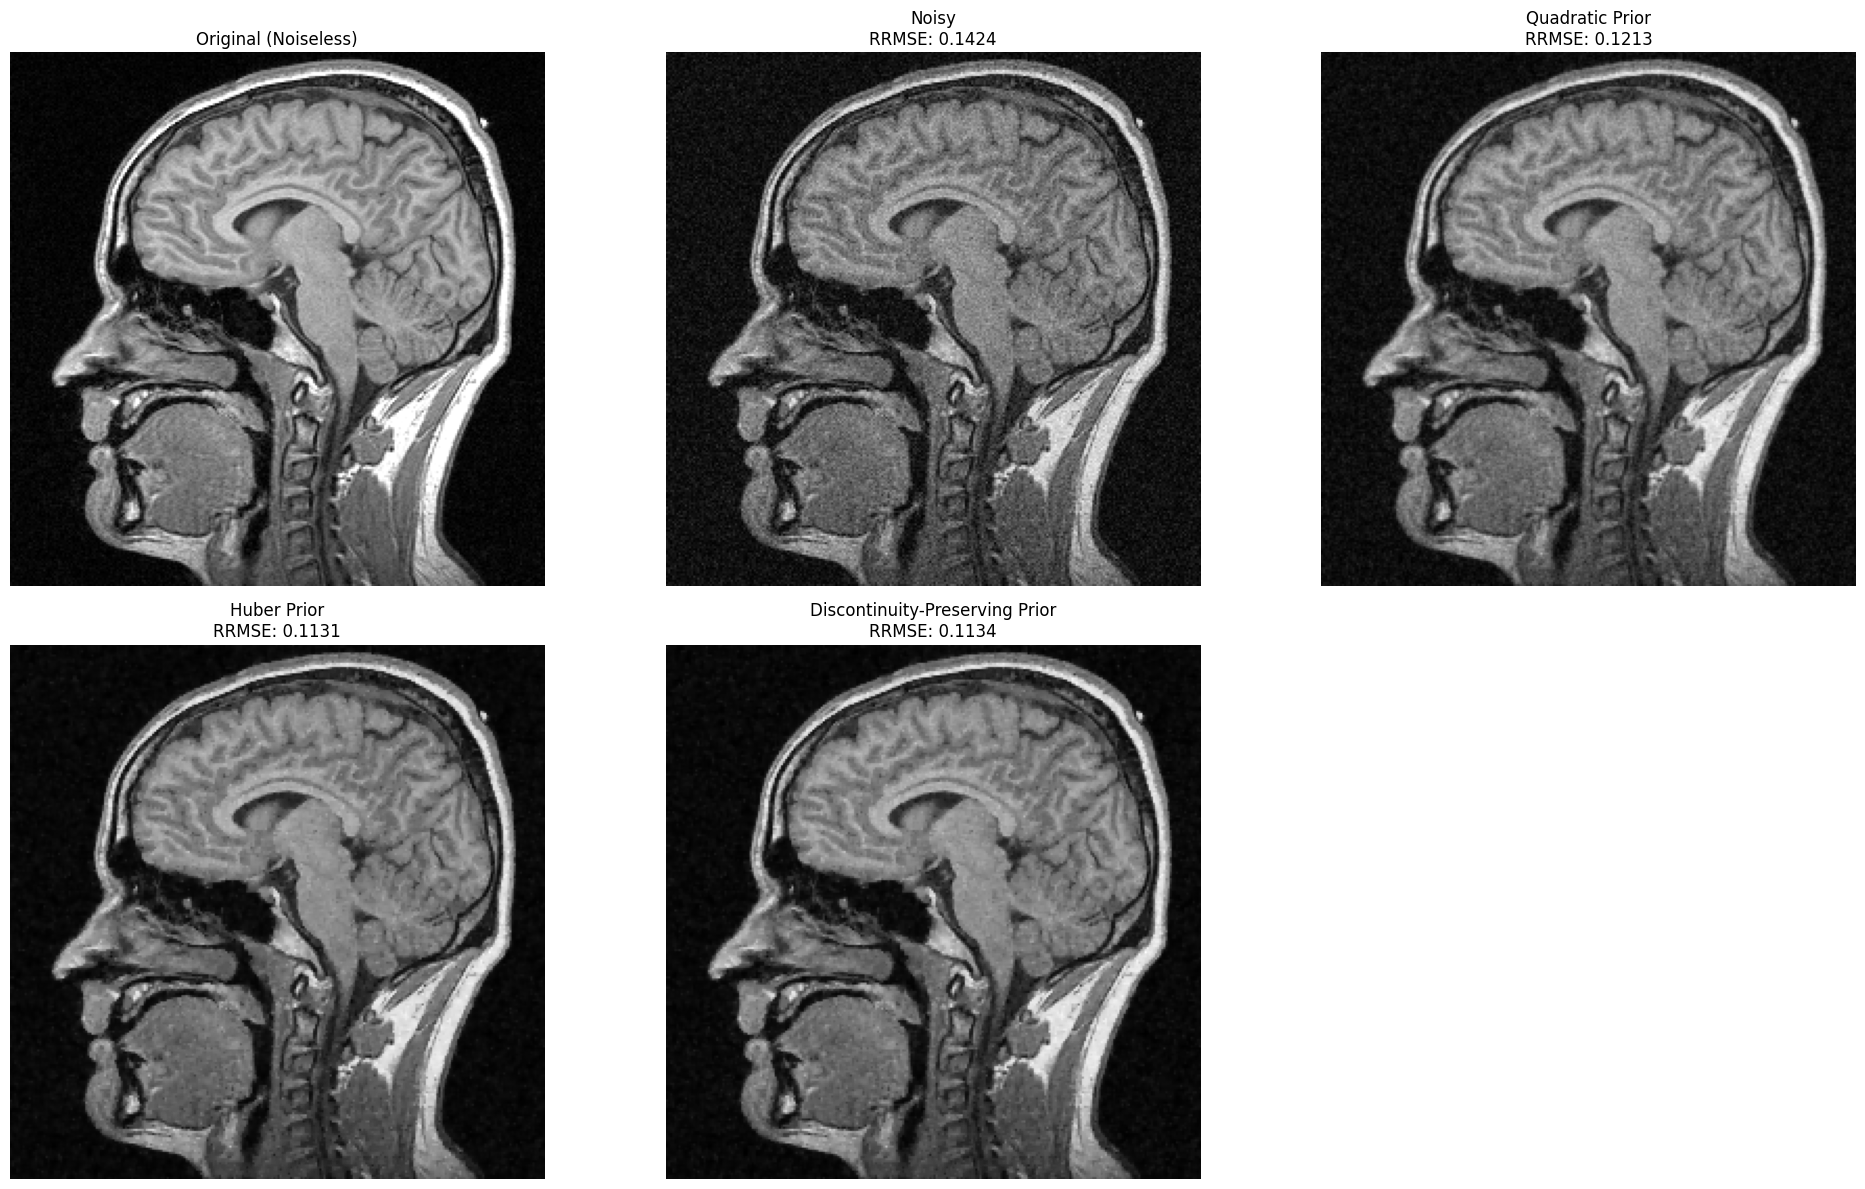

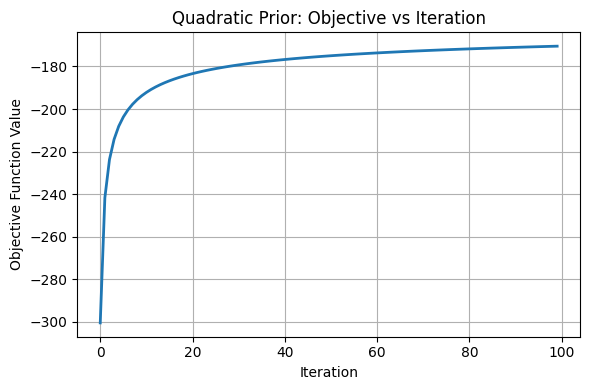

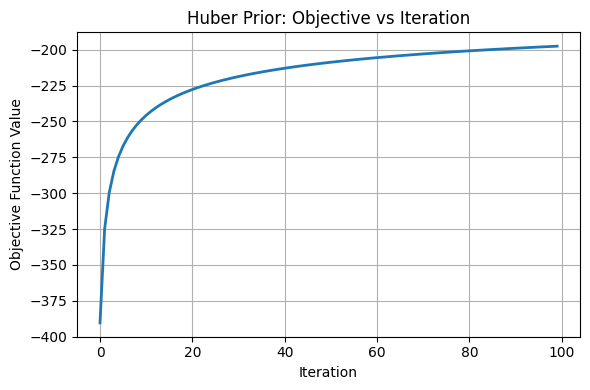

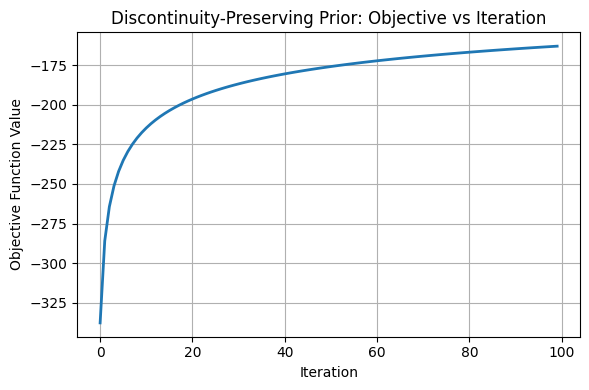


Detailed Parameter Summary:

QUADRATIC:
  α (alpha): 0.07970415035442435
  RRMSE: 0.121299
  MSE: 0.002732
  PSNR: 25.63 dB

HUBER:
  α (alpha): 0.6959533259730074
  γ (gamma): 0.030194485339742113
  RRMSE: 0.113147
  MSE: 0.002377
  PSNR: 26.24 dB

DISCONTINUITY_PRESERVING:
  α (alpha): 0.9982089001856959
  γ (gamma): 0.023875088690692957
  RRMSE: 0.113360
  MSE: 0.002386
  PSNR: 26.22 dB


In [12]:
final_results = {}

den_quad, obj_quad = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_quad,
    prior_type='quadratic',
    max_iterations=100,
    tolerance=1e-7
)
final_results['quadratic'] = {
    'denoised': den_quad,
    'rrmse': compute_rrmse(image_noiseless, den_quad),
    'alpha': best_alpha_quad,
    'gamma': None,
    'objective': obj_quad
}

den_huber, obj_huber = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_huber,
    prior_type='huber',
    gamma=best_gamma_huber,
    max_iterations=100,
    tolerance=1e-7
)
final_results['huber'] = {
    'denoised': den_huber,
    'rrmse': compute_rrmse(image_noiseless, den_huber),
    'alpha': best_alpha_huber,
    'gamma': best_gamma_huber,
    'objective': obj_huber
}

den_disc, obj_disc = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_disc,
    prior_type='discontinuity_preserving',
    gamma=best_gamma_disc,
    max_iterations=100,
    tolerance=1e-7
)
final_results['discontinuity_preserving'] = {
    'denoised': den_disc,
    'rrmse': compute_rrmse(image_noiseless, den_disc),
    'alpha': best_alpha_disc,
    'gamma': best_gamma_disc,
    'objective': obj_disc
}

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.imshow(image_noiseless, cmap='gray')
plt.title('Original (Noiseless)')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title(f'Noisy\nRRMSE: {compute_rrmse(image_noiseless, image_noisy):.4f}')
plt.axis('off')

methods = ['quadratic', 'huber', 'discontinuity_preserving']
titles = ['Quadratic Prior', 'Huber Prior', 'Discontinuity-Preserving Prior']

for i, (method, title) in enumerate(zip(methods, titles)):
    result = final_results[method]

    ax = plt.subplot(2, 3, 3 + i)
    ax.imshow(result['denoised'], cmap='gray')
    ax.set_title(f'{title}\nRRMSE: {result["rrmse"]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['quadratic']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Quadratic Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['huber']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Huber Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['discontinuity_preserving']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Discontinuity-Preserving Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()


print("\nDetailed Parameter Summary:")
print("=" * 60)

for method, result in final_results.items():
    print(f"\n{method.upper()}:")
    print(f"  α (alpha): {result['alpha']}")
    if result['gamma'] is not None:
        print(f"  γ (gamma): {result['gamma']}")
    print(f"  RRMSE: {result['rrmse']:.6f}")

    mse = np.mean((result['denoised'] - image_noiseless) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))

    print(f"  MSE: {mse:.6f}")
    print(f"  PSNR: {psnr:.2f} dB")
